# Formal Languages

## TODOS
` ` **Train LMs on full treebank**

`x` Create fixed datasets for varying complexities 

`~` Compute optimal PCFG perplexity
=> Make sure that optimal PCFG perplexity uses same vocabulary constraints as model tokenizer!

`x` Alter probing setup for larger datasets

` ` Create timeline

` ` Skip <unk> tokens in perplexity calculation
    
`x` Create datasets with same vocabulary but increasing complexity
    
` ` **Deal with vocabulary increase of increasing corpus sizes (right now comparison is off)** Re-sample low frequency items? => resampling will transform the set of low-freq items into (most likely) more frequent items, and as such will make the corpus as a whole easier to process. However, this is still harder than using a generic <unk> token.

=> Focus on smaller corpus sizes is not that important and time-consuming, most optimal model for each corpus class is much more interesting

## Paper TODOS

` ` Background literature: framing in terms of 1) mechanistic interpretability, 2) interpretability faithfulness.

` ` Also highlight that: 1) repurposing of older, interpretable models of language is a ~necessary~ step for a better understanding of model behaviour.


## Imports

In [1]:
%load_ext autoreload
%autoreload 1

import itertools
import random
import sys
import os
import math
import re

from copy import copy, deepcopy
from dataclasses import dataclass
from typing import *
from itertools import product
from collections import defaultdict

import numpy as np
import pandas as pd

import nltk
from nltk import PCFG as nltk_PCFG, Production, ProbabilisticProduction
from nltk.grammar import Nonterminal
from nltk.parse import ChartParser
from nltk.parse import IncrementalLeftCornerChartParser as Parser

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.nn.utils.rnn import (
    pad_sequence,
    pack_padded_sequence,
    pad_packed_sequence,
    PackedSequence,
)
import torch.optim as optim

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from tqdm import *
from scipy.stats import spearmanr, pearsonr

import ray
from ray.tune import JupyterNotebookReporter
from ray.tune.schedulers import ASHAScheduler

from fairseq.modules import TransformerSentenceEncoder

sys.path.append('../../path_explain/')
from path_explain import *

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


def unpad_sequence(tensor, lengths, concat=True):
    """Casts a padded tensor to a concated tensor that omits the pad positions."""
    concat_fn = torch.stack if tensor.ndim > 2 else torch.tensor
    tensor_list = [value for row, idx in zip(tensor, lengths) for value in row[:idx]]

    return concat_fn(tensor_list).to(DEVICE)

# IMPORTS
import numpy as np
import pandas as pd
from glob import glob
import math

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.transforms import Affine2D

# plt.style.use('ggplot')
# sns.set_context("talk")

def rainbow_text(x, y, strings, colors, bolds=None, ax=None, **kwargs):
    """
    Take a list of *strings* and *colors* and place them next to each
    other, with text strings[i] being shown in colors[i].

    Parameters
    ----------
    x, y : float
        Text position in data coordinates.
    strings : list of str
        The strings to draw.
    colors : list of color
        The colors to use.
    ax : Axes, optional
        The Axes to draw into. If None, the current axes will be used.
    **kwargs
        All other keyword arguments are passed to plt.text(), so you can
        set the font size, family, etc.
    """
    bolds = bolds or []
    if ax is None:
        ax = plt.gca()
    t = ax.transAxes
    canvas = ax.figure.canvas

    for idx, (s, c) in enumerate(zip(strings, colors)):
        fontweight = "bold" if idx in bolds else "normal"
        text = ax.text(x, y, s + " ", color=c, transform=t, ha="left", fontweight=fontweight,  **kwargs)

        # Need to draw to update the text position.
        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        t = text.get_transform() + Affine2D().translate(ex.width, 0)


palette = sns.color_palette('Paired', n_colors=20)
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", palette)


plt.rcParams["lines.solid_capstyle"] = 'projecting'

sns.set_theme(style='whitegrid', font_scale=1.2, palette='tab10')
plt.rcParams["lines.solid_capstyle"] = 'projecting'
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rc('hatch', color='1.0', linewidth=.5)
matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

plt.rcParams['font.family'] = 'Helvetica'

In [7]:
"""
Changes to fairseq (v0.10.2), '/home/jaap/miniconda3/lib/python3.8/site-packages/fairseq/modules':

l.115 transformer_sentence_encoder_layer.py:
x, attn = self.self_attn(
    query=x,
    key=x,
    value=x,
    key_padding_mask=self_attn_padding_mask,
    need_weights=True,
    attn_mask=self_attn_mask,
    need_head_weights=True,
)

l.273 transformer_sentence_encoder.py:
attention_maps = []

for layer in self.layers:
    x, attn = layer(x, self_attn_padding_mask=padding_mask)
    if not last_state_only:
        inner_states.append(x)
    attention_maps.append(attn)

sentence_rep = x[0, :, :]

if last_state_only:
    inner_states = [x]

if self.traceable:
    inner_states = torch.stack(inner_states)

return inner_states, sentence_rep, attention_maps
"""

"\nChanges to fairseq (v0.10.2), '/home/jaap/miniconda3/lib/python3.8/site-packages/fairseq/modules':\n\nl.115 transformer_sentence_encoder_layer.py:\nx, attn = self.self_attn(\n    query=x,\n    key=x,\n    value=x,\n    key_padding_mask=self_attn_padding_mask,\n    need_weights=True,\n    attn_mask=self_attn_mask,\n    need_head_weights=True,\n)\n\nl.273 transformer_sentence_encoder.py:\nattention_maps = []\n\nfor layer in self.layers:\n    x, attn = layer(x, self_attn_padding_mask=padding_mask)\n    if not last_state_only:\n        inner_states.append(x)\n    attention_maps.append(attn)\n\nsentence_rep = x[0, :, :]\n\nif last_state_only:\n    inner_states = [x]\n\nif self.traceable:\n    inner_states = torch.stack(inner_states)\n\nreturn inner_states, sentence_rep, attention_maps\n"

## Languages

In [8]:
class Config:
    def __init__(self, **kwargs):
        for kwarg, val in kwargs.items():
            setattr(self, kwarg, val)

    def __repr__(self):
        representation = ""
        
        max_len = max(map(len, self.__dict__.keys()))
        for key, value in self.__dict__.items():
            str_value = str(value).split("\n")[0][:20]
            if len(str(value).split("\n")) > 1 or len(str(value).split("\n")[0]) > 20:
                str_value += " [..]"
            representation += (f"{key:<{max_len+3}}{str_value}\n")
            
        return representation

### Tokenizer

In [9]:
class TokenizerConfig(Config):
    cls_token = "[CLS]"
    mask_token = "<mask>"
    pad_token = "<pad>"
    unk_token = "<unk>"
    unk_threshold: Optional[int] = None
    add_cls: bool = False
    masked_lm: bool = False
    sep_token: str = " "
    resample_unk: bool = False


class Vocab(dict):
    def __init__(self, unk_idx: int, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.unk_idx = unk_idx

    def __missing__(self, key):
        return self.unk_idx


class Tokenizer:
    def __init__(
        self, config: TokenizerConfig
    ):
        self.config = config

        self.idx2token: List[str] = [self.config.unk_token, self.config.pad_token]
        self.token2idx: Dict[str, int] = Vocab(0)

    @property
    def cls_idx(self):
        return self.token2idx.get(self.config.cls_token)

    @property
    def mask_idx(self):
        return self.token2idx.get(self.config.mask_token)

    @property
    def unk_idx(self):
        return self.token2idx.get(self.config.unk_token)

    @property
    def pad_idx(self):
        return self.token2idx.get(self.config.pad_token)

    def create_vocab(self, str_corpus: List[str], pos_dict=None):
        if self.config.masked_lm:
            self.idx2token.append(self.config.mask_token)

        if self.config.add_cls:
            self.idx2token.append(self.config.cls_token)

        if self.config.unk_threshold is not None:
            distribution = Counter(
                w for s in str_corpus for w in s.split(self.config.sep_token)
            )
            self.idx2token.extend(
                [
                    token
                    for token, counts in distribution.items()
                    if counts > self.config.unk_threshold
                ]
            )
        else:
            unique_tokens = set(
                w for s in str_corpus for w in s.split(self.config.sep_token)
            )
            self.idx2token.extend(list(unique_tokens))

        if pos_dict is not None:
            unique_pos = set(
                pos_tag for pos_tags in pos_dict.values() for pos_tag in pos_tags
            )
            self.idx2token.extend(list(unique_pos))

        self.token2idx.update({x: idx for idx, x in enumerate(self.idx2token)})

    def tokenize(
        self, 
        item: Union[str, List[str]], 
        pos_tags: Optional[List[str]] = None,
        grammar: Optional[nltk_PCFG] = None,
    ) -> Tensor:
        if isinstance(item, str):
            item = item.split(self.config.sep_token)

        token_ids = []
        if self.config.add_cls and item[0] != self.config.cls_token:
            token_ids.append(self.cls_idx)

        if pos_tags is None:
            token_ids.extend([self.token2idx[w] for w in item])
        elif grammar is not None:
            assert len(item) == len(pos_tags)
            for w, pos_tag in zip(item, pos_tags):
                if w in self.token2idx:
                    token_ids.append(w)
                else:
                    lhs = Nonterminal(pos_tag)
                    rules = grammar._lhs_index[lhs]
                    probs = grammar._lhs_prob_index[lhs]
                    new_idx = None
                    while new_idx is not None:
                        # Sample until we got a new token that is in the vocab
                        new_token = random.choices(rules, weights=probs, k=1)[0].rhs()[0]
                        new_idx = self.token2idx.get(new_token)
                    token_ids.append(new_idx)
        else:
            assert len(item) == len(pos_tags)
            token_ids.extend(
                [
                    self.token2idx.get(w, self.token2idx[pos_tag])
                    for w, pos_tag in zip(item, pos_tags)
                ]
            )

        return torch.tensor(token_ids, device=DEVICE)

    def translate(self, item: Tensor, omit_cls: bool = False) -> str:
        sen_list = [self.idx2token[idx] for idx in item.tolist()]
        if omit_cls:
            sen_list = sen_list[1:]

        return self.config.sep_token.join(sen_list)

    def make_masked_post_hoc(self) -> None:
        self.config.masked_lm = True
        if self.config.mask_token not in self.token2idx:
            self.token2idx[self.config.mask_token] = len(self.token2idx)
            self.idx2token.append(self.config.mask_token)

    def add_cls_post_hoc(self) -> None:
        self.config.add_cls = True

        if self.config.cls_token not in self.token2idx:
            self.token2idx[self.config.cls_token] = len(self.token2idx)
            self.idx2token.append(self.config.cls_token)

### Language

In [10]:
BinaryCorpus = List[Tuple[Tensor, int]]
LMCorpus = List[Tensor]
Corpus = Union[BinaryCorpus, LMCorpus]


class LanguageConfig(Config):
    is_binary: bool = False
    real_output: bool = False
    split_ratio: Tuple[float, float, float] = (0.8, 0.1, 0.1)
    corpus_size: Optional[int] = None
    corrupt_k: Optional[int] = None
    masked_lm: bool = False
    mask_ratio: float = 0.01
    allow_duplicates: bool = False
    use_unk_pos_tags: bool = False
    resample_unk: bool = False
    file: Optional[str] = None
    store_trees: bool = True


C = TypeVar("C", bound=LanguageConfig)


class Language(Generic[C]):
    def __init__(self, config: C, tokenizer: Tokenizer):
        assert sum(config.split_ratio) == 1.0, "train/dev/test split does not add to 1"

        self.config = config
        self.tokenizer = tokenizer
        self.grammar = self.create_grammar()

        if self.config.file is not None:
            self.corpus, self.tree_corpus, self.pos_dict = torch.load(self.config.file)
            if self.config.corpus_size is not None and self.config.corpus_size < len(self.corpus):
                # This allows us to subsample the larger corpus directly for smaller corpus sizes
                self.corpus = self.corpus[:self.config.corpus_size]
                self.tree_corpus = {sen: self.tree_corpus[sen] for sen in self.corpus}
                self.pos_dict = {sen: self.pos_dict[sen] for sen in self.corpus}
        else:
            self.tree_corpus: Dict[str, nltk.Tree] = {}
            self.pos_dict: Dict[str, List[str]] = {}  # maps sentence to pos tags
            self.corpus = self.create_corpus()

        if config.is_binary or config.real_output:
            self.corpus = self.append_corrupt_corpus(self.corpus)

        self.train_corpus, self.dev_corpus, self.test_corpus = self.split()

        self.tokenizer.create_vocab(self.train_corpus, pos_dict=self.pos_dict)

    def __len__(self):
        return len(self.train_corpus) + len(self.dev_corpus) + len(self.test_corpus)

    def save(self, file_name: str) -> None:
        torch.save((self.corpus, self.tree_corpus, self.pos_dict), file_name)

    @property
    def num_symbols(self):
        return len(self.tokenizer.token2idx)

    def create_grammar(self) -> Optional[nltk_PCFG]:
        pass

    def create_corpus(self) -> List[str]:
        raise NotImplementedError

    def make_binary(self, corrupt_grammar, clone=False):
        language = deepcopy(self) if clone else self
        language.config.is_binary = True
        language.config.corrupt_grammar = corrupt_grammar
        language.corpus = language.append_corrupt_corpus(self.corpus)

        language.train_corpus, language.dev_corpus, language.test_corpus = language.split()

        return language

    def make_mlm(self) -> None:
        if not self.config.masked_lm:
            self.config.masked_lm = True
            self.tokenizer.make_masked_post_hoc()
            self.tokenizer.add_cls_post_hoc()

    def append_corrupt_corpus(self, corpus: List[Tensor]) -> List[Tuple[Tensor, int]]:
        corrupt_corpus = []

        for item in corpus:
            corrupt_corpus.append(self._create_corrupt_item(item.clone()))

        # merge corrupt corpus with original one + add labels
        new_corpus = [
            (item, label)
            for items, label in [(corrupt_corpus, 0), (corpus, 1)]
            for item in items
        ]

        return new_corpus

    def _create_corrupt_item(self, item: Tensor, *args, **kwargs) -> Tensor:
        raise NotImplementedError

    def split(self):
        random.shuffle(self.corpus)
        train_ratio, dev_ratio, test_ratio = self.config.split_ratio

        if self.config.allow_duplicates:
            item_distribution = Counter(self.corpus)
            unique_items = list(item_distribution.keys())

            train_split_idx = int(len(item_distribution) * train_ratio)
            dev_split_idx = int(len(item_distribution) * (train_ratio + dev_ratio))
            test_split_idx = int(len(item_distribution) * (train_ratio + dev_ratio + test_ratio))

            train_items = unique_items[:train_split_idx]
            dev_items = unique_items[train_split_idx:dev_split_idx]
            test_items = unique_items[dev_split_idx:test_split_idx]

            # Duplicate each unique item according to the original counts of the item
            train_items = [x for item in train_items for x in [item] * item_distribution[item]]
            dev_items = [x for item in dev_items for x in [item] * item_distribution[item]]
            test_items = [x for item in test_items for x in [item] * item_distribution[item]]
        else:
            train_split_idx = int(len(self.corpus) * train_ratio)
            dev_split_idx = int(len(self.corpus) * (train_ratio + dev_ratio))
            test_split_idx = int(len(self.corpus) * (train_ratio + dev_ratio + test_ratio))

            train_items = self.corpus[:train_split_idx]
            dev_items = self.corpus[train_split_idx:dev_split_idx]
            test_items = self.corpus[dev_split_idx:test_split_idx]

        return train_items, dev_items, test_items

    def batchify(self, *args, corpus: List[str] = None, **kwargs):
        corpus = corpus or self.train_corpus
        if self.config.is_binary:
            corpus, labels = zip(*corpus)
            corpus = list(corpus)

        tokenized_corpus = self.tokenize_corpus(corpus)

        if self.config.is_binary:
            return self.batchify_binary(tokenized_corpus, labels, *args, **kwargs)
        elif self.config.masked_lm:
            return self.batchify_masked(tokenized_corpus, *args, **kwargs)
        else:
            return self.batchify_generative(tokenized_corpus, *args, **kwargs)

    def tokenize_corpus(self, corpus: List[str]) -> List[Tensor]:
        if self.config.resample_unk:
            return [
                self.tokenizer.tokenize(
                    sen, 
                    pos_tags=tree_to_pos(self.tree_corpus[sen], merge=False), 
                    grammar=lm_language.grammar
                )
                for sen in corpus
            ]
        else:
            return [
                self.tokenizer.tokenize(sen, pos_tags=self.pos_dict.get(sen))
                for sen in corpus
            ]

    def batchify_binary(self, corpus: List[Tensor], labels, batch_size=None):
        batch_size = batch_size or len(corpus)

        corpus_lengths = torch.tensor([x.shape[0] for x in corpus])

        padded_corpus = pad_sequence(corpus, batch_first=True, padding_value=self.tokenizer.pad_idx)

        for idx in range(0, len(corpus), batch_size):
            input_ids = padded_corpus[idx: idx + batch_size]
            lengths = corpus_lengths[idx: idx + batch_size]

            targets = torch.tensor(labels[idx: idx + batch_size])

            yield input_ids.to(DEVICE), targets.to(DEVICE).float(), lengths, None

    def batchify_masked(self, corpus: List[Tensor], batch_size=None):
        batch_size = batch_size or len(corpus)

        corpus_lengths = torch.tensor([len(x) for x in corpus])

        padded_corpus = pad_sequence(corpus, batch_first=True, padding_value=self.tokenizer.pad_idx)

        for idx in range(0, len(corpus), batch_size):
            input_ids = padded_corpus[idx: idx + batch_size]
            lengths = corpus_lengths[idx: idx + batch_size]

            masks = [
                random.sample(
                    range(int(self.tokenizer.config.add_cls), length),
                    k=math.ceil(self.config.mask_ratio * length)
                )
                for length in lengths
            ]
            targets = []

            for jdx, mask in enumerate(masks):
                targets.extend(input_ids[jdx, mask].tolist())
                input_ids[jdx, mask] = self.tokenizer.mask_idx

            targets = torch.tensor(targets)

            yield input_ids.to(DEVICE), targets.to(DEVICE), lengths, masks

    def batchify_generative(self, corpus: List[Tensor], batch_size=None):
        batch_size = batch_size or len(corpus)

        corpus_lengths = torch.tensor([len(x) for x in corpus])

        padded_corpus = pad_sequence(corpus, batch_first=True, padding_value=self.tokenizer.pad_idx)

        for idx in range(0, len(corpus), batch_size):
            items = padded_corpus[idx: idx + batch_size]
            lengths = corpus_lengths[idx: idx + batch_size] - 1

            input_ids = items[:, :-1]
            targets = items[:, 1:]
            flat_targets = unpad_sequence(targets, lengths)

            yield input_ids.to(DEVICE), flat_targets.to(DEVICE), lengths, None

    def gen_baselines(*args, **kwargs):
        raise NotImplementedError

    def plot_sen_len_distribution(self, title=None):
        item_lens = [len(x) for x in self.corpus]
        sns.histplot(item_lens, color="orange", bins=range(min(item_lens), max(item_lens)))
        if self.config.allow_duplicates:
            unique_items = set(self.corpus)
            unique_lens = [len(x) for x in [x.split(self.tokenizer.config.sep_token) for x in unique_items]]
            sns.histplot(unique_lens, color="yellow", alpha=0.5, bins=range(min(item_lens), max(item_lens)))

        plt.xlabel("Sentence length")
        if title:
            plt.title(title)

        plt.show()

### Treebank

In [11]:
def tree_to_pos(tree, merge=True):
    if merge:
        return [
            prod.lhs().symbol().split('_')[0] for prod in tree.productions()
            if isinstance(prod.rhs()[0], str)
        ]
    else:
        return [
            prod.lhs().symbol() for prod in tree.productions()
            if isinstance(prod.rhs()[0], str)
        ]


class TreebankConfig(LanguageConfig):
    file: str
    max_length: int
    max_depth: int
    start: str
    min_length: int = 0
    sample: bool = False
    skip_root: bool = True


class Treebank(Language[TreebankConfig]):
    def __repr__(self):
        return str(self.config.file)
    
    def create_corpus(self) -> List[str]:
        with open(self.config.file) as f:
            lines = f.readlines()
        
        if self.config.sample:
            random.shuffle(lines)
        
        str_corpus = []
        
        for line in lines:
            tree = nltk.Tree.fromstring(line)

            if self.config.skip_root:
                tree = tree[0]
            
            if (
                tree.height() < self.config.max_depth
                and self.config.min_length <= len(tree.leaves()) <= self.config.max_length
                and tree.label() == self.config.start
            ):
                str_item = self.tokenizer.config.sep_token.join(tree.leaves())
                str_corpus.append(str_item)
                self.tree_corpus[str_item] = tree
                if self.config.use_unk_pos_tags:
                    self.pos_dict[str_item] = tree_to_pos(tree)
                
            if self.config.corpus_size is not None and len(str_corpus) >= self.config.corpus_size:
                break

        unique_prods = set(prod for tree in self.tree_corpus.values() for prod in tree.productions())
        self.grammar = nltk.CFG(Nonterminal(self.config.start), list(unique_prods))

        return str_corpus

### PCFG

In [12]:
class PCFGConfig(LanguageConfig):
    grammar_file: str
    max_length: int
    max_depth: int
    min_length: int = 0
    corrupt_grammar: Optional[Union[str, Callable[[Corpus], Corpus]]] = None
    start: Optional[str] = None
    generation_factor: int = 10
    verbose: bool = True


class PCFG(Language[PCFGConfig]):
    def __repr__(self):
        return str(self.grammar)

    def create_corpus(self) -> Corpus:
        corpus = self._generate_corpus(self.grammar)

        return corpus

    def create_grammar(self) -> nltk_PCFG:
        with open(self.config.grammar_file) as f:
            raw_grammar = f.read()
        grammar = nltk_PCFG.fromstring(raw_grammar)

        if self.config.start is not None:
            grammar._start = Nonterminal(self.config.start)

        grammar._lhs_prob_index = {}
        for lhs in grammar._lhs_index.keys():
            lhs_probs = [prod.prob() for prod in grammar.productions(lhs=lhs)]
            grammar._lhs_prob_index[lhs] = lhs_probs

        return grammar

    def _generate_corpus(self, grammar: nltk_PCFG) -> List[str]:
        """
            We divide the generation in an inner and outer loop:
            The outer loop sets up a new generation procedure, the inner loop
            determines how many items we sample from a top-down approach,
            This outer/inner division appears to yield the least redundant generation.
        """
        str_corpus = set()

        total = self.config.corpus_size * self.config.generation_factor

        iterator = tqdm_notebook(range(total)) if self.config.verbose else range(total)

        try:
            for _ in iterator:
                tree = generate_tree(grammar, depth=self.config.max_depth)
                item = tree.leaves()
                item_len = len(item)

                if self.config.min_length < item_len < self.config.max_length:
                    str_item = self.tokenizer.config.sep_token.join(item)
                    if not self.config.allow_duplicates and str_item in str_corpus:
                        continue

                    str_corpus.add(str_item)
                    if self.config.store_trees:
                        self.tree_corpus[str_item] = tree
                    if self.config.use_unk_pos_tags:
                        self.pos_dict[str_item] = tree_to_pos(tree)

                if len(str_corpus) >= self.config.corpus_size:
                    return list(str_corpus)
        except KeyboardInterrupt:
            pass

        return list(str_corpus)

    def append_corrupt_corpus(self, corpus: List[Tensor]) -> List[Tuple[Tensor, int]]:
        assert self.config.corrupt_grammar is not None

        if isinstance(self.config.corrupt_grammar, str):
            with open(self.config.corrupt_grammar) as f:
                raw_grammar = f.read()
            corrupt_grammar = nltk_PCFG.fromstring(raw_grammar)

            if self.config.start is not None:
                corrupt_grammar._start = Nonterminal(self.config.start)

            corrupt_corpus = self._generate_corpus(corrupt_grammar)
        else:
            corrupt_corpus = self.config.corrupt_grammar(self)

        # merge corrupt corpus with original one + add labels
        new_corpus = [
            (item, label)
            for items, label in [(corrupt_corpus, 0), (corpus, 1)]
            for item in items
        ]

        return new_corpus

    def gen_parse(self, sen: List[str]):
        srp = ChartParser(self.grammar)

        for parse in srp.parse(sen):
            print(parse)

        return next(srp.parse(sen))


def swap_characters(pcfg: PCFG):
    """ Randomly swaps two symbols in the string """
    chart_parser = Parser(pcfg.grammar)
    add_cls = pcfg.config.add_cls

    corrupt_corpus = []

    for item in pcfg.corpus:
        parses = [None]

        while len(parses) > 0:
            i, j = sorted(random.sample(range(int(add_cls), len(item)), 2))
            a, x, b, y, c = item[:i], item[[i]], item[i + 1:j], item[[j]], item[j + 1:]
            new_item = torch.cat((a, y, b, x, c))
            new_sen = pcfg.translate(new_item).split()
            if add_cls:
                new_sen = new_sen[1:]
            parses = list(chart_parser.parse(new_sen))

        corrupt_corpus.append(new_item)

    return corrupt_corpus


def generate_pcfg(grammar, start=None, depth=None, n=None):
    if not start:
        start = grammar.start()
    if depth is None:
        depth = 1_000

    iterator = _generate_all_pcfg(grammar, [start], depth)

    if n:
        iterator = itertools.islice(iterator, n)

    return iterator


def _generate_all_pcfg(grammar, items, depth):
    if items:
        for frag1 in _generate_one_pcfg(grammar, items[0], depth):
            for frag2 in _generate_all_pcfg(grammar, items[1:], depth):
                yield frag1 + frag2
    else:
        yield []


def _generate_one_pcfg(grammar, lhs, depth):
    if depth > 0:
        if isinstance(lhs, Nonterminal):
            productions = grammar.productions(lhs=lhs)
            probs = grammar._lhs_prob_index[lhs]

            for prod in random.choices(productions, probs, k=1):
                yield from _generate_all_pcfg(grammar, prod.rhs(), depth - 1)
        else:
            yield [lhs]
    else:
        yield []


def generate_tree(grammar, start=None, depth=None, max_tries=10) -> nltk.Tree:
    if not start:
        start = grammar.start()
    if depth is None:
        depth = 100

    for _ in range(max_tries):
        try:
            tree_str = concatenate_subtrees(grammar, [start], depth)
            return nltk.Tree.fromstring(tree_str)
        except RecursionError:
            pass

    raise ValueError("No tree could be generated with current depth")


def concatenate_subtrees(grammar, items, depth):
    if items:
        children = []
        for item in items:
            children.append(generate_subtree(grammar, item, depth))

        return " ".join(children)
    else:
        return []


def generate_subtree(grammar, lhs, depth):
    if depth > 0:
        if isinstance(lhs, Nonterminal):
            productions = grammar.productions(lhs=lhs)
            probs = grammar._lhs_prob_index[lhs]

            for prod in random.choices(productions, probs, k=1):
                children = concatenate_subtrees(grammar, prod.rhs(), depth - 1)
                return f"({lhs.symbol()} {children})"
        else:
            return lhs
    else:
        raise RecursionError


def cfg_str(prod):
    return Production.__str__(prod)


def rev_prod(prod):
    return Production(prod.lhs(), prod.rhs()[::-1])


def swap_subtrees(language: PCFG):
    """ Randomly swaps two subtrees in the parse tree """
    chart_parser = Parser(language.grammar)
    cfg_productions = set(
        cfg_str(prod)
        for prod in language.grammar.productions()
    )

    corrupt_corpus = []
    sep_token = language.tokenizer.config.sep_token

    for tree in language.tree_corpus.values():
        corrupted_tree = swap_subtree(tree.copy(), chart_parser, cfg_productions)
        corrupt_corpus.append(sep_token.join(corrupted_tree.leaves()))

    return corrupt_corpus


def swap_subtree(tree: nltk.Tree, parser: ChartParser, cfg_productions) -> nltk.Tree:
    binary_prods = [
        prod for prod in tree.productions()
        if len(prod.rhs()) == 2
        and cfg_str(rev_prod(prod)) not in cfg_productions
    ]

    corrupted_prod = random.choice(binary_prods)
    for subtree in tree.subtrees():
        if subtree.productions()[0] == corrupted_prod:
            subtree.reverse()
            break

    try:
        # Recursively try again if corrupted sentence yields a parse tree
        next(parser.parse(tree.leaves()))
        return swap_subtree(tree, parser, cfg_productions)
    except StopIteration:
        return tree

#### PCFG Saving

In [ ]:
import gc

encoder = "lstm"
for ratio in [10]:# range(8,11):
    ratio = ratio/10
    print(ratio)
    grammar_file = f"petrov/500k_5SM/subsets/{ratio}_petrov_words_all_leaves.txt"

    tokenizer_config = TokenizerConfig(
        add_cls=(encoder == "transformer"),
        masked_lm=(encoder == "transformer"),
        unk_threshold=5,
    )

    config = PCFGConfig(
        is_binary=False,
        min_length=6,
        max_length=25,
        max_depth=25,
        corpus_size=9_500_000,
        grammar_file=grammar_file,
        start="S_0",
        masked_lm=(encoder == "transformer"),
        allow_duplicates=True,
        split_ratio=(1.,0.,0.),
        use_unk_pos_tags=True,
        verbose=True,
        store_trees=False,
    )
    tokenizer = Tokenizer(tokenizer_config)
    
    lm_language = PCFG(config, tokenizer)

    # lm_language.save(f'{ratio}_500k.pt')

    with open(f'corpora/train_1.0_{len(lm_language.train_corpus)}.txt', 'w') as f:
        f.write('\n'.join(lm_language.train_corpus))

#     with open('corpora/dev_1.0.txt', 'w') as f:
#         f.write('\n'.join(lm_language.dev_corpus))

#     with open('corpora/test_1.0.txt', 'w') as f:
#         f.write('\n'.join(lm_language.test_corpus))

    # del lm_language
    # del tokenizert
    # gc.collect()

1.0


<ipython-input-11-eabf35807ce6>:47: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  iterator = tqdm_notebook(range(total)) if self.config.verbose else range(total)


  0%|          | 0/95000000 [00:00<?, ?it/s]

In [9]:
with open('corpora/train_1.0_6647780.txt') as f:
    new_train = f.read().split('\n')

with open('corpora/train_1.0-1M.txt') as f:
    old_train = f.read().split('\n')
    
with open('corpora/dev_1.0.txt') as f:
    old_dev = f.read().split('\n')
    
with open('corpora/test_1.0.txt') as f:
    old_test = f.read().split('\n')
    
with open('corpora/eval_sens_10k.txt') as f:
    old_eval = f.read().split('\n')
    
eval_set = set(old_eval)

In [10]:
not_in_eval = []

for sen in tqdm_notebook(new_train + old_train + old_dev + old_test):
    if sen not in eval_set:
        not_in_eval.append(sen)

<ipython-input-10-3c2191ca0faf>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sen in tqdm_notebook(new_train + old_train + old_dev + old_test):


  0%|          | 0/7647780 [00:00<?, ?it/s]

In [11]:
new_test = not_in_eval[:25000]
new_test_set = set(new_test)

not_in_test = []
for sen in tqdm_notebook(not_in_eval):
    if sen not in new_test_set:
        not_in_test.append(sen)
        
new_dev = not_in_test[:25000]
new_dev_set = set(new_dev)

not_in_dev = []
for sen in tqdm_notebook(not_in_test):
    if sen not in new_dev_set:
        not_in_dev.append(sen)
        
new_train = not_in_dev

<ipython-input-11-2a3c143090bf>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sen in tqdm_notebook(not_in_eval):


  0%|          | 0/7647776 [00:00<?, ?it/s]

<ipython-input-11-2a3c143090bf>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sen in tqdm_notebook(not_in_test):


  0%|          | 0/7622776 [00:00<?, ?it/s]

In [17]:
with open('corpora/final_corpora/train.txt', 'w') as f:
    f.write('\n'.join(new_train))
    
with open('corpora/final_corpora/dev.txt', 'w') as f:
    f.write('\n'.join(new_dev))
    
with open('corpora/final_corpora/test.txt', 'w') as f:
    f.write('\n'.join(new_test))

In [16]:
with open('corpora/train_1.0.txt') as f:
    lines = f.read().split('\n')
    
with open('corpora/train_1.0-1M.txt', 'w') as f:
    f.write('\n'.join(lines + lm_language.train_corpus))

In [49]:
import gc

encoder = "lstm"

ratio = 1.0
grammar_file = f"petrov/500k_5SM/subsets/{ratio}_petrov_words_all_leaves.txt"

tokenizer_config = TokenizerConfig(
    add_cls=(encoder == "transformer"),
    masked_lm=(encoder == "transformer"),
    unk_threshold=5,
)

config = PCFGConfig(
    is_binary=False,
    min_length=6,
    max_length=20,
    max_depth=20,
    corpus_size=10_000,
    grammar_file=grammar_file,
    start="S_0",
    masked_lm=(encoder == "transformer"),
    allow_duplicates=True,
    split_ratio=(1.0,0.,0.),
    use_unk_pos_tags=True,
    verbose=True,
    store_trees=True,
)
tokenizer = Tokenizer(tokenizer_config)
lm_language = PCFG(config, tokenizer)

lm_language.save(f'{ratio}_10k_probing.pt')

# with open('corpora/probe_corpus.txt', 'w') as f:
#     f.write('\n'.join(lm_language.train_corpus))

# del lm_language
# del tokenizer
# gc.collect()

trees = list(lm_language.tree_corpus.values())

with open('corpora/eval_trees_10k.txt', 'w') as f:
    f.write('\n'.join([' '.join(str(tree).split()) for tree in trees]))

<ipython-input-48-3e6e01e2d36a>:47: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  iterator = tqdm_notebook(range(total)) if self.config.verbose else range(total)


  0%|          | 0/100000 [00:00<?, ?it/s]

#### Petrov PCFG Statistics

##### ZIPF

In [2]:
with open('corpora/final_corpora/train.txt') as f:
    new_train = f.read().split('\n')[:450_000]
    
with open('/home/jaap/Documents/AI/diagnosing_lms/experiments/explain-lm/books/cleaned_parsed_corpus_part1/450k_train.txt') as f:
    treebank = f.read().split('\n')

In [3]:
with open('./raw_pcfg_corpus.txt') as f:
    raw_pcfg = f.read().split('\n')

In [4]:
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel,\
        GenericLikelihoodModelResults

from statsmodels.nonparametric.smoothers_lowess import lowess


from scipy.special import zeta
from scipy.stats import binom

import pickle

import numpy as np
lg = np.log10


class Mandelbrot(GenericLikelihoodModel):
    def to_pickle(self, filename, remove_data=True):
        if not filename.endswith(".pkl"):
            filename += ".pkl"
        
        if not self.fit_result:
            raise ValueError("No fit result registered yet; pickling pointless!")
        
        if remove_data:
            self.fit_result.model = None
            self.fit_result.exog = None
            self.fit_result.endog = None
            
            
        with open(filename, "wb") as handle:
            pickle.dump(self.fit_result, handle)   
            
    @classmethod
    def from_pickle(cls, filename, to_class=False, frequencies=None, 
                    ranks=None, **kwargs):
        
        if not filename.endswith(".pkl"):
            filename += ".pkl"        
        with open(filename, "rb") as handle:
            fit_res = pickle.load(handle)
            
        if not to_class:
            return fit_res
        
        if (frequencies is None) or (ranks is None):
            raise ValueError("Mandelbrot class can only be instatiated with" 
                              "frequencies and ranks given!")
            
        mandel = cls(frequencies, ranks, **kwargs)
        fit_res.model = mandel
        mandel.register_fit(fit_res)
        return mandel
            
        
    
    def __init__(self, frequencies, ranks, **kwargs):
        if not len(frequencies) == len(ranks):
            raise ValueError("NOT THE SAME NUMBER OF RANKS AND FREQS!")
        
        frequencies = np.asarray(frequencies)
        ranks = np.asarray(ranks)
        
        self.n_obs = np.sum(frequencies)
        
        super().__init__(endog=frequencies, exog=ranks, **kwargs)
        self.fit_result = None
    

    def prob(self, params, ranks=None, log=False):
        if ranks is None:
            ranks = self.exog
        
        alpha, beta = params
        if log:
            return -alpha*lg(beta+ranks) - lg(zeta(alpha, q=beta+1.))
        else:
            return ((beta + ranks)**(-alpha))/zeta(alpha, q=beta+1.)
    
    
    def loglike(self, params, frequencies=None, ranks=None):
        rs = self.exog if (ranks is None) else ranks 
        fs = self.endog if (frequencies is None) else frequencies
        alpha, beta = params
        
        if alpha < 1.0 or beta < 0.0:
            return -np.inf
        
        # no need to calculate P(r) when observed f(r) was zero
        log_probs = -alpha*lg(beta+rs) - lg(zeta(alpha, q=beta+1.))
        log_probs = log_probs.reshape(-1, )
        return np.sum(fs * log_probs) - beta**5
    
    
    def register_fit(self, fit_result, overwrite=False):
        if not self.fit_result is None and not overwrite:
            raise ValueError("A fit result is already registered and overwrite=False!")
            
        self.fit_result = fit_result
        self.optim_params = fit_result.params
        self.pseudo_r_squared = self.pseudo_r_squared(self.optim_params)
        self.SE, self.SE_relative = fit_result.bse, fit_result.bse/self.optim_params
        self.BIC, self.BIC_relative = fit_result.bic,\
                            (-2*self.null_loglike())/fit_result.bic
    
    def print_result(self, string=False):
        if self.fit_result is None:
            raise ValueError("Register a fitting result first!")

        def format_x(x):
            return float('{0:.3g}'.format(x))


        s = "="*50
        s += "\n" + "MANDELBROT"
        s += "\n" + "  Optimal Parameters " + str(tuple(map(format_x, self.optim_params)))
        
        s += "\n" + "  Standard Error [relative]: " + str(tuple(map(format_x, self.SE))) +\
              ", [" + str(tuple(map(format_x, self.SE_relative))) + "]"
        
        s += "\n" + "  Pseudo R^2: " + str(format_x(self.pseudo_r_squared))
        
        s += "\n" + "  BIC [relative]: " + str(format_x(self.BIC)) +\
              ", [" + str(format_x(self.BIC_relative)) + "]"
        s += "\n" + "="*50
        
        if string:
            return s
        
        print(s)
    
    
    def null_loglike(self, epsilon=1e-10):
        return self.loglike((1.+epsilon, 0.0))
    
    def pseudo_r_squared(self, params):
        return 1-self.loglike(params)/self.null_loglike()
    
    
    def predict(self, params, ranks=None, freqs=True, n_obs=None, 
                correct_for_finite_domain=True):
        if ranks is None:
            ranks = self.exog
        ranks = np.asarray(ranks)
        
        if n_obs is None:
            n_obs = self.n_obs
            
        alpha, beta = params
        pred_probs = self.prob(params, ranks=ranks, log=False)
        
        if correct_for_finite_domain:
            if not freqs:
                raise NotImplementedError("Correction for "\
                                          "finite domain not implemented with probabilities!")
            return pred_probs*(n_obs/np.sum(pred_probs))
        
        if freqs:
            return n_obs*pred_probs
        
        return pred_probs

<ipython-input-12-619097e08ae0>:35: RuntimeWarning: divide by zero encountered in log
  np.log(np.arange(len(norm_freq_order))),
/home/jaap/miniconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2742: UserWarning: df_model + k_constant + k_extra differs from k_params
  warnings.warn("df_model + k_constant + k_extra "
/home/jaap/miniconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2746: UserWarning: df_resid differs from nobs - k_params
  warnings.warn("df_resid differs from nobs - k_params")
<ipython-input-12-619097e08ae0>:65: RuntimeWarning: divide by zero encountered in log
  np.log(x),
<ipython-input-12-619097e08ae0>:35: RuntimeWarning: divide by zero encountered in log
  np.log(np.arange(len(norm_freq_order))),
/home/jaap/miniconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2742: UserWarning: df_model + k_constant + k_extra differs from k_params
  warnings.warn("df_model + k_constant + k_extra "
/home/jaap/miniconda3/lib/python3.8/site-packages/sta

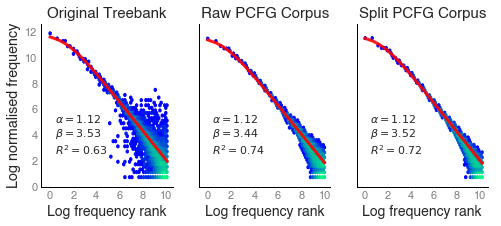

In [12]:
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit


def func(r, alpha, beta):
    return (r+beta)**-alpha


def plot_zipf(corpus, corpus_size=50_000, xlim=(-1,10), ylim=(-13,-1), title=None, ax=None, skip_ylabel=False, n_gram=1):
    if corpus_size is None:
        corpus_size = len(corpus) // 2

    corpus1 = ['_'.join(sen.split()[idx:idx+n_gram]) for sen in corpus[:corpus_size] for idx in range(len(sen.split()))]
    token_set1 = set(corpus1)

    corpus2 = ['_'.join(sen.split()[idx:idx+n_gram]) for sen in corpus[corpus_size:corpus_size*2] for idx in range(len(sen.split()))]
    token_set2 = set(corpus2)

    corpus1 = [w for w in corpus1 if w in token_set2]

    counts1 = Counter(corpus1)
    total_counts1 = sum(counts1.values())
    # for w, c in counts1.items():
    #     counts1[w] = c/total_counts1

    counts2 = Counter(corpus2).most_common()

    norm_freq_order = [counts1[w] for w, c in counts2 if counts1[w] > 1]

    if ax is None:
        plt.figure(figsize=(4,4))
        ax = plt.gca()
    
    ax.hexbin(
        np.log(np.arange(len(norm_freq_order))), 
        np.log(norm_freq_order), 
        gridsize=50, 
        mincnt=1,
        cmap='winter',
        bins='log',
    )

    x = np.arange(len(norm_freq_order))
    y = np.log(norm_freq_order)

    mandelbrot = Mandelbrot(y, x)
    result = mandelbrot.fit(
        start_params=np.asarray([1.0, 1.0]), 
        method="powell", 
        full_output=True, 
        disp=0,
    )
    
    a, b = result.params
        
    pred = func(x, a, b)
    pred = pred * (total_counts1 / np.sum(pred))

    r2 = r2_score(
        y, 
        np.log(pred),
    )
    
    ax.plot(
        np.log(x),
        np.log(pred),
        color='red',
        lw=3,
        alpha=0.9,
    )

    
    ax.text(
        .1, 
        .2, 
        f'$\\alpha={a:.2f}$\n$\\beta={b:.2f}$\n$R^2={r2:.2f}$', 
        fontsize=11,
        transform=ax.transAxes,
    )
    

    ax.grid(False)
    xmin, xmax = ax.get_xlim()
    ax.set_xlim(xmin-.75,xmax+.5)
    
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin-.25, ymax+.25)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.setp(ax.spines.values(), color="black", lw=1)
    
    ax.tick_params(axis='both', which='major', pad=-2, colors='0.5', labelsize=11)
    ax.set_xticks(range(0,11,2))

    ax.set_xlabel("Log frequency rank", fontsize=14)
    if not skip_ylabel:
        ax.set_ylabel("Log normalised frequency")
    
    if title is not None:
        ax.set_title(title, fontsize=15)
    
    return norm_freq_order, (a,b)


fig, axes = plt.subplots(1, 3, figsize=(8,3), sharey=True)

n = 1
norm_freq_order, popt = plot_zipf(treebank, corpus_size=200_000, ax=axes[0], title="Original Treebank", n_gram=n)
norm_freq_order, popt = plot_zipf(raw_pcfg, corpus_size=200_000, ax=axes[1], title="Raw PCFG Corpus", skip_ylabel=True, n_gram=n)
norm_freq_order, popt = plot_zipf(new_train, corpus_size=200_000, ax=axes[2], title="Split PCFG Corpus", skip_ylabel=True, n_gram=n)

plt.savefig('petrov/figures/zipf.pdf', bbox_inches="tight")

plt.show()

##### Heap's Law

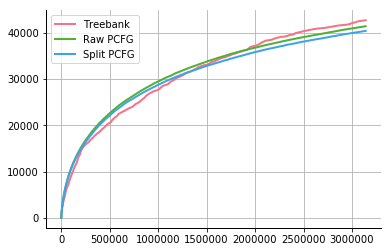

In [105]:
def create_vocab_curve(corpus, corpus_size=None):
    vocab_curve = []
    vocab_set = set()

    for sen in corpus[:corpus_size]:
        for w in sen.split():
            vocab_set.add(w)
            vocab_curve.append(len(vocab_set))
            
    return vocab_curve
        
    
treebank_curve = create_vocab_curve(treebank, corpus_size=None)
raw_pcfg_curve = create_vocab_curve(raw_pcfg, corpus_size=None)
split_pcfg_curve = create_vocab_curve(new_train, corpus_size=None)

min_len = min(len(treebank_curve), len(raw_pcfg_curve), len(split_pcfg_curve))

sns.color_palette("husl")

plt.plot(treebank_curve[:min_len], lw=2, label='Treebank')
plt.plot(raw_pcfg_curve[:min_len], lw=2, label='Raw PCFG')
plt.plot(split_pcfg_curve[:min_len], lw=2, label='Split PCFG')

plt.legend()

ax = plt.gca()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.setp(ax.spines.values(), color="black", lw=1)

ax.grid(True)

##### Sentence Length + Ngram Correlation

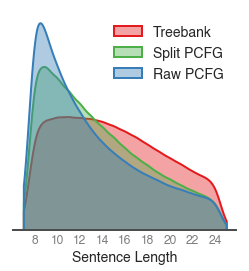

In [24]:
# sns.kdeplot([len(s.split()) for s in treebank[:200_000] if 25>len(s.split())>7], bw=.2)
# sns.kdeplot([len(s.split()) for s in new_train[:200_000] if 25>len(s.split())>7], color='orange', bw=.2)
# sns.kdeplot([len(s.split()) for s in raw_pcfg[:200_000] if 25>len(s.split())>7], color='green', bw=.2)

# sns.color_palette("Set2")
corpus_size = len(raw_pcfg)
cmap = 'Set1'

plt.figure(figsize=(4,4))

sns.kdeplot(
    np.array([len(s.split()) for s in treebank[:corpus_size] if 25>len(s.split())>7]), 
    bw_adjust=1.6,
    color=sns.color_palette(cmap, 3)[0],
    fill=True,
    linewidth=2,
    # edgecolor=None,
    clip=(7,25),
    label='Treebank',
    alpha=.4,
)
sns.kdeplot(
    np.array([len(s.split()) for s in new_train[:corpus_size] if 25>len(s.split())>7]), 
    bw_adjust=1.6,
    color=sns.color_palette(cmap, 3)[2],
    fill=True,
    linewidth=2,
    # edgecolor=None,
    clip=(7,25),
    label='Split PCFG',
    alpha=.4,
)
sns.kdeplot(
    np.array([len(s.split()) for s in raw_pcfg[:corpus_size] if 25>len(s.split())>7]), 
    bw_adjust=1.6,
    color=sns.color_palette(cmap, 3)[1],
    fill=True,
    linewidth=2,
    # edgecolor=None,
    clip=(7,25),
    label='Raw PCFG',
    alpha=.4,
)
plt.legend(edgecolor="white", fontsize=14)

plt.yticks([])
plt.ylabel('')

plt.xticks(range(8,25,2), range(8,25,2), fontsize=12, color="0.5")
plt.xlabel("Sentence Length", fontsize=14)
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,
    top=False,
    pad=-2,
)

ax = plt.gca()
plt.grid(False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.setp(ax.spines.values(), color="0.3", lw=2)

plt.savefig('petrov/figures/senlen_distribution.pdf')

plt.show()

0.9906896748639019

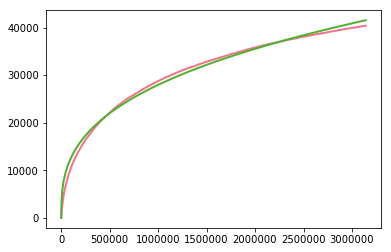

In [119]:
from scipy.optimize import curve_fit


def func(n, phi, tau):
    return phi*(n**tau)


curve = split_pcfg_curve
((phi, tau), _) = curve_fit(func, np.arange(min_len), curve[:min_len], bounds=([0,0],[1000,1]))

plt.plot(curve[:min_len], lw=2, label='Treebank')
plt.plot(func(np.arange(min_len), phi, tau), lw=2, label='Treebank')

r2_score(curve[:min_len], func(np.arange(min_len), phi, tau))

In [114]:
phi,tau

(236.99205804239668, 0.34711168255134633)

In [27]:
def word_count_corr(corpus, ngram=1):
    corpus = ['_'.join(sen.split()[idx:idx+ngram]) for sen in corpus[:] for idx in range(len(sen.split())-(ngram-1))]
    token_set1 = set(corpus)

    counts = Counter(corpus)
    total_counts = sum(counts.values())
    for w, c in counts.items():
        counts[w] = c
        
    return counts, total_counts


count_dict = {}

corpus_size = 225_000

for n in range(1,5):
    print(n)
    c1, tc1 = word_count_corr(new_train[:corpus_size], ngram=n)
    c2, tc2 = word_count_corr(treebank[:corpus_size], ngram=n)
    c3, tc3 = word_count_corr(raw_pcfg[:corpus_size], ngram=n)
    c4, tc4 = word_count_corr(treebank[corpus_size:corpus_size*2], ngram=n)

    c2_counts = np.array(list(c2.values()))
    c1_ordered = np.array([c1[w] for w in c2.keys()])
    c3_ordered = np.array([c3[w] for w in c2.keys()])
    c4_ordered = np.array([c4[w] for w in c2.keys()])
    
    count_dict[n] = (c2_counts, c1_ordered, c3_ordered, c4_ordered)

1
2
3
4


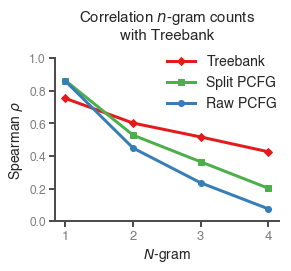

In [45]:
from scipy.stats import kendalltau

# split_corr = []
# raw_corr = []
# treebank_corr = []

# for n, (treebank_counts, split_counts, raw_counts, treebank2_counts) in count_dict.items():
#     split_corr.append(spearmanr(treebank_counts, split_counts)[0])
#     raw_corr.append(spearmanr(treebank_counts, raw_counts)[0])
#     treebank_corr.append(spearmanr(treebank_counts, treebank2_counts)[0])

plt.figure(figsize=(4,3))

ax = plt.gca()
cmap = "Set1"

plt.plot(treebank_corr, 'D-', lw=3, label="Treebank", color=sns.color_palette(cmap, 3)[0])
plt.plot(split_corr, 's-', lw=3, label="Split PCFG", color=sns.color_palette(cmap, 3)[2])
plt.plot(raw_corr, 'o-', lw=3, label="Raw PCFG", color=sns.color_palette(cmap, 3)[1])

plt.ylim(0,1)
plt.yticks(np.linspace(0,1,6), fontsize=12, color="0.5")
plt.xticks(range(4), range(1,5), fontsize=13, color="0.5")
plt.ylabel(r"Spearman $\rho$", fontsize=14)
plt.xlabel("$N$-gram", fontsize=14)
plt.tick_params(
    axis='both',          
    which='both',      
    bottom=True,      
    top=False,
    left=True,
    width=2,
    color='0.3',
)
# plt.grid(True, linestyle='dotted', color='0.8')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.setp(ax.spines.values(), color="0.3", lw=2)
ax.grid(False)
legend = plt.legend(edgecolor="white", fontsize=14, loc='upper right', bbox_to_anchor=(1.05,1.1))
# for idx, text in enumerate(legend.get_texts()):
#     text.set_color(sns.color_palette(cmap, 3)[idx])

# plt.text(3.1, treebank_corr[-1], 'test')

plt.title("Correlation $n$-gram counts\nwith Treebank", pad=20, fontsize=15)
plt.savefig('petrov/figures/ngram_correlation.pdf', bbox_inches="tight")
plt.show()

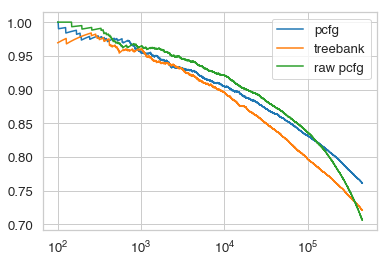

In [19]:
def calc_singleton_curve(countdict):
    singleton_proportion = []
    bigrams_seen = set()
    bigrams_seen_twice = set()

    bigrams = random.choices(list(countdict.keys()), k=450_000, weights=list(countdict.values()))

    for bigram in bigrams:
        if bigram in bigrams_seen:
            bigrams_seen_twice.add(bigram)
        else:
            bigrams_seen.add(bigram)

        singleton_proportion.append((len(bigrams_seen) - len(bigrams_seen_twice))/len(bigrams_seen))

    return singleton_proportion


singleton_proportion1 = calc_singleton_curve(c1)
singleton_proportion2 = calc_singleton_curve(c2)
singleton_proportion3 = calc_singleton_curve(c3)

plt.plot(range(100,len(singleton_proportion1)), singleton_proportion1[100:], label='pcfg')
plt.plot(range(100,len(singleton_proportion2)), singleton_proportion2[100:], label='treebank')
plt.plot(range(100,len(singleton_proportion3)), singleton_proportion3[100:], label='raw pcfg')

plt.xscale('log')
plt.legend()

<ipython-input-22-9fd6a64d32a6>:4: RuntimeWarning: divide by zero encountered in log
  np.log(c1_ordered),
<ipython-input-22-9fd6a64d32a6>:12: RuntimeWarning: divide by zero encountered in log
  print(spearmanr(np.log(c2_counts), np.log(c1_ordered)))


SpearmanrResult(correlation=0.5279533950047846, pvalue=0.0)


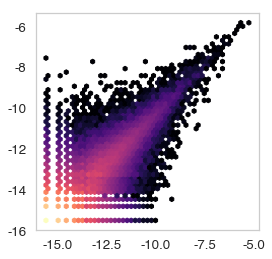

<ipython-input-22-9fd6a64d32a6>:18: RuntimeWarning: divide by zero encountered in log
  np.log(c3_ordered),
<ipython-input-22-9fd6a64d32a6>:25: RuntimeWarning: divide by zero encountered in log
  spearmanr(np.log(c2_counts), np.log(c3_ordered))


SpearmanrResult(correlation=0.39687944175231765, pvalue=0.0)

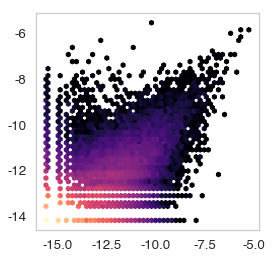

In [22]:
plt.figure(figsize=(4,4))
plt.hexbin(
    np.log(c2_counts), 
    np.log(c1_ordered),
    gridsize=50, 
    mincnt=1,
    cmap='magma',
    bins='log',
)
plt.grid(False)

print(spearmanr(np.log(c2_counts), np.log(c1_ordered)))
plt.show()

plt.figure(figsize=(4,4))
plt.hexbin(
    np.log(c2_counts), 
    np.log(c3_ordered),
    gridsize=50, 
    mincnt=1,
    cmap='magma',
    bins='log',
)
plt.grid(False)
spearmanr(np.log(c2_counts), np.log(c3_ordered))

SpearmanrResult(correlation=0.8699446331218672, pvalue=0.0)


<ipython-input-24-9fd6a64d32a6>:4: RuntimeWarning: divide by zero encountered in log
  np.log(c1_ordered),
<ipython-input-24-9fd6a64d32a6>:12: RuntimeWarning: divide by zero encountered in log
  print(spearmanr(np.log(c2_counts), np.log(c1_ordered)))


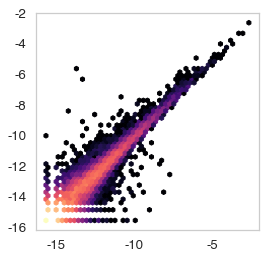

<ipython-input-24-9fd6a64d32a6>:18: RuntimeWarning: divide by zero encountered in log
  np.log(c3_ordered),
<ipython-input-24-9fd6a64d32a6>:25: RuntimeWarning: divide by zero encountered in log
  spearmanr(np.log(c2_counts), np.log(c3_ordered))


SpearmanrResult(correlation=0.8165164046595387, pvalue=0.0)

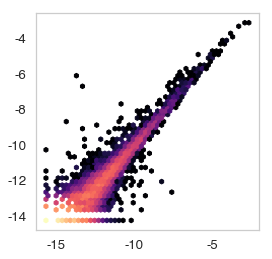

In [24]:
plt.figure(figsize=(4,4))
plt.hexbin(
    np.log(c2_counts), 
    np.log(c1_ordered),
    gridsize=50, 
    mincnt=1,
    cmap='magma',
    bins='log',
)
plt.grid(False)

print(spearmanr(np.log(c2_counts), np.log(c1_ordered)))
plt.show()

plt.figure(figsize=(4,4))
plt.hexbin(
    np.log(c2_counts), 
    np.log(c3_ordered),
    gridsize=50, 
    mincnt=1,
    cmap='magma',
    bins='log',
)
plt.grid(False)
spearmanr(np.log(c2_counts), np.log(c3_ordered))

<ipython-input-81-0084c0657501>:4: RuntimeWarning: divide by zero encountered in log
  np.log(c2_ordered),
<ipython-input-81-0084c0657501>:12: RuntimeWarning: divide by zero encountered in log
  spearmanr(np.log(c1_counts), np.log(c2_ordered))


SpearmanrResult(correlation=0.5169168499135023, pvalue=0.0)

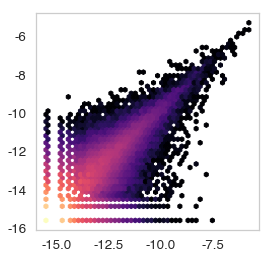

In [81]:
plt.figure(figsize=(4,4))
plt.hexbin(
    np.log(c1_counts), 
    np.log(c2_ordered),
    gridsize=50, 
    mincnt=1,
    cmap='magma',
    bins='log',
)
plt.grid(False)

spearmanr(np.log(c1_counts), np.log(c2_ordered))

SpearmanrResult(correlation=0.896724375013854, pvalue=0.0)

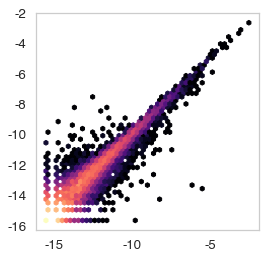

In [68]:
plt.figure(figsize=(4,4))
plt.hexbin(
    np.log(c1_counts), 
    np.log(c2_ordered),
    gridsize=50, 
    mincnt=1,
    cmap='magma',
    bins='log',
)
plt.grid(False)

spearmanr(np.log(c1_counts), np.log(c2_ordered))

##### Grammar Statistics

In [601]:
grammar_file = f"petrov/500k_5SM/subsets/1.0_petrov_words_all_leaves.txt"

with open(grammar_file) as f:
    raw_grammar = f.read()
grammar = nltk_PCFG.fromstring(raw_grammar)

In [607]:
all_tokens = [x for x in grammar._rhs_index.keys() if isinstance(x, str)]
len(all_tokens)

54497

In [142]:
num_binary = 0
num_unary = 0
num_terminal = 0

for prod in grammar.productions():
    if isinstance(prod.rhs()[0], str):
        num_terminal += 1
    elif len(prod.rhs()) == 1:
        num_unary += 1
    else:
        assert len(prod.rhs()) == 2
        num_binary += 1
        
num_binary, num_unary, num_terminal

(271919, 13303, 2227843)

In [233]:
preterminals = set()
nonterminals = set()

for nt, prods in grammar._lhs_index.items():
    if isinstance(prods[0].rhs()[0], str):
        preterminals.add(nt)
        continue
    
    for prod in prods:
        if len(prod.rhs()) == 1:
            nonterminals.add(nt)
            
            
preterminal_nts = set(prod.symbol().split('_')[0] for prod in preterminals)

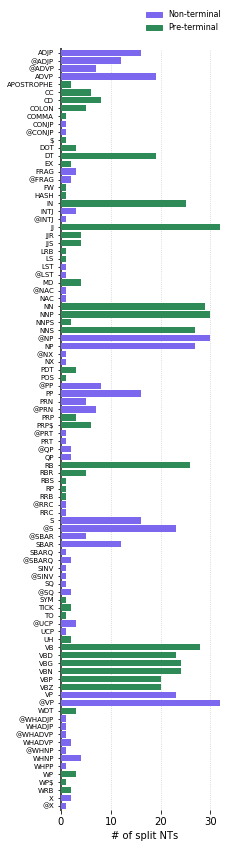

In [259]:
import matplotlib.patches as mpatches

NTs = grammar._lhs_index.keys()
orig_NTs = set(nt.symbol().split('_')[0] for nt in NTs)

nt_counter = Counter([nt.symbol().split('_')[0] for nt in NTs])

len(NTs), len(orig_NTs)


nt_labels, counts = zip(*sorted(nt_counter.items(), reverse=True, key=lambda x: x[0].replace("AT","")))
plt.figure(figsize=(3,14))

plt.gca().xaxis.grid(True, zorder=0, linestyle='dotted', color='0.8')

pal = sns.color_palette("Blues", max(counts)+1+15)[15:]#[::-1]
colors = [pal[c] for c in counts]


colors = ['seagreen' if nt in preterminal_nts else 'mediumslateblue' for nt in nt_labels]
nt_labels = [nt.replace("AT","@").replace("DOLLAR","$") for nt in nt_labels]

plt.barh(range(len(counts)), counts, color=colors, zorder=10)
plt.yticks(range(len(counts)), nt_labels, fontsize=7)
plt.ylim(-0.5,len(counts)-.5)

nt_patch = mpatches.Patch(color='mediumslateblue', label='Non-terminal')
pt_patch = mpatches.Patch(color='seagreen', label='Pre-terminal')

plt.legend(handles=[nt_patch, pt_patch], bbox_to_anchor=(1.0,1.06), fontsize=8, edgecolor='white')

ax = plt.gca()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.setp(ax.spines.values(), color="0.3", lw=2)

plt.xlabel("# of split NTs")

plt.savefig('petrov/figures/num_of_split_nts.pdf', bbox_inches="tight")

plt.show()

#### PCFG LRI

In [2]:
def create_prod2prob_dict(grammar, store_as_str: bool = False) -> Dict[Production, float]:
    prod2prob = defaultdict(float)

    for lhs, prods in tqdm_notebook(grammar._lhs_index.items()):
        for prod in prods:
            cfg_prod = Production(lhs, prod.rhs())

            if store_as_str:
                cfg_prod = str(cfg_prod)

            prod2prob[cfg_prod] = prod.prob()
            
    return prod2prob


ratio = 1.0
grammar_file = f"petrov/500k_5SM/subsets/{ratio}_petrov_words_all_leaves.txt"

with open(grammar_file) as f:
    raw_grammar = f.read()
grammar = nltk_PCFG.fromstring(raw_grammar)

prod2prob = create_prod2prob_dict(grammar)

grammar._lhs_index_set = {}

for lhs, prods in tqdm_notebook(grammar._lhs_index.items()):
    grammar._lhs_index_set[lhs] = set(prods)
    

grammar._rhs_index_set = {}

for rhs, prods in tqdm_notebook(grammar._rhs_index.items()):
    grammar._rhs_index_set[rhs] = set(prods)

<ipython-input-2-f10b8b9c4679>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for lhs, prods in tqdm_notebook(grammar._lhs_index.items()):


  0%|          | 0/718 [00:00<?, ?it/s]

<ipython-input-2-f10b8b9c4679>:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for lhs, prods in tqdm_notebook(grammar._lhs_index.items()):


  0%|          | 0/718 [00:00<?, ?it/s]

<ipython-input-2-f10b8b9c4679>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for rhs, prods in tqdm_notebook(grammar._rhs_index.items()):


  0%|          | 0/55209 [00:00<?, ?it/s]

##### P_L + Q_L

In [3]:
nonterminals = list(grammar._lhs_index.keys())
nt2idx = {nt: idx for idx, nt in enumerate(nonterminals)}

p_L = np.zeros((len(nt2idx), len(nt2idx)))

for nt_i, i in tqdm_notebook(nt2idx.items()):
    for nt_j, j in nt2idx.items():
        prob = 0.
        
        nt_i_prods = grammar._lhs_index_set.get(nt_i, set())
        nt_j_prods = grammar._rhs_index_set.get(nt_j, set())

        for prod in nt_i_prods & nt_j_prods:
            p_L[i,j] += prod.prob()
        
Q_L = (p_L @ np.linalg.inv(np.eye(p_L.shape[0]) - p_L))

<ipython-input-3-e4b49bef1634>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for nt_i, i in tqdm_notebook(nt2idx.items()):


  0%|          | 0/718 [00:00<?, ?it/s]

##### P_W + Q_W

In [4]:
terminals = [rhs for rhs in grammar._rhs_index.keys() if isinstance(rhs, str)]
vocab_size = len(terminals)

p_W = np.zeros((len(nt2idx), vocab_size))

for w_idx, w in enumerate(tqdm_notebook(terminals)):
    for prod in grammar._rhs_index[w]:
        lhs_idx = nt2idx[prod.lhs()]
        
        p_W[lhs_idx, w_idx] += prod.prob()

# nt, w_idx -> Q(NT => w)
Q_W = (np.eye(Q_L.shape[0]) + Q_L) @ p_W

<ipython-input-4-9751c47379db>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for w_idx, w in enumerate(tqdm_notebook(terminals)):


  0%|          | 0/54497 [00:00<?, ?it/s]

##### Q_L2

In [5]:
nonterminal_pairs = defaultdict(list)

for prod in tqdm_notebook(grammar.productions()):
    if len(prod.rhs()) == 2 and not isinstance(prod.rhs(), str):
        G1, G2 = prod.rhs()
        lhs, prob = nt2idx[prod.lhs()], prod.prob()
        nonterminal_pairs[G1.symbol(), G2.symbol()].append((lhs, prob))
        
preterminals = set()

for lhs, prods in grammar._lhs_index.items():
    if isinstance(prods[0].rhs()[0], str):
        preterminals.add(lhs.symbol())

<ipython-input-5-144f8a04d3ce>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for prod in tqdm_notebook(grammar.productions()):


  0%|          | 0/2513065 [00:00<?, ?it/s]

In [6]:
Q_L2 = {}

symbol2idx = {lhs.symbol(): idx for lhs, idx in nt2idx.items()}

for H, H_i in tqdm_notebook(symbol2idx.items()):
    if H in preterminals:
        continue

    Q_L2[H_i] = {}

    for (G1, G2), pair_lhs in nonterminal_pairs.items():
        prod_H_G1_G2 = f"{H} -> {G1} {G2}"
        G1_i = symbol2idx[G1]
        G2_i = symbol2idx[G2]
        
        prob = prod2prob.get(prod_H_G1_G2, 0.0)
        
        for A, prod_prob in pair_lhs:
            prob += Q_L[H_i, A] * prod_prob
            
        if prob != 0.:
            Q_L2[H_i][G1_i, G2_i] = prob

<ipython-input-6-c4ae2e679c7a>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for H, H_i in tqdm_notebook(symbol2idx.items()):


  0%|          | 0/718 [00:00<?, ?it/s]

##### Recursion

In [13]:
# %%prun

def get_inside_prob(nt, i, j):
    return 1/(j-i)

sen = [0] * 15

preterminal_ids = set(symbol2idx[x] for x in preterminals)
idx2symbol = list(symbol2idx.keys())

# nt, i, j -> p
prefix_prob_arr = np.zeros((len(nt2idx), len(sen)+1, len(sen)+1))
prefix_probs_computed = set()

trace = []

def calc_prefix_prob(nt, i, k):
    trace.append((nt,idx2symbol[nt],i,k))    
    
    if i == (k-1):
        return Q_W[nt, sen[i]]
    
    total_prob = 0.
    
    # check for preterminals
    for (G1, G2), ql2_prob in Q_L2.get(nt, {}).items():
        if ql2_prob < 1e-4:
            continue

        prob = 0.

        for j in range(1, k-i):
            inside_prob = get_inside_prob(G1, i, i+j)
            
            if (G2, i+j, k) in prefix_probs_computed:
                prefix_prob = prefix_prob_arr[G2, i+j, k]
            elif G2 in preterminal_ids and (k-(i+j)) > 1:
                prefix_prob = 0.
            elif Q_W[G2, sen[i+j]] == 0.:
                prefix_prob = 0.
            else:
                prefix_prob = calc_prefix_prob(G2, i+j, k)
            
            prob += inside_prob * prefix_prob
        
        total_prob += ql2_prob * prob

    prefix_prob_arr[nt, i, k] = total_prob
    # prefix_probs_computed.add((nt, i, k))
    
    return total_prob


import time
probs = []
times2 = []
prev_time = time.time()
for i in tqdm_notebook(range(1,10)):
    prob = calc_prefix_prob(symbol2idx['S_0'], 0, i)
    probs.append(probs)
    times2.append(time.time()-prev_time)
    prev_time = time.time()

<ipython-input-13-ac4278d3201b>:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(1,10)):


  0%|          | 0/9 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plt.plot(range(1,10), times)
plt.plot(range(1,10), times2)

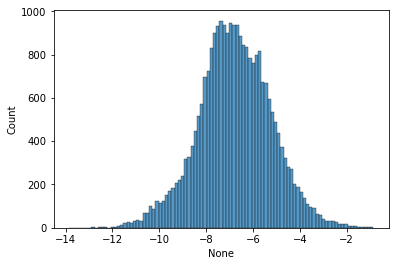

In [199]:
sns.histplot(np.log10(np.array(list(Q_L2[symbol2idx['S_0']].values()))))

In [187]:
prob, prefix_prob_arr.sum()

(0.0001611781919409359, 0.0019119267610964153)

In [119]:
len(prefix_prob_dict)
# prefix_prob_dict

23604

In [71]:
corpus = torch.load('1.0_10k_probing.pt')[0]


with open('corpora/eval_corpus_petrov.txt', 'w') as f:
    f.write('\n'.join(corpus).replace('<apostrophe>', "'").replace('<cross>', '†'))

#### EarleyX

In [16]:
ratio = 1.0

with open(f"petrov/500k_5SM/subsets/{ratio}_petrov_words_all_leaves.txt") as f:
    lines = f.read().split("\n")

In [17]:
"""
SQ->[MD NP RB ADVP VP] : 0.0526316
SQ->[MD NP VP .] : 0.157895
SQ->[VBP NP ADJP .] : 0.0526316
UCP->[NNP CC JJ] : 0.500000
UCP->[ADJP : NP] : 0.500000
NNP->[_Investcorp] : 0.00132363
NNP->[_Roger] : 0.000661813
NNP->[_Rosenblatt] : 0.00397088
NNP->[_New] : 0.00595632
"""

base_rules = defaultdict(float)

for line in tqdm_notebook(lines):
    line_items = line.split(' ')
    lhs = line_items[0]
    rhs = line_items[2:-1]
    if len(rhs) == 1 and rhs[0].startswith("'") and rhs[0].endswith("'"):
        rhs = f"_{rhs[0][1:-1]}"
    else:
        rhs = " ".join(rhs)
    prob = line_items[-1][1:-1]
    
    base_rules[f"{lhs}->[{rhs}]"] += float(prob)
    
earleyx_lines = [f"{key} : {prob:.12f}" for key, prob in base_rules.items()]
earleyx_lines.append("ROOT->[S_0] : 1.0")

with open(f'earleyx/petrov_grammars/{ratio}_petrov.grammar', 'w') as f:
    f.write('\n'.join(earleyx_lines))

<ipython-input-17-162fb749f004>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(lines):


  0%|          | 0/2513065 [00:00<?, ?it/s]

In [ ]:
grammar = nltk_PCFG.fromstring(open(f"petrov/500k_5SM/subsets/{ratio}_petrov_words_all_leaves.txt"))
grammar._lhs_prob_index = {}
for lhs in grammar._lhs_index.keys():
    lhs_probs = [prod.prob() for prod in grammar.productions(lhs=lhs)]
    grammar._lhs_prob_index[lhs] = lhs_probs

grammar._start = Nonterminal('S_0')
    
for x in generate_pcfg(grammar, depth=100):
    print(' '.join(x))
    break

In [ ]:
"""# 0
It 2.1209709433201844
saluted 7.490072126400525
and 0.22649807875018105
heard 4.599911025332004
the 2.345496951518461
magnificent 7.61807149147689
cripple 10.136379288386447
throughout 6.731661441739703
the 0.11949064186283928
ointment 9.710074599979642
. 0.002037726038203408
#! Done"""

In [301]:
# 0.5 -> 0.12
# 0.6 -> 0.57
# 0.7 -> 4.79

# REPEATS  

## Models

In [108]:
class ModelConfig(Config):
    encoder: str
    vocab_size: int
    nhid: int
    emb_dim: int
    is_binary: bool = True
    pad_idx: Optional[int] = None
    mask_idx: Optional[int] = None
    one_hot_embedding: bool = True
    num_layers: int = 1
    num_heads: int = 1
    learned_pos_embedding: bool = True
    non_linear_decoder: bool = False


class LanguageClassifier(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()

        self.vocab_size = config.vocab_size
        self.is_binary = config.is_binary
        self.pad_idx = config.pad_idx
        self.mask_idx = config.mask_idx
        self.one_hot_embedding = config.one_hot_embedding
        self.num_layers = config.num_layers
        self.num_heads = config.num_heads
        self.non_linear_decoder = config.non_linear_decoder
                
        if config.encoder == "lstm":
            self.emb_dim = config.emb_dim
            self.positional_embeddings = None
            self.nhid = config.nhid
            
            self.embeddings = nn.Embedding(self.vocab_size, self.emb_dim)
            self.encoder = nn.LSTM(self.emb_dim, self.nhid, self.num_layers, batch_first=True)
        elif config.encoder == "transformer":
            self.emb_dim = config.emb_dim * config.num_heads
            self.nhid = self.emb_dim

            self.embeddings = nn.Embedding(self.vocab_size, self.emb_dim)
            self.encoder = TransformerSentenceEncoder(
                padding_idx=self.pad_idx,
                vocab_size=self.vocab_size,
                num_encoder_layers=config.num_layers,
                embedding_dim=self.emb_dim,
                ffn_embedding_dim=config.nhid,
                num_attention_heads=config.num_heads,
                dropout=0.,
                attention_dropout=0.,
                activation_dropout=0.,
                learned_pos_embedding=config.learned_pos_embedding,
            )
            self.positional_embeddings = self.encoder.embed_positions  # copy?
            self.encoder.embed_positions = None
        else:
            raise ValueError("Encoder type must be 'lstm' or 'transformer'")

        if config.non_linear_decoder:
            # Based on BERT imp of fairseq
            non_linear_decoder = nn.Sequential(
                nn.Linear(self.nhid, self.nhid),
                nn.ReLU(),
                nn.LayerNorm(self.nhid),
            )
            self.lm_decoder = nn.Sequential(
                non_linear_decoder,
                nn.Linear(self.nhid, config.vocab_size)
            )
            self.binary_decoder = nn.Sequential(
                non_linear_decoder,
                nn.Linear(self.nhid, 1)
            )
        else:
            self.lm_decoder = nn.Linear(self.nhid, config.vocab_size)
            self.binary_decoder = nn.Linear(self.nhid, 1)
        
        self.init_weights()
        self.to(DEVICE)

    def init_weights(self):
        initrange = 0.1
        if self.one_hot_embedding:
            max_emb_size = max(self.vocab_size, self.emb_dim)
            self.embeddings.weight.data = torch.eye(max_emb_size)[:self.vocab_size, :self.emb_dim]
            self.embeddings.weight.requires_grad = False
        else:
            self.embeddings.weight.data.uniform_(-initrange, initrange)
            
        lm_decoder = self.lm_decoder[-1] if self.non_linear_decoder else self.lm_decoder
        binary_decoder = self.binary_decoder[-1] if self.non_linear_decoder else self.binary_decoder
        
        lm_decoder.bias.data.fill_(1 / (self.vocab_size))            
        lm_decoder.weight.data.uniform_(-initrange, initrange)
        binary_decoder.weight.data.uniform_(-initrange, initrange)

        if self.pad_idx is not None:
            self.embeddings.weight.data[self.pad_idx] = 0.

    def create_inputs_embeds(self, input_ids: Tensor, add_positional: bool = True) -> Tensor:
        if input_ids.ndim == 1:
            input_ids = input_ids.unsqueeze(0)

        if (self.positional_embeddings is not None) and add_positional:
            return self.embeddings(input_ids) + self.positional_embeddings(input_ids)
        else:
            return self.embeddings(input_ids)

    def forward(
        self,
        input_ids: Optional[Tensor] = None,
        inputs_embeds: Optional[Tensor] = None,
        input_lengths: Optional[Tensor] = None,
        mask_ids: Optional[List[List[int]]] = None,
        return_attention=False,
        return_hidden=False,
        return_hidden_only=False,
        pseudo_ll=False,
        **kwargs,
    ):
        if inputs_embeds is None and input_ids is None:
            raise ValueError("inputs_embeds or input_ids must be provided")
        if input_ids is not None and input_ids.ndim == 1:
            input_ids = input_ids.unsqueeze(0)
        if inputs_embeds is None:
            inputs_embeds = self.create_inputs_embeds(input_ids.to(DEVICE))
        if inputs_embeds.ndim == 2:
            inputs_embeds = inputs_embeds.unsqueeze(0)

        inputs_embeds = inputs_embeds.to(DEVICE)

        if isinstance(self.encoder, nn.LSTM):
            if input_lengths is not None:
                inputs_embeds = pack_padded_sequence(
                    inputs_embeds, input_lengths, batch_first=True, enforce_sorted=False
                )

            hidden, _ = self.encoder(inputs_embeds)

            if isinstance(hidden, PackedSequence):
                hidden, _ = pad_packed_sequence(hidden, batch_first=True)
        elif pseudo_ll:
            assert input_ids is not None
            assert self.mask_idx is not None
            hidden = torch.zeros_like(inputs_embeds, device=DEVICE)
            
            for idx in range(inputs_embeds.shape[1]):
                masked_input = input_ids.clone()
                masked_input[:, idx] = self.mask_idx
                masked_embeds = self.create_inputs_embeds(masked_input.to(DEVICE))
                output = self.encoder(
                    masked_input,
                    token_embeddings=masked_embeds,
                    last_state_only=True,
                    attn_mask=None,
                )
                hidden[:, idx] = output[0][0].transpose(0, 1)[:, idx]
        else:
            attn_mask = None  # todo: implement attn_mask to allow for causal attention (gpt-style)
            token_proxy = (
                torch.zeros(inputs_embeds.shape[:-1])
                if input_ids is None
                else input_ids
            )
            output = self.encoder(
                token_proxy,
                token_embeddings=inputs_embeds,
                last_state_only=True,
                attn_mask=attn_mask,
            )
            hidden = output[0][0].transpose(0, 1)  # T x B x D -> B x T x D
            
            if mask_ids is not None:
                hidden = torch.cat(
                    [
                        hidden[idx, mask_idx]
                        for idx, mask_idx in enumerate(mask_ids)
                    ]
                )

        if return_hidden_only:
            return hidden

        if self.is_binary:
            if isinstance(self.encoder, TransformerSentenceEncoder):
                final_hidden = hidden[:, 0, :]
            elif input_lengths is None:
                final_hidden = hidden[:, -1, :]
            else:
                batch_size = hidden.shape[0]
                final_hidden = hidden[range(batch_size), input_lengths - 1]

            predictions = self.binary_decoder(final_hidden)
        else:
            predictions = self.lm_decoder(hidden)

            if mask_ids is None and input_lengths is not None:
                predictions = unpad_sequence(predictions, lengths=input_lengths)

        predictions = predictions.squeeze(1)

        if return_attention:
            print("Attention maps currently not supported!")

        if return_hidden:
            return predictions, hidden

        return predictions

    @property
    def num_parameters(self):
        return sum(torch.prod(torch.tensor(x.shape)) for x in self.parameters())

## Evaluation

In [303]:
def pos_prob_mass(preds, tree, tokenizer, model, pos_to_words):
    pos_seq = [x for x in tree_to_pos(tree, merge=False)]

    prob_masses = []

    for i in range(int(tokenizer.config.add_cls), len(pos_seq)):            
        word_ids = [
            tokenizer.token2idx[word] 
            for word in pos_to_words[pos_seq[i]] 
            if word in tokenizer.token2idx
        ]
        sum_prob = torch.sum(get_word_prob(model, tokenizer, i, word_ids, preds)).item()

        main_pos = pos_seq[i].split('_')[0]
        word_ids = [
            tokenizer.token2idx[word] 
            for word in pos_to_words[main_pos] 
            if word in tokenizer.token2idx
        ]
        sum_prob_merged = torch.sum(get_word_prob(model, tokenizer, i, word_ids, preds)).item()

        prob_masses.append((pos_seq[i], main_pos, sum_prob, sum_prob_merged))

    return prob_masses


def get_word_prob(model, tokenizer, idx, word_ids: List[int], preds):
    if isinstance(model.encoder, nn.LSTM):
        # -1 for auto-regressive nature
        return preds[idx-1, word_ids]
    elif tokenizer.config.add_cls:
        # +1 to account for [CLS]
        return preds[idx+1, word_ids]
    else:
        return preds[idx, word_ids]


def pos_performance(language, corpus: List[str], model):
    pos_to_words = defaultdict(set)
    for prod in language.grammar.productions():
        if isinstance(prod.rhs()[0], str):
            word = prod.rhs()[0]
            pos = prod.lhs().symbol()
            main_pos = pos.split('_')[0]

            pos_to_words[pos].add(word)
            pos_to_words[main_pos].add(word)

    pos_probs = defaultdict(list)
    main_pos_probs = defaultdict(list)
            
    sen_idx = 0

    batch_size = int(1e9 / model.num_parameters)
    tokenized_corpus = language.tokenize_corpus(corpus)
    padded_corpus = pad_sequence(tokenized_corpus, batch_first=True, padding_value=language.tokenizer.pad_idx)
    
    for batch_input in padded_corpus.split(batch_size):
        with torch.no_grad():
            batch_preds = model(batch_input, pseudo_ll=True).softmax(-1)

        for preds in batch_preds:
            tree = language.tree_corpus[corpus[sen_idx]]
        
            prob_mass = pos_prob_mass(preds, tree, language.tokenizer, model, pos_to_words)

            for pos, main_pos, pos_prob, main_pos_prob in prob_mass:
                pos_probs[pos].append(pos_prob)
                main_pos_probs[main_pos].append(main_pos_prob)
                
            sen_idx += 1
        
    avg_main_pos_probs = {pos: np.mean(probs) for pos, probs in main_pos_probs.items()}

    return avg_main_pos_probs

### Edge Probe

In [50]:
def tree_to_spanlabels(tree, merge_pos=False):
    """Returns the spans of all subtrees and their labels"""
    sen_len = len(tree.leaves())
    treeposition_to_span = defaultdict(list)
    treeposition_to_span[()] = [(0, sen_len - 1)]

    for i in range(sen_len):
        for j in range(i + 2, sen_len):
            treeposition = tree.treeposition_spanning_leaves(i, j)
            span = (
                i,
                j - 1,
            )  # minus 1 because in self-attention span ends are inclusive
            treeposition_to_span[treeposition].append(span)

    for treeposition, span in treeposition_to_span.items():
        treeposition_to_span[treeposition] = max(span, key=lambda x: x[1] - x[0])

    span_ids = torch.zeros(len(treeposition_to_span), 2, device=DEVICE).long()
    labels = []

    for idx, (treeposition, span) in enumerate(treeposition_to_span.items()):
        subtree = tree[treeposition]
        start, end = treeposition_to_span[treeposition]

        span_ids[idx, 0] = start
        span_ids[idx, 1] = end

        label = subtree.label()
        if merge_pos:
            label = label.split("_")[0]

        labels.append(label)

    return span_ids, labels


def extract_span_labels(tree_corpus, merge_pos=False):
    all_span_ids = []
    all_labels = []

    for tree in tree_corpus:
        span_ids, labels = tree_to_spanlabels(tree, merge_pos=merge_pos)
        all_span_ids.append(span_ids)
        all_labels.append(labels)

    unique_labels = set([label for labels in all_labels for label in labels])
    label_vocab = {label: idx for idx, label in enumerate(unique_labels)}
    all_tokenized_labels = []

    for labels in all_labels:
        tokenized_labels = torch.zeros(len(labels), device=DEVICE).long()
        for idx, label in enumerate(labels):
            tokenized_labels[idx] = label_vocab[label]
        all_tokenized_labels.append(tokenized_labels)

    return all_span_ids, all_tokenized_labels, label_vocab


def create_states(tokenizer, tree_corpus, model, concat=True, skip_cls=False):
    all_sens = [
        tokenizer.tokenize(tree.leaves(), pos_tags=tree_to_pos(tree))
        for tree in tree_corpus
    ]
    lengths = [len(sen) for sen in all_sens]
    sen_tensor = pad_sequence(
        all_sens, padding_value=tokenizer.pad_idx, batch_first=True
    ).to(DEVICE)

    batch_size = int(1e9 / model.num_parameters)
    states = []

    for idx in range(0, len(all_sens), batch_size):
        batch = sen_tensor[idx : idx + batch_size]

        with torch.no_grad():
            all_hidden = model(batch, return_hidden_only=True)

        states.extend(
            [
                hidden[int(skip_cls) : length]
                for hidden, length in zip(all_hidden, lengths[idx : idx + batch_size])
            ]
        )

    if concat:
        return torch.concat(states)
    else:
        return states


class SpanProbe(nn.Module):
    def __init__(self, hidden_size, num_labels, hidden_dropout_prob=0.0, **kwargs):
        super().__init__()
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(hidden_dropout_prob)
        self.span_attention_extractor = SelfAttentiveSpanExtractor(hidden_size)
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, unpooled, spans):
        span_embeddings = self.span_attention_extractor(unpooled, spans)
        span_embeddings = span_embeddings.view(-1, self.hidden_size)
        span_embeddings = self.dropout(span_embeddings)
        logits = self.classifier(span_embeddings)
        return logits


class ProbeConfig(Config):
    lr: float = 1e-2
    batch_size: int = 48
    epochs: int = 10
    verbose: bool = True
    num_items: Optional[int] = None


def train_probe(train_data, dev_data, hidden_size, label_vocab, config):
    train_states, train_span_ids, train_labels = train_data
    dev_states, dev_span_ids, dev_labels = dev_data
    train_size = len(train_states)

    span_probe = SpanProbe(hidden_size, len(label_vocab), hidden_dropout_prob=0.0).to(
        DEVICE
    )

    optimizer = optim.AdamW(span_probe.parameters(), lr=config.lr)
    loss_function = nn.CrossEntropyLoss()

    loss_curve = []
    train_accs = []
    dev_accs = []

    best_probe = None
    best_dev_f1 = 0.0

    try:
        for epoch in range(config.epochs):
            random_ids = np.array(random.sample(range(train_size), k=train_size))

            batch_iterator = [
                [
                    (
                        train_states[batch_idx],
                        train_span_ids[batch_idx],
                        train_labels[batch_idx],
                    )
                    for batch_idx in batch_ids
                ]
                for batch_ids in np.array_split(
                    random_ids, (train_size // config.batch_size - 1)
                )
            ]

            for batch in batch_iterator:
                loss = torch.tensor(0.0, device=DEVICE)

                for batch_states, batch_span_ids, batch_labels in batch:
                    pred = span_probe(batch_states.unsqueeze(0), batch_span_ids)
                    loss += loss_function(pred, batch_labels)

                loss.backward()
                torch.nn.utils.clip_grad_norm_(span_probe.parameters(), 0.25)
                optimizer.step()

                loss_curve.append(loss.detach().item())

            train_f1, train_merged_f1 = eval_probe(
                span_probe,
                train_states,
                train_span_ids,
                train_labels,
                label_vocab,
            )
            dev_f1, dev_merged_f1 = eval_probe(
                span_probe,
                dev_states,
                dev_span_ids,
                dev_labels,
                label_vocab,
            )
            train_accs.append(train_f1)
            dev_accs.append(dev_f1)

            if dev_merged_f1 > best_dev_f1:
                best_dev_f1 = dev_merged_f1
                best_probe = deepcopy(span_probe)

            if best_dev_f1 > 0.999:
                break

            if config.verbose:
                print(
                    f"{train_f1:.3f} {dev_f1:.3f}\t\t--\t{train_merged_f1:.3f} {dev_merged_f1:.3f}"
                )
    except KeyboardInterrupt:
        print(f"Interrupting training at epoch {epoch}")
        pass

    return best_probe, loss_curve, train_accs, dev_accs


def eval_probe(probe, states, spans, labels, label_vocab):
    probe.eval()

    all_labels = []
    all_preds = []

    for state, span, label in zip(states, spans, labels):
        with torch.no_grad():
            pred = probe(state.unsqueeze(0), span)
            pred = pred.argmax(-1)

            all_labels.extend(label.tolist())
            all_preds.extend(pred.tolist())

    probe.train()

    f1 = f1_score(all_labels, all_preds, average="micro")
    conf = confusion_matrix(all_labels, all_preds)

    idx_to_label = list(label_vocab.keys())

    correct = 0
    wrong = 0

    for i in range(conf.shape[0]):
        for j in range(conf.shape[1]):
            label_i = idx_to_label[i]
            label_j = idx_to_label[j]

            if label_i.split("_")[0] == label_j.split("_")[0]:
                correct += conf[i, j]
            else:
                wrong += conf[i, j]

    return f1, correct / (correct + wrong)


def train_edge_probe(probe_config, model, language, tokenizer):
    tree_corpus = list(language.tree_corpus.values())
    if probe_config.num_items is not None:
        num_items = min(len(tree_corpus), probe_config.num_items)
        tree_corpus = random.sample(tree_corpus, num_items)

    all_span_ids, labels, span_label_vocab = extract_span_labels(
        tree_corpus, merge_pos=False
    )
    all_states = create_states(
        tokenizer,
        tree_corpus,
        model,
        concat=False,
        skip_cls=tokenizer.config.add_cls,
    )

    hidden_size = model.nhid

    corpus_size = len(all_states)
    train_split, dev_split, test_split = (
        int(0.8 * corpus_size),
        int(0.9 * corpus_size),
        corpus_size,
    )

    train_states = all_states[:train_split]
    dev_states = all_states[train_split:dev_split]
    test_states = all_states[dev_split:test_split]

    train_span_ids = all_span_ids[:train_split]
    dev_span_ids = all_span_ids[train_split:dev_split]
    test_span_ids = all_span_ids[dev_split:test_split]

    train_labels = labels[:train_split]
    dev_labels = labels[train_split:dev_split]
    test_labels = labels[dev_split:test_split]

    span_probe, loss_curve, train_accs, dev_accs = train_probe(
        (train_states, train_span_ids, train_labels),
        (dev_states, dev_span_ids, dev_labels),
        hidden_size,
        span_label_vocab,
        probe_config,
    )

    test_f1, test_merged_f1 = eval_probe(
        span_probe,
        test_states,
        test_span_ids,
        test_labels,
        span_label_vocab,
    )

    if probe_config.verbose:
        print("Edge probe test acc", test_merged_f1)

    return train_accs, dev_accs, test_merged_f1


### POS Probe

In [51]:
import random

import torch
from sklearn.linear_model import LogisticRegression


def create_pos_labels(tree_corpus):
    pos_labels = []

    for tree in tree_corpus:
        pos_labels.extend(tree_to_pos(tree))

    pos_vocab = {pos: idx for idx, pos in enumerate(set(pos_labels))}

    tokenized_pos_labels = [pos_vocab[pos] for pos in pos_labels]

    tokenized_pos_labels = torch.tensor(tokenized_pos_labels, device="cpu")

    return tokenized_pos_labels, pos_vocab


def train_pos_probe(probe_config, model, language, tokenizer):
    tree_corpus = list(language.tree_corpus.values())
    if probe_config.num_items is not None:
        num_items = min(len(tree_corpus), probe_config.num_items)
        tree_corpus = random.sample(tree_corpus, num_items)

    add_cls = tokenizer.config.add_cls
    labels, _ = create_pos_labels(tree_corpus)
    states = create_states(
        tokenizer, tree_corpus, model, concat=True, skip_cls=add_cls
    ).cpu()

    num_items = states.shape[0]
    train_ratio = 0.8
    split_idx = int(num_items * train_ratio)
    train_states = states[:split_idx]
    test_states = states[split_idx:]

    train_labels = labels[:split_idx]
    test_labels = labels[split_idx:]

    probe = LogisticRegression(verbose=0, solver="lbfgs")
    probe.fit(train_states, train_labels)

    test_preds = torch.tensor(probe.predict(test_states))
    test_acc = (test_preds == test_labels).float().mean().item()

    if probe_config.verbose:
        print("POS test acc", test_acc)

    return test_acc

## Experiment

In [306]:
class ExperimentConfig(Config):
    lr: float = 1e-2
    batch_size: int = 48
    epochs: int = 10
    verbose: bool = False
    early_stopping: Optional[int] = None
    continue_after_optimum: int = 0
    eval_every: int = 100
    warmup_duration: int = 0
    eval_dev_pos_performance: bool = False
    eval_test_pos_performance: bool = False

    
class ExitException(Exception):
    pass


class Experiment:
    def __init__(self, model: LanguageClassifier, config: ExperimentConfig) -> None:
        self.model = model
        self.config = config
        self.best_model = None

    def save(self, filename):
        torch.save(self, filename)
        print("Saved experiment to", filename)

    def train(self, languages: Union[Language, List[Language]]):
        if not isinstance(languages, list):
            languages = [languages]

        performances: Dict[int, Dict[str, Any]] = {}

        for lang_idx, language in enumerate(languages):
            performances[lang_idx] = self._train_language(language)

            self.model = self.best_model

        return performances

    def _train_language(self, language: Language) -> Dict[str, Any]:
        optimizer = optim.AdamW(self.model.parameters(), lr=self.config.lr)
        scheduler = optim.lr_scheduler.LinearLR(
            optimizer, 
            start_factor=0.1,
            end_factor=1.0,
            total_iters=self.config.warmup_duration,
        )
        if language.config.real_output:
            loss_function = nn.MSELoss()
        elif language.config.is_binary:
            loss_function = nn.BCEWithLogitsLoss()
        else:
            loss_function = nn.CrossEntropyLoss()

        performance_scores = {
            'train': [],
            'dev': [],
            'test': None,
        }
        
        if self.config.eval_dev_pos_performance:
            performance_scores['dev_pos'] = []

        best_dev_acc = -math.inf
        batches_seen = 0
        batches_seen_at_best_dev_acc = 0
        batch_optimum = 0

        if self.config.verbose:
            iterator = tqdm_notebook(range(self.config.epochs))
        else:
            iterator = range(self.config.epochs)

        try:
            for _epoch in iterator:
                random.shuffle(language.train_corpus)

                for batch in language.batchify(
                    corpus=language.train_corpus, batch_size=self.config.batch_size,
                ):
                    self._update_model(batch, optimizer, loss_function)

                    batches_seen += 1

                    if batches_seen % self.config.eval_every == 0:
                        best_dev_acc, batches_seen_at_best_dev_acc = self._eval(
                            batches_seen,
                            language,
                            performance_scores,
                            best_dev_acc,
                            batches_seen_at_best_dev_acc,
                        )

                        time_since_improvement = batches_seen - batches_seen_at_best_dev_acc
                        if (
                            self.config.early_stopping is not None
                            and time_since_improvement > self.config.early_stopping
                        ):
                            # Stop if no increases have been registered for past X epochs
                            if self.config.verbose:
                                print("Stopping early...")
                            raise ExitException
                        elif best_dev_acc == 1.0 and batch_optimum == 0:
                            if self.config.verbose:
                                print(f"Optimum reached at iteration {batches_seen}")
                            batch_optimum = batches_seen
                        
                        if best_dev_acc == 1.0 and ((batch_optimum + self.config.continue_after_optimum) == batches_seen):
                            raise ExitException
                        
                        scheduler.step()
                            
        except (KeyboardInterrupt, ExitException) as e:
            pass

        if len(language.test_corpus) > 0:
            performance_scores['test'] = self.eval_corpus(language, language.test_corpus, model=self.best_model)

            if self.config.eval_test_pos_performance and not language.config.is_binary:
                performance_scores['test_pos'] = pos_performance(language, language.test_corpus, self.model)

        return performance_scores

    def _update_model(self, batch, optimizer, loss_function) -> None:
        input_ids, targets, lengths, mask_ids = batch

        self.model.zero_grad()

        predictions = self.model(input_ids=input_ids, input_lengths=lengths, mask_ids=mask_ids)

        loss = loss_function(predictions, targets)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.25)

        optimizer.step()

    def _eval(
        self,
        batches_seen,
        language,
        performance_scores,
        best_dev_acc,
        batches_seen_at_best_dev_acc,
    ):
        train_acc = self.eval_corpus(language, language.train_corpus)
        performance_scores['train'].append(train_acc)

        dev_acc = self.eval_corpus(language, language.dev_corpus)
        performance_scores['dev'].append(dev_acc)

        if self.config.eval_dev_pos_performance:
            dev_pos_probs = pos_performance(language, language.dev_corpus, self.model)
            performance_scores['dev_pos'].append(dev_pos_probs)
        
        if dev_acc > best_dev_acc:
            self.best_model = deepcopy(self.model)
            best_dev_acc = dev_acc
            batches_seen_at_best_dev_acc = batches_seen
            if self.config.verbose:
                print(
                    f"New best at iteration {batches_seen}, dev acc: {dev_acc:.4f}, "
                    f"train acc: {train_acc:.4f}"
                )

        return best_dev_acc, batches_seen_at_best_dev_acc

    def eval_corpus(self, language, corpus, model=None):
        model = model or self.model

        model.eval()

        correct = 0

        batch_size = int(1e9 / model.num_parameters)
        
        for input_ids, targets, lengths, mask_ids in language.batchify(
            corpus=corpus, batch_size=batch_size
        ):
            with torch.no_grad():
                raw_predictions = model(input_ids=input_ids, input_lengths=lengths, mask_ids=mask_ids)

            if language.config.real_output:
                loss_function = nn.MSELoss()
                correct += -loss_function(raw_predictions, targets)
            elif self.model.is_binary:
                predictions = (raw_predictions > 0).to(int)
                correct += int(sum(predictions == targets))
            elif mask_ids is not None:
                ce_loss = F.cross_entropy(raw_predictions, targets)
                perplexity = -ce_loss.exp()

                correct += perplexity * len(mask_ids)
            else:
                split_predictions = torch.split(raw_predictions, tuple(lengths))
                targets = torch.split(targets, tuple(lengths))
                
                for raw_prediction, target, length in zip(split_predictions, targets, lengths):
                    ## [..] Old evaluation setup for dyck/palindromes in previous notebook
                    ce_loss = F.cross_entropy(raw_prediction, target)
                    perplexity = -ce_loss.exp()

                    correct += perplexity

        model.train()

        performance = (correct / len(corpus))

        if isinstance(performance, torch.Tensor):
            performance = performance.item()

        return performance

    def eval_corpora(
        self, 
        languages: List[Language], 
        model: Optional[LanguageClassifier] = None, 
        lang_names: Optional[List[str]] = None, 
        indomain_langs: Optional[List[int]] = None,
        xlabel: str = "Language",
        plot: bool = True,
    ):
        model = model or self.model
        
        accuracies = {}
        
        for lang_idx, language in enumerate(languages):
            accuracy = self.eval_corpus(language, language.corpus, model=model)
            
            lang_name = lang_names[lang_idx] if lang_names else repr(language)
            accuracies[lang_name] = accuracy
            
            if isinstance(accuracy, torch.Tensor):
                accuracy = accuracy.item()
            if self.config.verbose:
                print(f"{lang_name}\t{accuracy:.4f}")

        if plot:
            plot_eval_corpora(accuracies, indomain_langs or [], xlabel)
            
        return accuracies        


def plot_results(train_accs, dev_accs, test_acc, real_output=False):
    plt.plot(train_accs)
    plt.plot(dev_accs)
    if test_acc is not None:
        plt.axhline(test_acc, ls='--', lw=2)
    if not real_output:
        plt.ylim(0, 1)
    plt.title("Performance")
    plt.show()


def plot_eval_corpora(accuracies: Dict[str, float], indomain_langs: List[int], xlabel: str):
    id_color = "#40B0A6"
    ood_color = "#E1BE6A"

    colors = [id_color if idx in indomain_langs else ood_color for idx in range(len(accuracies))]

    plt.bar(accuracies.keys(), accuracies.values(), color=colors)
    plt.ylabel("Accuracy")
    plt.xlabel(xlabel)
    plt.ylim(-0.02, 1.01)

    legend_elements = [
        plt.Line2D([0], [0], color=id_color, lw=10, label="Trained on (ID)"),
        plt.Line2D([0], [0], lw=10, color=ood_color, label="OOD"),
    ]
    legend = plt.legend(
        handles=legend_elements, bbox_to_anchor=(1.03, 1), loc="upper left"
    )
    frame = legend.get_frame()
    frame.set_facecolor("w")
    frame.set_edgecolor("black")

    plt.show()


def train(model, language, config):
    experiment = Experiment(
        model,
        config,
    )

    return experiment, experiment.train(language)


def tune_and_train(model, language, config, num_samples=10, tune=False):
    if tune:
        scheduler = ASHAScheduler(
            metric="dev_acc",
            mode="max",
            max_t=config.epochs,
            grace_period=config.epochs//2,
            reduction_factor=2
        )

        reporter = JupyterNotebookReporter(
            True,
            metric_columns=["train_acc", "dev_acc", "training_iteration"]
        )

        result = ray.tune.run(
            train,
            resources_per_trial={"cpu": max(math.ceil(num_samples/8), 2), "gpu": 0},
            config=config,
            num_samples=num_samples,
            scheduler=scheduler,
            progress_reporter=reporter,
        )
    else:
#         for key, value in config.items():
#             if "tune.sample" in str(type(value)):
#                 config[key] = value.sample()

        return train(model, language, config)


## Setup

### Petrov

In [ ]:
from languages import *


test_scores = {}


ratio = 1/10; print(ratio)

grammar_file = f"petrov/500k_5SM/subsets/{ratio}_petrov_words_all_leaves.txt"
encoder = 'transformer'

tokenizer_config = TokenizerConfig(
    add_cls=(encoder == "transformer"),
    masked_lm=(encoder == "transformer"),
    unk_threshold=5,
)
tokenizer = Tokenizer(tokenizer_config)

config = PCFGConfig(
    is_binary=False,
    min_length=6,
    max_length=20,
    max_depth=100,
    corpus_size=10_000,
    grammar_file=grammar_file,
    start="S_0",
    masked_lm=(encoder == "transformer"),
    allow_duplicates=True,
    split_ratio=(.8,.1,.1),
    use_unk_pos_tags=True,
)
lm_language = PCFG(config, tokenizer)
# binary_language = lm_language.make_binary(swap_subtrees, clone=True)

# treebank_config = TreebankConfig(
#     file='100k_sample_books.txt',
#     max_length=20,
#     min_length=4,
#     max_depth=20,
#     corpus_size=10_000,
#     sample=True,
#     use_unk_pos_tags=False,
#     masked_lm=(encoder == "transformer"),
#     start='S',
# )
# lm_language = Treebank(treebank_config, tokenizer)

## LM PRETRAINING
model_config = ModelConfig(
    nhid = 25,
    num_layers = 2,
    vocab_size = len(tokenizer.idx2token),
    is_binary = False,
    encoder = encoder,
    num_heads = 3,
    one_hot_embedding = False,
    emb_dim = 25,
    learned_pos_embedding = True,
    pad_idx = tokenizer.pad_idx,
    mask_idx = tokenizer.mask_idx,
    non_linear_decoder = True,
)
model = LanguageClassifier(model_config)

experiment_config = ExperimentConfig(
    lr=1e-2,  #tune.loguniform(1e-4, 1e-1),   # <- for lstm 1e-2 seems optimal often
    batch_size=48,  # tune.choice([32, 48, 64]),
    epochs=50,
    verbose=True,
    continue_after_optimum=0,
    eval_every=100,
    warmup_duration=0,
    early_stopping=1000,
    eval_dev_pos_performance=False,
    eval_test_pos_performance=True,
)
experiment = Experiment(
    model,
    experiment_config,
)
performance = experiment.train(lm_language)
base_model = experiment.best_model
model = deepcopy(base_model)  # detach reference so base_model can be used later
plot_results(performance[0]['train'], performance[0]['dev'], performance[0]['test'], real_output=True)
print(performance[0]['test'])

## BINARY CLASSIFICATION
# model.is_binary = True
# experiment_config.epochs = 100
# experiment = Experiment(
#     model,
#     experiment_config,
# )
# performance = experiment.train(binary_language)
# # plot_results(*performance[0])
# plot_results(performance['train'], performance['dev'], performance['test'], real_output=True)

# print(performance[0][2])
# test_scores[ratio] = performance[0][2]

In [30]:
result = torch.load('transformer_0.5_100_4_4_0_30000.pt', map_location='cpu')
weights, config = result['model']

model_config = LanguageConfig(**config)

model = LanguageClassifier(model_config)
model.load_state_dict(weights)

model

LanguageClassifier(
  (embeddings): Embedding(3188, 400)
  (encoder): TransformerSentenceEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(3188, 400, padding_idx=1)
    (segment_embeddings): Embedding(2, 400)
    (embed_positions): None
    (layers): ModuleList(
      (0): TransformerSentenceEncoderLayer(
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=400, out_features=400, bias=True)
          (v_proj): Linear(in_features=400, out_features=400, bias=True)
          (q_proj): Linear(in_features=400, out_features=400, bias=True)
          (out_proj): Linear(in_features=400, out_features=400, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((400,), eps=1e-05, elementwise_affine=True)
        (fc1): Linear(in_features=400, out_features=100, bias=True)
        (fc2): Linear(in

In [142]:
all_prod = lm_language.grammar.productions()
nt_prod = [prod for prod in all_prod if len(prod.rhs()) > 1]
t_prod = [prod for prod in all_prod if len(prod.rhs()) == 1]

len(all_prod), len(nt_prod), len(t_prod)

(79629, 12, 79617)

In [148]:
performance[0]['test_pos']

{'VBD': 0.8499567038416862,
 'DT': 0.9878988190115952,
 'JJ': 0.6065286040670645,
 'NN': 0.7525327742549608,
 'IN': 0.9868328650492543,
 'CC': 0.9971530517339706,
 'DOT': 0.9994900481700897,
 'PRPDOLLAR': 0.9851728577372214}

KeyError: 'dev_pos'

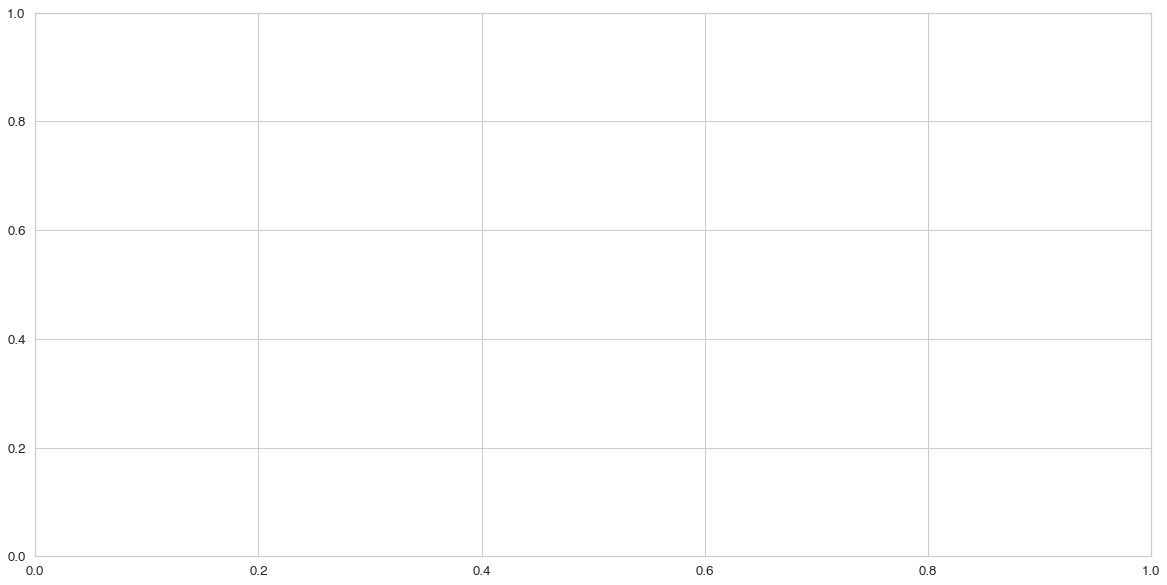

In [145]:
fig, ax = plt.subplots(figsize=(20,10))

dev_pos_performance = performance[0]['dev_pos'][:30]
pos_tags = dev_pos_performance[0].keys()

for pos in pos_tags:
    pos_curve = [
        np.mean([
            x[pos], 
            dev_pos_performance[max(0,i-1)][pos], 
            dev_pos_performance[min(i+1,len(dev_pos_performance)-1)][pos]
        ]) if i < (len(dev_pos_performance) - 1)
        else x[pos]
        for i, x in enumerate(dev_pos_performance)
    ]
    plt.plot(pos_curve, 'o-', lw=2, markersize=3)
#     plt.text(len(pos_curve)-.85, pos_curve[-1]-.004, pos, fontsize=8)

sorted_pos = list(zip(*sorted(dev_pos_performance[-1].items(), key=lambda x: -x[1])))[0]
for i, pos in enumerate(sorted_pos):
    plt.text(len(pos_curve)+.15, .95-(i/len(sorted_pos)), pos.replace("DOLLAR", "$"), fontsize=10, va='center')
    plt.plot([len(pos_curve)-.85, len(pos_curve)+.1], [dev_pos_performance[-1][pos], .95-(i/len(sorted_pos))], lw=1, color='0.7')
    
    
ax2=ax.twinx()
ax2.plot(performance[0]['dev'][:30], lw=3, color='b')
ax2.grid(False)

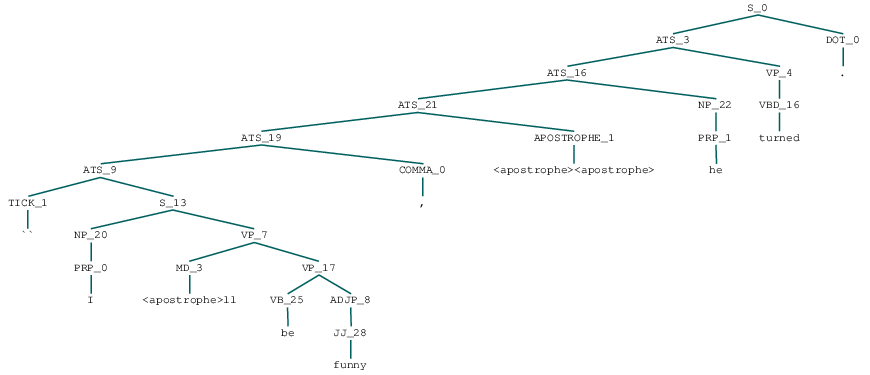

In [85]:
list(lm_language.tree_corpus.values())[0]

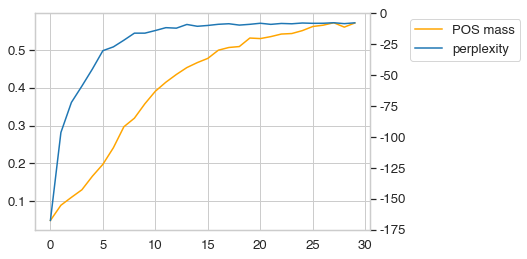

In [81]:
fig, ax = plt.subplots()

plt.plot([np.mean(list(dev_pos_performance[i].values())) for i in range(len(dev_pos_performance))], color='orange', label='POS mass')
plt.plot([], [], label='perplexity')
plt.legend(bbox_to_anchor=(1.1,1))

ax2=ax.twinx()
ax2.plot(performance[0]['dev'][:30], )
ax2.grid(False)

plt.show()

In [89]:
item_idx = 6

for idx in range(0, len((lm_language.test_corpus[item_idx].split()))):
    item = tokenizer.tokenize(lm_language.test_corpus[item_idx])

    orig_sym = item[idx+1].clone()
    item[idx+1] = tokenizer.mask_idx

    with torch.no_grad():
        distribution = base_model(item)[0, idx+1].log_softmax(-1)
        print(
            (lm_language.test_corpus[item_idx]).split()[idx], 
            f"{tokenizer.idx2token[distribution.argmax()].replace('<apostrophe>', '`')} ({math.exp(distribution.max())**-1:.2f})", 
            f"1 / {math.exp(distribution[orig_sym])**-1:.2f}", 
            sep='\t\t'
        )

John		He (3.55)		1 / 63.12
reached		looked (20.51)		1 / 102.23
the		the (2.61)		1 / 2.61
window		NN (3.76)		1 / 736.26
and		and (1.48)		1 / 1.48
stopped		I (5.73)		1 / 670.16
on		and (1.93)		1 / 472.51
none		her (8.72)		1 / 16955.04
of		of (3.66)		1 / 3.66
father		NNS (9.97)		1 / 15172.97
.		. (1.01)		1 / 1.01


#### Edge Probing

In [594]:
from transformers import PreTrainedModel


def tree_to_spanlabels(tree, merge_pos=False):
    """ Returns the spans of all subtrees and their labels """
    sen_len = len(tree.leaves())
    treeposition_to_span = defaultdict(list)
    treeposition_to_span[()] = [(0, sen_len-1)]

    for i in range(sen_len):
        for j in range(i+2, sen_len):
            treeposition = tree.treeposition_spanning_leaves(i, j)
            span = (i, j - 1) # minus 1 because in self-attention span ends are inclusive
            treeposition_to_span[treeposition].append(span)  

    for treeposition, span in treeposition_to_span.items():
        treeposition_to_span[treeposition] = max(span, key=lambda x: x[1] - x[0])

    nonterminal_treeposition = [
        treeposition
        for treeposition in tree.treepositions()
        if isinstance(tree[treeposition], nltk.Tree)
    ]

    span_ids = torch.zeros(len(treeposition_to_span), 2, device=DEVICE).long()
    labels = []

    for idx, (treeposition, span) in enumerate(treeposition_to_span.items()):
        subtree = tree[treeposition]
        start, end = treeposition_to_span[treeposition]

        span_ids[idx, 0] = start
        span_ids[idx, 1] = end

        label = subtree.label()
        if merge_pos:
            label = label.split("_")[0]
    
        labels.append(label)

    return span_ids, labels
    

def extract_span_labels(tree_corpus, merge_pos=False):
    all_span_ids = []
    all_labels = []
    
    for tree in tqdm_notebook(tree_corpus):
        span_ids, labels = tree_to_spanlabels(tree, merge_pos=merge_pos)
        all_span_ids.append(span_ids)
        all_labels.append(labels)
    
    unique_labels = set([label for labels in all_labels for label in labels])
    label_vocab = {
        label: idx
        for idx, label in enumerate(unique_labels)
    }
    all_tokenized_labels = []

    for labels in all_labels:
        tokenized_labels = torch.zeros(len(labels), device=DEVICE).long()
        for idx, label in enumerate(labels):
            tokenized_labels[idx] = label_vocab[label]
        all_tokenized_labels.append(tokenized_labels)
    
    return all_span_ids, all_tokenized_labels, label_vocab


def create_states(
    tokenizer, 
    tree_corpus, 
    model, 
    concat=True, 
    skip_cls=False, 
    num_items=None,
    verbose=False,
):
    if isinstance(model, PreTrainedModel):
        all_sens = [torch.tensor(tokenizer.convert_tokens_to_ids(tree.leaves())) for tree in tree_corpus]
        pad_idx = tokenizer.pad_token_id
        num_parameters = model.num_parameters()
    else:
        all_sens = [tokenizer.tokenize(tree.leaves(), pos_tags=tree_to_pos(tree)) for tree in tree_corpus]
        pad_idx = tokenizer.pad_idx
        num_parameters = model.num_parameters

    if num_items is not None:
        all_sens = random.sample(all_sens, num_items)
    lengths = [len(sen) for sen in all_sens]
    sen_tensor = pad_sequence(all_sens, padding_value=pad_idx, batch_first=True).to(DEVICE)

    batch_size = int(1e9 / num_parameters)
    states = []
    iterator = range(0, len(all_sens), batch_size)
    if verbose:
        iterator = tqdm_notebook(iterator)

    for idx in iterator:
        batch = sen_tensor[idx: idx + batch_size]

        with torch.no_grad():
            if isinstance(model, PreTrainedModel):
                all_hidden = model(batch, output_hidden_states=True).hidden_states[-1]
            else:
                all_hidden = model(batch, return_hidden_only=True)

        states.extend([
            hidden[int(skip_cls):length]
            for hidden, length in zip(all_hidden, lengths[idx: idx + batch_size])
        ])

    if concat:
        return torch.concat(states)
    else:
        return states


# add_cls = lm_language.config.add_cls
# trees = list(lm_language.tree_corpus.values())
# all_span_ids, all_tokenized_labels, span_label_vocab = extract_span_labels(tree_corpus, merge_pos=True)
# all_states = create_states(tokenizer, tree_corpus, model, concat=False, verbose=True)  # 11s, prun 13.45s

train f1	dev f1		--	merged f1	merged dev f1


<ipython-input-259-13872023dfde>:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(config.epochs)):


  0%|          | 0/20 [00:00<?, ?it/s]

0.829 0.824		--	0.829 0.824
0.833 0.823		--	0.833 0.823
0.847 0.841		--	0.847 0.841
0.842 0.835		--	0.842 0.835
0.846 0.843		--	0.846 0.843
0.852 0.845		--	0.852 0.845
0.852 0.844		--	0.852 0.844
0.844 0.831		--	0.844 0.831
0.851 0.846		--	0.851 0.846
0.851 0.842		--	0.851 0.842
0.850 0.839		--	0.850 0.839
0.845 0.837		--	0.845 0.837
0.853 0.847		--	0.853 0.847
0.854 0.843		--	0.854 0.843
0.851 0.840		--	0.851 0.840
0.853 0.844		--	0.853 0.844
Interrupting training at epoch 16
(0.8398539872706852, 0.8398539872706852)


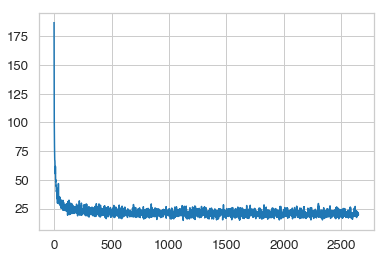

In [259]:
from sklearn.metrics import f1_score, confusion_matrix
from self_attentive_span_extractor import SelfAttentiveSpanExtractor


class SpanProbe(nn.Module):
    def __init__(self, hidden_size, num_labels, hidden_dropout_prob=0., **kwargs):
        super().__init__()
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(hidden_dropout_prob)
        self.span_attention_extractor = SelfAttentiveSpanExtractor(hidden_size)
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, unpooled, spans):
        span_embeddings = self.span_attention_extractor(unpooled, spans)
        span_embeddings = span_embeddings.view(-1, self.hidden_size)
        span_embeddings = self.dropout(span_embeddings)
        logits = self.classifier(span_embeddings)
        return logits

    
class ProbeConfig(Config):
    lr: float = 1e-2
    batch_size: int = 48
    epochs: int = 10
    verbose: bool = True
    num_items: Optional[int] = None
    weight_decay: float = 0.1
    

def train_probe(train_data, dev_data, hidden_size, label_vocab, config):
    train_states, train_span_ids, train_labels = train_data
    dev_states, dev_span_ids, dev_labels = dev_data
    train_size = len(train_states)
    
    
    span_probe = SpanProbe(hidden_size, len(span_label_vocab), hidden_dropout_prob=0.).to(DEVICE)

    optimizer = optim.AdamW(span_probe.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    loss_function = nn.CrossEntropyLoss()

    loss_curve = []
    train_accs = []
    dev_accs = []
    
    best_probe = None
    best_dev_f1 = 0.

    print(f"train f1\tdev f1\t\t--\tmerged f1\tmerged dev f1")
    
    try:
        for epoch in tqdm_notebook(range(config.epochs)):
            random_ids = np.array(random.sample(range(train_size), k=train_size))
            batch_size = 48

            batch_iterator = [
                [
                    (train_states[batch_idx], train_span_ids[batch_idx], train_labels[batch_idx])
                    for batch_idx in batch_ids
                ]
                for batch_ids 
                in np.array_split(random_ids, (train_size // config.batch_size - 1))
            ]

            for batch in batch_iterator:
                loss = 0.

                for batch_states, batch_span_ids, batch_labels in batch:
                    pred = span_probe(batch_states.unsqueeze(0), batch_span_ids)
                    loss += loss_function(pred, batch_labels)

                loss.backward()
                torch.nn.utils.clip_grad_norm_(span_probe.parameters(), 0.25)
                optimizer.step()

                loss_curve.append(loss.detach().item())

            train_f1, train_merged_f1 = eval_probe(
                span_probe, 
                train_states, 
                train_span_ids, 
                train_labels,
                label_vocab,
            )
            dev_f1, dev_merged_f1 = eval_probe(
                span_probe, 
                dev_states, 
                dev_span_ids, 
                dev_labels,
                label_vocab,
            )
            train_accs.append(train_f1)
            dev_accs.append(dev_f1)

            if dev_merged_f1 > best_dev_f1:
                best_dev_f1 = dev_merged_f1
                best_probe = deepcopy(span_probe)

            if config.verbose:
                print(f"{train_f1:.3f} {dev_f1:.3f}\t\t--\t{train_merged_f1:.3f} {dev_merged_f1:.3f}")
    except KeyboardInterrupt:
        print(f"Interrupting training at epoch {epoch}")
        pass

    return best_probe, loss_curve, train_accs, dev_accs


def eval_probe(probe, states, spans, labels, label_vocab):
    probe.eval()
    
    all_labels = []
    all_preds = []
    
    for state, span, label in zip(states, spans, labels):
        with torch.no_grad():
            pred = probe(state.unsqueeze(0), span)
            pred = pred.argmax(-1)
            
            all_labels.extend(label.tolist())
            all_preds.extend(pred.tolist())
    
    probe.train()
    
    f1 = f1_score(all_labels, all_preds, average="micro")
    conf = confusion_matrix(all_labels, all_preds)

    base_labels = set(label.split("_")[0] for label in label_vocab.keys())
    idx_to_label = list(label_vocab.keys())

    correct = 0
    wrong = 0

    for i in range(conf.shape[0]):
        for j in range(conf.shape[1]):
            label_i = idx_to_label[i]
            label_j = idx_to_label[j]

            if label_i.split("_")[0] == label_j.split("_")[0]:
                correct += conf[i,j]
            else:
                wrong += conf[i,j]
    
    return f1, correct / (correct+wrong)


def probe_loop(states, span_ids, labels, hidden_size, label_vocab, config):
    corpus_size = len(states)
    train_split, dev_split, test_split = int(0.8 * corpus_size), int(0.9 * corpus_size), corpus_size

    train_states = states[:train_split]
    dev_states = states[train_split:dev_split]
    test_states = states[dev_split:test_split]
    
    train_span_ids = span_ids[:train_split]
    dev_span_ids = span_ids[train_split:dev_split]
    test_span_ids = span_ids[dev_split:test_split]    
    
    train_labels = labels[:train_split]
    dev_labels = labels[train_split:dev_split]
    test_labels = labels[dev_split:test_split]

    span_probe, loss_curve, train_accs, dev_accs = train_probe(
        (train_states, train_span_ids, train_labels),
        (dev_states, dev_span_ids, dev_labels),
        hidden_size,
        label_vocab,
        config,
    )

    test_f1, test_merged_f1 = eval_probe(
        span_probe, 
        test_states, 
        test_span_ids, 
        test_labels,
        label_vocab,
    )
    
    if config.verbose:
        print((test_f1, test_merged_f1))
    
    return span_probe, loss_curve, train_accs, dev_accs, (test_f1, test_merged_f1)


lr = 10e-3
num_epochs = 20

hidden_size = model.nhid if isinstance(model, LanguageClassifier) else model.config.hidden_size

probe_config = ProbeConfig(
    lr=lr,
    epochs=num_epochs,
    verbose=True,
    batch_size=48,
)

span_probe, loss_curve, train_accs, dev_accs, test_merged_f1 = probe_loop(
    all_states, 
    all_span_ids, 
    all_tokenized_labels, 
    hidden_size, 
    span_label_vocab,
    probe_config,
)

plt.plot(loss_curve)
plt.show()

In [261]:
span_probe

SpanProbe(
  (dropout): Dropout(p=0.0, inplace=False)
  (span_attention_extractor): SelfAttentiveSpanExtractor(
    (_global_attention): TimeDistributed(
      (_module): Linear(in_features=256, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=256, out_features=43, bias=True)
)

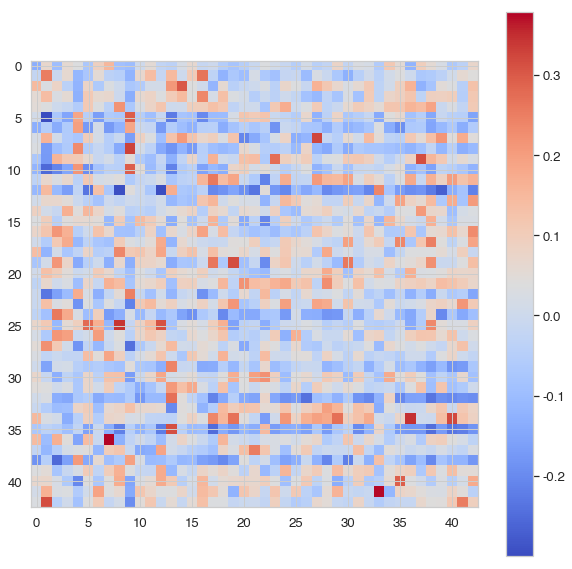

In [295]:
from sklearn.metrics.pairwise import cosine_similarity as cs

sims = cs(probe.coef_, span_probe.classifier.weight.data)

plt.figure(figsize=(10,10))
plt.imshow(sims, cmap='coolwarm')
plt.colorbar()

array([[ 1.0000001 ,  0.01432814,  0.20741022, ...,  0.10753817,
         0.16779749,  0.09932612],
       [ 0.01432814,  0.9999998 , -0.05594724, ..., -0.03105382,
         0.18979585,  0.1254406 ],
       [ 0.20741022, -0.05594724,  1.0000001 , ...,  0.21418208,
         0.07798927,  0.2559662 ],
       ...,
       [ 0.10753817, -0.03105382,  0.21418208, ...,  0.9999998 ,
         0.30415484,  0.31370622],
       [ 0.16779749,  0.18979585,  0.07798927, ...,  0.30415484,
         0.99999994,  0.18225816],
       [ 0.09932612,  0.1254406 ,  0.2559662 , ...,  0.31370622,
         0.18225816,  0.9999997 ]], dtype=float32)

In [433]:
sims = cs(probe.coef_, span_probe.classifier.weight.data)

for i,j in np.dstack(np.unravel_index(np.argsort(-sims.ravel()), (43, 43)))[0][:5]:
    edge_label = list(span_label_vocab.keys())[j].replace("AT","@")
    print(f"{list(pos_vocab.keys())[i]:<12}{edge_label:<12}{sims[i,j]:.2f}")
    
    
print("\nPOS similarity")
sims = cs(probe.coef_, probe.coef_)
printed = 0
for i,j in np.dstack(np.unravel_index(np.argsort(-sims.ravel()), (43, 43)))[0]:
    if i<j:
        i_label = list(pos_vocab.keys())[i].replace("DOLLAR", "$")
        j_label = list(pos_vocab.keys())[j].replace("DOLLAR", "$")
        print(f"{i_label:<12}{j_label:<12}{sims[i,j]:.2f}")
        printed += 1
    if printed > 5:
        break
    
print("\nEDGE similarity")
sims = cs(span_probe.classifier.weight.data, span_probe.classifier.weight.data)
printed = 0
for i,j in np.dstack(np.unravel_index(np.argsort(-sims.ravel()), (43, 43)))[0]:
    i_label = list(span_label_vocab.keys())[i].replace("AT", "@")
    j_label = list(span_label_vocab.keys())[j].replace("AT", "@")
    
    if i<j and not(i_label.endswith(j_label) or j_label.endswith(i_label)):
        print(f"{i_label:<12}{j_label:<12}{sims[i,j]:.2f}")
        printed += 1
    if printed > 5:
        break

UH          INTJ        0.38
JJR         ADJP        0.37
WRB         WHADVP      0.35
COMMA       @PRN        0.34
VB          VP          0.33

POS similarity
NNS         NN          0.55
VBD         VBN         0.43
NNP         NN          0.38
JJ          VBN         0.37
JJ          NN          0.36
RBS         JJS         0.35

EDGE similarity
NAC         @CONJP      0.47
SQ          SINV        0.45
@INTJ       @CONJP      0.43
NX          @CONJP      0.42
SQ          @SINV       0.42
NAC         PRT         0.41


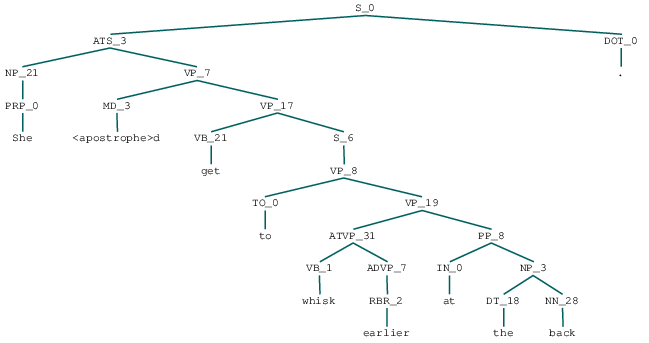

In [338]:
tree_corpus[0]

#### Pos Probing

In [595]:
def tree_to_pos(tree):
    return [
        prod.lhs().symbol().split("_")[0]
        for prod in tree.productions()
        if isinstance(prod.rhs()[0], str)
    ]


def create_pos_labels(tree_corpus):
    pos_labels = []
    
    for tree in tree_corpus:
        pos_labels.extend(tree_to_pos(tree))
    
    pos_vocab = {
        pos: idx
        for idx, pos in enumerate(set(pos_labels))
    }
    
    tokenized_pos_labels = [
        pos_vocab[pos]
        for pos in pos_labels
    ]
    
    tokenized_pos_labels = torch.tensor(tokenized_pos_labels, device='cpu')

    return tokenized_pos_labels, pos_vocab


add_cls = False #lm_language.config.add_cls
# tree_corpus = list(lm_language.tree_corpus.values())[:10000]
with open('corpora/eval_trees_10k.txt') as f:
    tree_corpus = [nltk.Tree.fromstring(l.strip()) for l in f]

pos_labels, pos_vocab = create_pos_labels(tree_corpus)
states = create_states(tokenizer, tree_corpus, model, concat=True, skip_cls=add_cls, verbose=True).cpu()

<ipython-input-594-f3c94b9db4de>:96: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  iterator = tqdm_notebook(iterator)


  0%|          | 0/556 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [118]:
states.shape, lm_probs.shape

(torch.Size([117111, 256]), (117111,))

In [119]:
num_items = states.shape[0]
train_ratio = .8
split_idx = int(num_items * train_ratio)
train_states = states[:split_idx]
test_states = states[split_idx:]

train_labels = pos_labels[:split_idx]
test_labels = pos_labels[split_idx:]

from sklearn.linear_model import LogisticRegression

probe = LogisticRegression(verbose=100, solver="lbfgs")
probe.fit(train_states, train_labels)

test_preds = torch.tensor(probe.predict(test_states))
test_acc = (test_preds == test_labels).float().mean()

print(test_acc)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min finished
tensor(0.9421)


/home/jaap/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [112]:
input = torch.tensor(datasets['train']['input_ids'][:1])
token = input[0,1].item()
input[0,1] = tokenizer.mask_token_id

with torch.no_grad():
    out = model(input)

out.logits.softmax(-1)[0,1,token]

tensor(0.3015)

In [24]:
len(lm_language.idx2token)

model_config = ModelConfig(
    nhid = 25,
    num_layers = 2,
    vocab_size = len(lm_language.idx2token),
    is_binary = is_binary,
    encoder = encoder,
    num_heads = 3,
    one_hot_embedding = False,
    emb_dim = 25,
    learned_pos_embedding = True,
    pad_idx = lm_language.pad_idx,
    non_linear_decoder = True,
)
model = LanguageClassifier(model_config)


sum(torch.prod(torch.tensor(x.shape)) for x in model.parameters())

tensor(289432)

#### Corpus Statistics

In [9]:
corpora = {}
for idx in range(8,11):
    for corpus_size in [10_000, 50_000]:
        ratio = idx/10
        
        print(corpus_size, ratio)
        with open(f"petrov/500k_5SM/subsets/{ratio}_petrov_words.txt") as f:
            ptb_raw_grammar = f.read()

        encoder = 'lstm'

        config = PCFGConfig(
            is_binary=False,
            min_length=6,
            max_length=20,
            max_depth=25,
            corpus_size=corpus_size,
            raw_grammar=ptb_raw_grammar,
            start="S_0",
            add_cls=(encoder == "transformer"),
            masked_lm=(encoder == "transformer"),
            allow_duplicates=True,
            split_ratio=(.8,.1,.1),
        )
        
        lm_language = PCFG(config)
        binary_language = lm_language.make_binary(swap_subtrees, clone=True)
        
        lm_language.grammar = None  # to save memory storage
        torch.save(lm_language, f"lm_language_{ratio}_{corpus_size}.pt")
        del lm_language
        
        binary_language.tree_corpus = None
        binary_language.grammar = None
        torch.save(binary_language, f"binary_language_{ratio}_{corpus_size}.pt")     

        del binary_language

10000 0.8


['She', 'turned', 'to', 'the', 'horizon', 'as', 'he', 'ended', '.']
['She', 'will', 'think', 'slowly', 'to', 'his', 'eyes', '.']
['Miriam', 'came', 'quickly', ',', 'swirling', 'in', 'the', 'middle', 'banks', 'of', 'her', 'head', 'in', 'Connor', '<apostrophe>s', 'head', '.']
['going', ',', 'it', 'knew', 'that', 'you', 'clearly', 'had', 'been', 'frowned', '.']
['``', 'Hiro', ',', '<apostrophe>', 'they', 'drifted', 'back', 'at', 'her', 'and', 'set', 'him', 'out', 'on', 'my', 'stance', 'in', 'view', '.']
['``', 'She', 'still', 'can', 'resist', 'them', '.', '<apostrophe><apostrophe>']
['Edwin', 'gestured', 'at', 'the', 'camp', ',', 'looked', 'up', 'and', 'looked', 'on', 'his', 'phone', '.']
['Abbey', 'saw', 'the', 'man', 'as', 'they', 'had', 'been', 'the', 'other', 'directions', 'of', 'comfort', ',', 'and', 'the', 'time', 'ticked', '.']
['He', 'appeared', 'and', '<apostrophe>ll', 'really', 'try', 'to', 'bet', 'it', 'were', 'a', 'good', 'center', 'supply', '.']
['You', 'gave', 'the', 'nap', 

KeyboardInterrupt: 

In [9]:
ratio = 1.0
grammar_file = f"petrov/500k_5SM/subsets/{ratio}_petrov_words_all_leaves.txt"

with open(grammar_file) as f:
    raw_grammar = f.read()
grammar = nltk_PCFG.fromstring(raw_grammar)


In [12]:
len(grammar._lhs_index.keys())

718

In [17]:
len(set([lhs.symbol().split('_')[0] for lhs in grammar._lhs_index.keys()]))

96

In [16]:
all_prods = grammar.productions()
leaf_prods = [prod for prod in all_prods if isinstance(prod.rhs()[0], str)]
len(all_prods), len(all_prods)-len(leaf_prods), len(leaf_prods)

(2513065, 285222, 2227843)

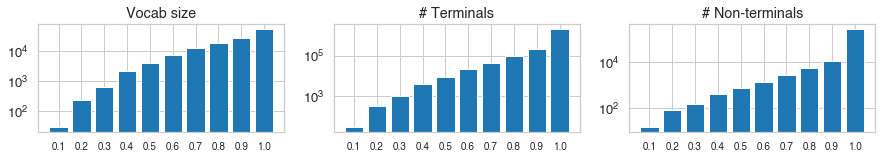

In [77]:
# vocab_sizes = [len(lang.idx2token) for lang in corpora.values()]

# nt_productions = [len([p for p in lang.grammar.productions() if not isinstance(p.rhs()[0], str)]) for lang in corpora.values()]
# t_productions = [len([p for p in lang.grammar.productions() if isinstance(p.rhs()[0], str)]) for lang in corpora.values()]

fig, axes = plt.subplots(1,3, figsize=(15,2))
axes[0].bar(range(10),vocab_sizes)
axes[0].set_yscale('log')
axes[0].set_title("Vocab size")
axes[0].set_xticks(range(10))
axes[0].set_xticklabels([(i+1)/10 for i in range(10)], fontsize=10)

axes[1].bar(range(10), t_productions)
axes[1].set_yscale('log')
axes[1].set_title("# Terminals")
axes[1].set_xticks(range(10))
axes[1].set_xticklabels([(i+1)/10 for i in range(10)], fontsize=10)

axes[2].bar(range(10), nt_productions)
axes[2].set_yscale('log')
axes[2].set_title("# Non-terminals")
axes[2].set_xticks(range(10))
axes[2].set_xticklabels([(i+1)/10 for i in range(10)], fontsize=10)

plt.show()

In [63]:
corpora[10].tree_corpus[0].height()

9

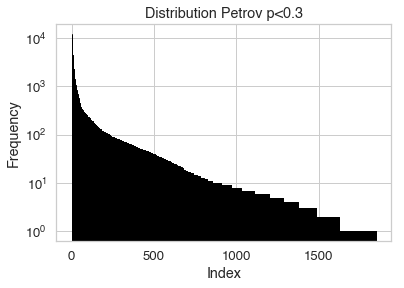

In [162]:
# train_ids = set(x.item() for y in lm_language.train_corpus for x in y)
# test_ids = set(x.item() for y in lm_language.dev_corpus for x in y)

# test_ids - train_ids
distribution = Counter(lm_language.idx2token[x.item()] for y in lm_language.train_corpus for x in y[1:]).most_common()#[:100]
plt.bar(range(len(distribution)), [c for w, c in distribution], width=1., color="black", edgecolor="black")
plt.yscale("log")
plt.ylabel("Frequency")
plt.xlabel("Index")
plt.title("Distribution Petrov p<0.3")
plt.show()

In [205]:
with open("petrov/subsets/0.5_petrov_words.txt") as f:
# with open("pcfg_langs/0.3_pcfg_words.txt") as f:
    ptb_raw_grammar = f.read()

    
is_binary = False
config = PCFGConfig(
    is_binary=is_binary,
    min_length=6,
    max_length=20,
    max_depth=200,
    corpus_size=100_000,
    raw_grammar=ptb_raw_grammar,
    start="S_0",
    add_cls=True,
    masked_lm=True
)
lm_language = PCFG(config)

distribution = Counter(lm_language.idx2token[x.item()] for y in lm_language.train_corpus for x in y[1:]).most_common()#[:100]

lm_language2 = PCFG(config)
distribution2 = Counter(lm_language2.idx2token[x.item()] for y in lm_language2.train_corpus for x in y[1:]).most_common()#[:100]

In [206]:
distribution_dict = dict(distribution)
cross_distribution = [distribution_dict[w] for w, _ in distribution2 if w in distribution_dict]

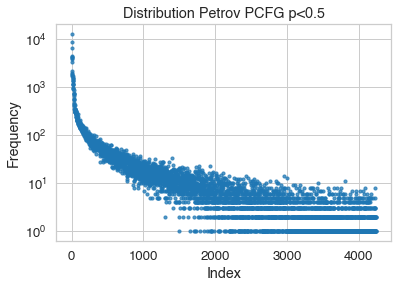

In [211]:
# plt.bar(range(len(cross_distribution)), cross_distribution, width=1., color="black", edgecolor="black")
plt.scatter(range(len(cross_distribution)), cross_distribution, s=10, alpha=.75)#, width=1., color="black", edgecolor="black")
plt.yscale("log")
plt.ylabel("Frequency")
plt.xlabel("Index")
plt.title("Distribution Petrov PCFG p<0.5")
plt.show()

In [208]:
with open("petrov/subsets/0.3_petrov_pos.txt") as f:
    ptb_raw_grammar = f.read()

    
is_binary = False
config = PCFGConfig(
    is_binary=is_binary,
    min_length=4,
    max_length=200,
    max_depth=100,
    corpus_size=1000,
    raw_grammar=ptb_raw_grammar,
    start="S_0",
    add_cls=True,
    masked_lm=True
)

lm_language = PCFG(config)
len(lm_language.corpus)

927

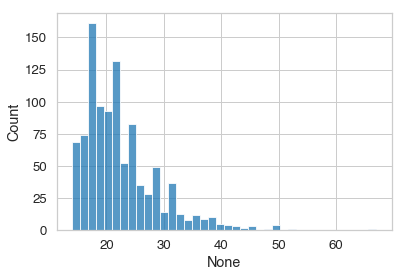

In [205]:
sns.histplot([len(x) for x in lm_language.corpus])

In [206]:
for t in lm_language.corpus[:10]:
    print(lm_language.translate(t))

[CLS] William Lee , trading of Dow Bank Inc , said they will be completed .
[CLS] Robert Lehman , trading of Missouri Technology Broadcasting Inc , will become a long role in buying money .
[CLS] Charles AG , trading of New Industries Insurance Co , said they wo n<apostrophe>t think they wo n<apostrophe>t think they wo n<apostrophe>t have to win a loss that have been reported .
[CLS] William Robertson , a unit of Nigel Insurance International Inc , said they have agreed to raise debt .
[CLS] David Procter , trading of Drexel Investment Capital Securities Inc , said they will have to meet credit .
[CLS] David Corp. , trading of May International Co , said they will be paid .
[CLS] Robert Smith , trading of Semel Research Inc , said they will be able to sell people .
[CLS] James Stevens , a unit of Mr. Entertainment Inc , will make the use of people that will be completed and says the market in September .
[CLS] David City , a recession of Illinois Group Co , said they will be disclosed 

In [80]:
model.is_binary = False

item = lm_language.train_corpus[0].clone().unsqueeze(0)
print(item)
idx = 2
print(item[0,idx])

item[0, [idx]] = lm_language.mask_idx
print(item)
model(item, mask_ids=[[idx]]).argmax(-1)

tensor([[4, 6, 6, 5, 2, 5, 2, 3, 3, 5, 5, 5, 2, 5, 2, 2, 2]])
tensor(6)
tensor([[4, 6, 0, 5, 2, 5, 2, 3, 3, 5, 5, 5, 2, 5, 2, 2, 2]])


tensor([6])

(S (NP-SBJ (DT dt) (NN nn)) (VP (VBD vbd) (NP (NNS nns))))


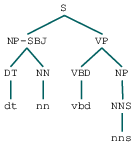

In [373]:
srp = ChartParser(lm_language.grammar)

sen = "dt nn vbd nns".split()
for parse in srp.parse(sen):
    print(parse)
    break
next(srp.parse(sen))

#### Optimal Perplexity

In [18]:
import gc


def load_language(ratio, encoder="transformer", corpus_size=200_000):
    tokenizer_config = TokenizerConfig(
        add_cls=(encoder == "transformer"),
        masked_lm=(encoder == "transformer"),
        unk_threshold=5,
    )
    tokenizer = Tokenizer(tokenizer_config)

    language_config = PCFGConfig(
        is_binary=False,
        min_length=6,
        max_length=20,
        max_depth=25,
        corpus_size=corpus_size,
        grammar_file=f"petrov/500k_5SM/subsets/{ratio}_petrov_words_all_leaves.txt",
        start="S_0",
        add_cls=(encoder == "transformer"),
        masked_lm=(encoder == "transformer"),
        allow_duplicates=True,
        split_ratio=(0.8, 0.1, 0.1),
        file=f'lib/data/{ratio}_200k.pt',
    )

    language = PCFG(language_config, tokenizer)

    return language, tokenizer


def add_special_token(grammar):
    leaf_prod_lhs = set(prod.lhs() for prod in grammar.productions() if isinstance(prod.rhs()[0], str))

    special_token = '<X>'
    special_prods = []

    # Add single '<X>' leaf that is added to all leaf_prods and parse once
    for lhs in leaf_prod_lhs:
        special_prod = ProbabilisticProduction(lhs, (special_token,), prob=1.)
        special_prods.append(special_prod)

    grammar._productions.extend(special_prods)

    grammar._calculate_indexes()
    grammar._calculate_grammar_forms()
    grammar._calculate_leftcorners()

    
def create_prod2prob_dict(grammar) -> Dict[Production, float]:
    prod2prob = defaultdict(float)

    for lhs, prods in grammar._lhs_index.items():
        for prod in prods:
            cfg_prod = Production(lhs, prod.rhs())

            prod2prob[cfg_prod] = prod.prob()
            
    return prod2prob


In [19]:
language, tokenizer = load_language(1.0, encoder="transformer", corpus_size=None)

In [23]:
with open('corpora/train_1.0.txt', 'w') as f:
    f.write('\n'.join(language.train_corpus))
    
with open('corpora/dev_1.0.txt', 'w') as f:
    f.write('\n'.join(language.dev_corpus))
    
with open('corpora/test_1.0.txt', 'w') as f:
    f.write('\n'.join(language.test_corpus))

In [32]:
prod2prob = create_prod2prob_dict(language.grammar)

In [79]:
prods = set()

for prod in tqdm_notebook(language.grammar.productions()):
    if len(prod.rhs()) == 1 and not isinstance(prod.rhs()[0], str):
        prods.add(prod.lhs().symbol().split('_')[0] + '-' + prod.rhs()[0].symbol().split('_')[0])# + prod.rhs()[1].symbol().split('_')[0])

<ipython-input-79-9e095b98a0ef>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for prod in tqdm_notebook(language.grammar.productions()):


  0%|          | 0/2513065 [00:00<?, ?it/s]

In [86]:
for i in range(10,11):
    print(i)
    ratio = i/10

    language, tokenizer = load_language(ratio, encoder="transformer", corpus_size=10_000)

    with open(f'petrov/test_sets/{ratio}_test.txt', 'w') as f:
        f.write("\n".join(language.test_corpus).replace('<apostrophe>', "'").replace('<cross>', '†'))
        
    del language, tokenizer

10


In [84]:
del language, tokenizer, prod2prob

In [ ]:
prod2prob[Production(Nonterminal(""))]

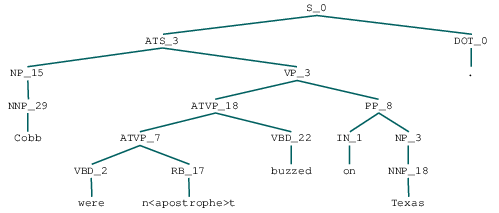

In [148]:
tree = list(language.tree_corpus.values())[2]
tree

In [150]:
np.sum([np.log(prod2prob[prod]) for prod in tree.productions()])# if not isinstance(prod.rhs()[0], str)])

-41.68460776619882

In [156]:
p(w) = p(T|w) p(t,w)

-42.07338

In [49]:
np.exp(-16.12)

9.980974630804682e-08

In [ ]:
p(t,w) = p(t|w)*p(w)
p(w) = p(t,w) / p(t|w)
logp(w) = logp(t,w) - logp(t|w)

p(w) = sum_t p(t,w)

p(t,w) = p(w|t) * p(t)

In [32]:
language.grammar._rhs_index[';']
# np.log(0.00034667)

[COLON_3 -> ';' [0.722812],
 COMMA_0 -> ';' [3.20648e-05],
 COLON_1 -> ';' [0.000851326],
 COLON_2 -> ';' [0.00214626],
 COLON_0 -> ';' [0.000255223],
 COLON_4 -> ';' [0.232745]]

In [42]:
np.log(2.5303726647846417E-6)

-12.887143967738329

In [37]:
language.grammar.productions(lhs=Nonterminal('COMMA_0'))

[COMMA_0 -> 'an' [9.1919e-05],
 COMMA_0 -> ',' [0.999684],
 COMMA_0 -> ';' [3.20648e-05],
 COMMA_0 -> '-' [0.000192389]]

In [40]:
[prod for prod in language.grammar.productions(lhs=Nonterminal('ATNP_28')) if prod.rhs()[0] == Nonterminal('ATNP_28')]

[ATNP_28 -> ATNP_28 NN_17 [5.51094e-07],
 ATNP_28 -> ATNP_28 NP_7 [2.60028e-05],
 ATNP_28 -> ATNP_28 ADJP_11 [5.7398e-05],
 ATNP_28 -> ATNP_28 NNS_15 [0.00021747],
 ATNP_28 -> ATNP_28 NN_10 [5.17114e-06],
 ATNP_28 -> ATNP_28 JJ_5 [0.0226272],
 ATNP_28 -> ATNP_28 NNS_23 [2.82305e-06],
 ATNP_28 -> ATNP_28 NNP_13 [0.000110149],
 ATNP_28 -> ATNP_28 JJ_7 [9.51666e-07],
 ATNP_28 -> ATNP_28 JJ_4 [0.00569103],
 ATNP_28 -> ATNP_28 CC_5 [1.35666e-05],
 ATNP_28 -> ATNP_28 JJ_11 [3.83848e-05],
 ATNP_28 -> ATNP_28 VBN_10 [0.000837999],
 ATNP_28 -> ATNP_28 NN_3 [5.43157e-07],
 ATNP_28 -> ATNP_28 NN_16 [7.95028e-06],
 ATNP_28 -> ATNP_28 NN_0 [3.01581e-07],
 ATNP_28 -> ATNP_28 CC_4 [1.79389e-06],
 ATNP_28 -> ATNP_28 NNP_14 [0.000240473],
 ATNP_28 -> ATNP_28 JJ_3 [5.62761e-06],
 ATNP_28 -> ATNP_28 JJ_2 [0.00116051],
 ATNP_28 -> ATNP_28 PRN_3 [1.22346e-07],
 ATNP_28 -> ATNP_28 NNP_11 [1.24012e-06],
 ATNP_28 -> ATNP_28 UCP_0 [3.63719e-05],
 ATNP_28 -> ATNP_28 ADJP_5 [0.000146563],
 ATNP_28 -> ATNP_28 NNS

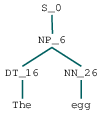

In [28]:
t = '(S-0 (NP-6 (DT-16 The) (NN-26 egg)))'

revtree = nltk.Tree.fromstring(t.replace('-', '_').replace('@', 'AT'))

revtree

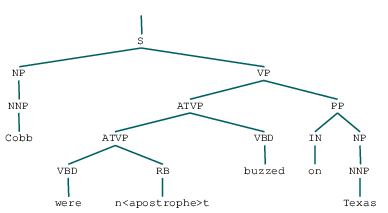

In [145]:
t = '( (S (NP (NNP Cobb)) (VP (@VP (@VP (VBD were) (RB n<apostrophe>t)) (VBD buzzed)) (PP (IN on) (NP (NNP Texas))))) )'
t1 = nltk.Tree.fromstring(t.replace('-', '_').replace('@', 'AT'))
t1

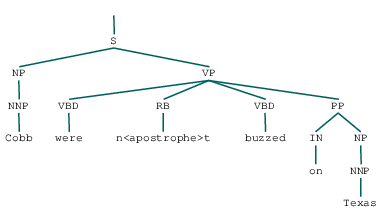

In [147]:
t = '( (S (NP (NNP Cobb)) (VP (VBD were) (RB n<apostrophe>t) (VBD buzzed) (PP (IN on) (NP (NNP Texas))))) )'
t2 = nltk.Tree.fromstring(t.replace('-', '_').replace('@', 'AT'))
t2

In [131]:
replacements = [
    ('``', 'TICK'),
    ('.', 'DOT'),
    ('#', 'HASH'),
    ('-LRB-', 'LRB'),
    ('-RRB-', 'RRB'),
    ("''", 'APOSTROPHE'),
    ('$', 'DOLLAR'),
    (':', 'COLON'),
    (',', 'COMMA'),
    ('@', 'AT'),
    ('PRT|ADVP', 'PRTADVP'),
    ('^g', ''),
]

def format_line(line):
    for s1, s2 in replacements:
        line = line.replace(s1, s2)
    
    return line

int2nt = ['ROOT', 'S^g', '@S^g', 'NP^g', 'NNP', 'VP^g', 'VBD', ',', 'CC', 'DT', 'NN', '.', 'PRP', 'MD', '@VP^g', 'VB', 'ADVP^g', 'RB', 'PP^g', 'IN', 'NNS', ':', 'VBN', 'INTJ^g', 'UH', 'ADJP^g', '@ADJP^g', 'JJ', 'SBAR^g', 'EX', '@NP^g', 'TO', 'WHNP^g', 'WP', 'POS', 'PRP$', 'JJR', 'VBG', 'RRC^g', 'JJS', 'CD', 'PRT^g', 'RP', '@PP^g', '@ADVP^g', '``', 'VBP', 'VBZ', "''", 'WHADVP^g', 'WRB', 'WDT', 'FRAG^g', 'PDT', '@SBAR^g', 'RBR', 'QP^g', '@QP^g', 'NNPS', 'RBS', 'NX^g', '@NX^g', 'PRN^g', '@PRN^g', '@FRAG^g', '@INTJ^g', 'CONJP^g', '@CONJP^g', 'SQ^g', '@SQ^g', 'SBARQ^g', '@SBARQ^g', 'SINV^g', '@SINV^g', 'UCP^g', '@UCP^g', '@WHNP^g', 'WHADJP^g', 'X^g', 'SYM', 'FW', 'WP$', 'WHPP^g', '-LRB-', '-RRB-', '$', '@PRT^g', 'NAC^g', '@NAC^g', '@WHADJP^g', 'LS', '@WHADVP^g', 'LST^g', '@X^g', '@LST^g', '#', '@RRC^g']
int2nt = [format_line(nt) for nt in int2nt]

In [257]:
preterminals = set()
nonterminals = set()

for nt, prods in language.grammar._lhs_index.items():
    if isinstance(prods[0].rhs()[0], str):
        preterminals.add(nt)
        continue
    
    for prod in prods:
        if len(prod.rhs()) == 1:
            nonterminals.add(nt)
            
            
unary_nts = set()

for nt in nonterminals:
    for prod in language.grammar._lhs_index.get(Nonterminal(nt), []):
        if len(prod.rhs()) == 1 and prod.rhs()[0].symbol() not in preterminals:
            unary_nts.add(nt)
            
len(unary_nts), nonterminals - unary_nts

(132,
 {'ADVP_0',
  'ADVP_1',
  'ADVP_2',
  'ADVP_3',
  'ADVP_4',
  'ADVP_5',
  'CONJP_0',
  'INTJ_0',
  'INTJ_1',
  'INTJ_2',
  'PP_10',
  'PP_11',
  'PP_12',
  'PP_13',
  'PP_14',
  'PP_15',
  'PP_9',
  'PRT_0',
  'QP_0',
  'QP_1',
  'ROOT_0',
  'VP_8',
  'WHADVP_0',
  'WHADVP_1',
  'WHNP_0',
  'X_0'})

In [393]:
stack = set()

valid_prods = set()
unvalid_prods = set()
valid_nts = set(preterminals)

steps_to_preterminal = defaultdict(set)

for nt in nonterminals:
    unary_prods = set(prod for prod in language.grammar._lhs_index[nt] if len(prod.rhs()) == 1)

    stack.update(unary_prods)
    
for i in range(2):
    for prod in stack:
        if prod in valid_prods:
            continue

        if prod.rhs()[0] in valid_nts:
            steps_to_preterminal[i].add(prod)
            valid_prods.add(prod)
            valid_nts.add(prod.lhs())
        elif prod.rhs()[0] not in nonterminals:
            unvalid_prods.add(prod)
        
assert len(valid_prods) + len(unvalid_prods) == len(stack)


# NTs that only map to preterminals
# one_step_nts = set(prod.lhs() for prod in steps_to_preterminal[0])
# two_step_nts = set(prod.lhs() for prod in steps_to_preterminal[1])


one_step_prods_dict = defaultdict(set)

for prod in steps_to_preterminal[0]:
    one_step_prods_dict[prod.lhs()].add(prod)

In [401]:
one_step_nts = set()

for nt, prods in one_step_prods_dict.items():
    preterminals_only = True
    
    for prod in prods:
        if prod.rhs()[0] not in preterminals:
            preterminals_only = False
            break
    
    if preterminals_only:
        one_step_nts.add(nt)

In [265]:
nonterminals = set()

def parse_output_probs(fn: str, preterminals_only: bool = True):
    with open(fn) as f:
        lines = [l.strip().replace("'", "<apostrophe>") for l in f]

    cur_sen = None
    cur_token = None
    cur_probs: Dict[str, float] = {}
    weighted_token_probs = []

    for line in lines:
        if len(line) == 0:
            total_prob_weight = sum(cur_probs.values())
            for nt, prob in cur_probs.items():
                cur_probs[nt] = prob / total_prob_weight

            weighted_token_prob = 0.
            for nt, prob in cur_probs.items():
                prod = Production(Nonterminal(nt), (cur_token,))
                weighted_token_prob += prob * prod2prob[prod]
            
            weighted_token_probs.append(weighted_token_prob)
            
            cur_probs = {}
            cur_token = None

        elif line[0].isnumeric():
            nt_idx, probs = line.split('\t')
            nt_idx = int(nt_idx)

            if probs == 'null':
                continue

            for split_nt_idx, prob in enumerate(eval(probs)):
                split_nt = f"{int2nt[nt_idx]}_{split_nt_idx}"

                if preterminals_only and split_nt not in preterminals:
                    nonterminals.add(split_nt)
                    continue

                cur_probs[split_nt] = prob

        elif line.startswith('Token'):
            cur_token = cur_sen[int(line[7:])]

        else:
            cur_sen = line.split()

    return np.array(weighted_token_probs)


token_probs = parse_output_probs('petrov_perplexity/dev_sample_output.txt', preterminals_only=True)

In [242]:
np.exp(-np.sum(np.log(token_probs))/len(token_probs))

44.306461721030956

In [246]:
def is_leaf(prod):
    return isinstance(prod.rhs()[0], str)

[]

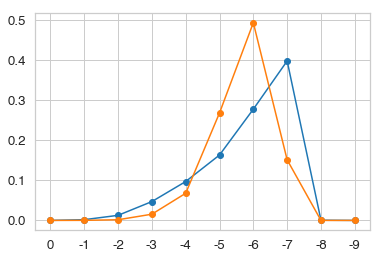

In [102]:
# prob_hist_nt = [len([prob for prod, prob in prod2prob.items() if not is_leaf(prod) and 10**-(i-1) > prob > 10**-i]) for i in range(0,10)]
# prob_hist_leaf = [len([prob for prod, prob in prod2prob.items() if is_leaf(prod) and 10**-(i-1) > prob > 10**-i]) for i in range(0,10)]

plt.plot(range(len(prob_hist_nt)), [c/np.sum(prob_hist_nt) for c in prob_hist_nt], 'o-')
plt.plot(range(len(prob_hist_nt)), [c/np.sum(prob_hist_leaf) for c in prob_hist_leaf], 'o-')

plt.xticks(range(len(prob_hist)), [-i for i in range(0,10)])
# plt.yscale('log')
plt.plot()

In [128]:
cumsum = np.cumsum(sorted(probs, reverse=True))

In [132]:
cumsum[1_900_000]

717.5594994122625

In [133]:
cumsum[:10]

array([1.        , 2.        , 3.        , 4.        , 5.        ,
       6.        , 6.99968363, 7.99771884, 8.99568319, 9.99291368])

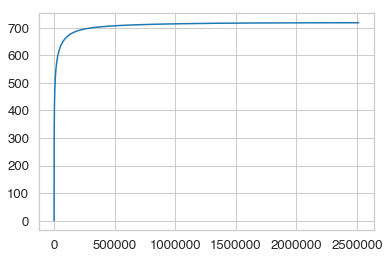

In [129]:
plt.plot(cumsum)

In [118]:
np.sum(sorted(probs, reverse=True)[:2_500_000-200_000])

717.9386709304412

In [107]:
46641*10e-6, 79355*10e-7, 113750*10e-8

(0.46641000000000005, 0.079355, 0.011375)

In [126]:
np.array(prob_hist_leaf)+np.array(prob_hist_nt)

array([      0,     962,    7321,   48065,  178966,  645425, 1180740,
        451399,     151,       0])

In [81]:
i = 1
probable_prods = ([prod for prod, prob in prod2prob.items() if 10**-(i-1) > prob > 10**-i])

In [29]:
[(prod, prod2prob[prod]) for prod in revtree.productions()]

NameError: name 'prod2prob' is not defined

In [54]:
np.sum([np.log(prod2prob[prod]) for prod in tree.productions()]), np.sum([np.log(prod2prob[prod]) for prod in revtree.productions()])

(-41.68460776619882, -93.81291442053409)

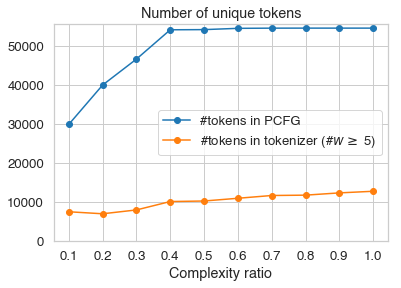

In [50]:
plt.plot(num_tokens.values(), 'o-', label='#tokens in PCFG')
plt.plot(num_model_tokens.values(), 'o-', label='#tokens in tokenizer (#$w \\geq$ 5)')

plt.ylim(0, max(num_tokens.values())*1.02)
plt.xticks(range(10),num_tokens.keys())
plt.xlabel('Complexity ratio')

plt.legend(loc='center right')
plt.title('Number of unique tokens')


plt.show()

In [72]:
import re
import numpy as np


with open('petrov/src/eval_sens_probs_sample.txt') as f:
    lines = f.read()

logprobs = [np.log(float(x)) for x in re.findall(r'[0-9]\.[0-9]*E?-?[0-9]*', lines)]

ppl = np.exp(-np.sum(logprobs)/len(logprobs))
ppl

60.0843546739185

In [74]:
np.mean(logprobs)

-4.095749486086206

In [17]:
import signal
import time


class TimeoutException(Exception):
    pass


def timeout_handler(signum, frame):
    raise TimeoutException


signal.signal(signal.SIGALRM, timeout_handler)


def pcfg_perplexity(lm_language, method, prod2prob, max_parse_time=10, corpus_size=None, sen_ids_filter=None, verbose=False):
    all_probs = []
    sen_lens = []
    num_parses = []
    sen_ids = []
    
    chart_parser = Parser(lm_language.grammar)
    corpus = lm_language.test_corpus[:corpus_size]  
    
    iterator = tqdm_notebook(corpus) if verbose else corpus
    
    for sen_idx, sen in enumerate(iterator):
        if sen_ids_filter is not None and sen_idx not in sen_ids_filter:
            continue

        orig_tree = lm_language.tree_corpus[sen]
        sen = sen.split()
        sen_len = len(sen)

        if method == 'all_parses':
            weighted_leaf_probs = []
            num_sen_parses = []
            skip = False

            signal.alarm(max_parse_time)
            try:
                for idx, orig_leaf in enumerate(sen):
                    sen2 = list(sen)
                    sen2[idx] = '<X>'

                    tree_probs = []
                    leaf_probs = []

                    for i, tree in enumerate(chart_parser.parse(sen2)):
                        tree_prob = np.prod([(prod2prob[prod]) for prod in tree.productions()])

                        leaf_idx_prod = [prod for prod in tree.productions() if isinstance(prod.rhs()[0], str)][idx]
                        leaf_idx_pos = leaf_idx_prod.lhs()
                        orig_leaf_prob = prod2prob[Production(leaf_idx_pos, (orig_leaf,))]

                        tree_probs.append(tree_prob)
                        leaf_probs.append(orig_leaf_prob)

                    num_sen_parses.append(i+1)
                    tree_probs_sum = np.sum(tree_probs)

                    weighted_leaf_prob = sum((tree_prob/tree_probs_sum) * leaf_prob for tree_prob, leaf_prob in zip(tree_probs, leaf_probs))
                    weighted_leaf_probs.append(np.log(weighted_leaf_prob))
            except TimeoutException:
                continue
            finally:
                signal.alarm(0)

            sen_ids.append(sen_idx)
            num_parses.append(num_sen_parses)
            all_probs.append(np.sum(weighted_leaf_probs))        
        elif method == 'sen_parses':
            sen_leaf_probs = []
            sen_tree_probs = []

            start_time = time.time()
            signal.alarm(max_parse_time)
            try:
                parses = list(chart_parser.parse(sen))
            except TimeoutException:
                continue
            finally:
                signal.alarm(0)

            for i, tree in enumerate(parses):
                leaf_probs = [prod2prob[prod] for prod in tree.productions() if isinstance(prod.rhs()[0], str)]
                leaf_prob = np.prod(leaf_probs)
                tree_prob = np.prod([(prod2prob[prod]) for prod in tree.productions()])# if not isinstance(prod.rhs()[0], str)])

                sen_leaf_probs.append(leaf_prob)
                sen_tree_probs.append(tree_prob)

            total_sen_tree_probs = sum(sen_tree_probs)
            weighted_sen_prob = sum(
                (tree_prob/total_sen_tree_probs) * leaf_prob 
                for tree_prob, leaf_prob in zip(sen_tree_probs, sen_leaf_probs)
            )
            weighted_sen_logprob = np.log(weighted_sen_prob)

            sen_ids.append(sen_idx)
            num_parses.append(i+1)
            all_probs.append(weighted_sen_logprob)
        elif method == 'current_parse':
            leaf_prods = [prod for prod in orig_tree.productions() if isinstance(prod.rhs()[0], str)]
            sen_prob = np.sum([np.log(prod2prob[prod]) for prod in leaf_prods])
            
            sen_ids.append(sen_idx)
            all_probs.append(sen_prob)
        else:
            raise ValueError(method)

        sen_lens.append(sen_len)
                
    avg_ppl = np.exp(-np.sum(all_probs)/np.sum(sen_lens))
    
    return avg_ppl, all_probs, num_parses, sen_lens, sen_ids



# avg_ppl, all_probs, num_parses, sen_lens, sen_ids = pcfg_perplexity(
#     language, 'current_parse', prod2prob, max_parse_time=1, corpus_size=None, 
# )
# avg_ppl
# 14.75 | 14.57 | 17.91

In [18]:
num_tokens = {}
num_model_tokens = {}

ppls = np.zeros((10,4))

for i in [8]:  # range(1,11):
    ratio = i/10

    language, tokenizer = load_language(ratio, corpus_size=2_000)
    add_special_token(language.grammar)
    prod2prob = create_prod2prob_dict(language.grammar)

    tokens = set(prod.rhs()[0] for prod in language.grammar.productions() if isinstance(prod.rhs()[0], str))
    
    num_tokens[ratio] = len(tokens)
    num_model_tokens[ratio] = len(tokenizer.idx2token)
    
    print(ratio, len(tokens), len(tokenizer.idx2token))

    avg_ppl_all, _, _, _, sen_ids = pcfg_perplexity(
        language, 'all_parses', prod2prob, max_parse_time=12, corpus_size=None, verbose=True
    )
    avg_ppl_sen = pcfg_perplexity(
        language, 'sen_parses', prod2prob, max_parse_time=2, corpus_size=None, sen_ids_filter=sen_ids, verbose=True
    )[0]
    avg_ppl_cur = pcfg_perplexity(
        language, 'current_parse', prod2prob, max_parse_time=1, corpus_size=None, sen_ids_filter=sen_ids
    )[0]
    avg_ppl_cur_full = pcfg_perplexity(
        language, 'current_parse', prod2prob, max_parse_time=1, corpus_size=None
    )[0]
    
    ppls[i-1] = avg_ppl_all, avg_ppl_sen, avg_ppl_cur, avg_ppl_cur_full
    print(ratio, avg_ppl_all, avg_ppl_sen, avg_ppl_cur, avg_ppl_cur_full)

    del language, tokenizer
    gc.collect()
    gc.collect()

0.8 54498 396


<ipython-input-17-46ca11b42212>:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  iterator = tqdm_notebook(corpus) if verbose else corpus


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

0.8 11.08599455255702 7.539543323327572 7.655344309105398 17.283547184030247


Text(0.5,1,'Optimal PCFG Perplexity')

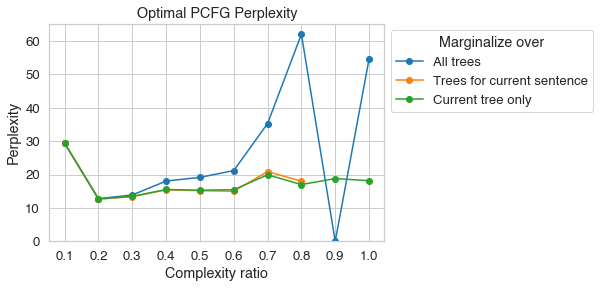

In [61]:
#0.4 0.5 0.6 0.7
ppls = np.array([[29.36493376, 29.36493376, 29.36493376, 29.36493376],
       [12.77950443, 12.65815393, 12.66953993, 12.66953993],
       [13.87667213, 13.36591003, 13.37019567, 13.45249477],
       [18.04653831, 15.41369914, 15.60767712, 15.52000393],
       [19.15175626, 15.16452104, 15.23610272, 15.30077016],
       [21.18825487, 14.98684225, 15.183844  , 15.45670657],
       [35.28969950, 20.89218275, 21.15704267, 19.93294673],
       [62.04005096, 17.99247780,  0.        , 16.99323346],  # 4
       [0.        ,  0.        ,  0.        , 18.79436194],
       [54.5621553128481,  0.        ,  0.        , 18.15760798]])

plt.plot(ppls[:,0], 'o-', label='All trees')
plt.plot(ppls[:8,1], 'o-', label='Trees for current sentence')
plt.plot(ppls[:,3], 'o-', label='Current tree only')

plt.xticks(range(10), np.arange(1,11)/10)
plt.ylim(0, np.max(ppls)*1.05)
plt.legend(bbox_to_anchor=(1,1), title='Marginalize over')
plt.xlabel('Complexity ratio')
plt.ylabel('Perplexity')
plt.title("Optimal PCFG Perplexity")
# plt.plot(ppls[:7,3], 'o-')

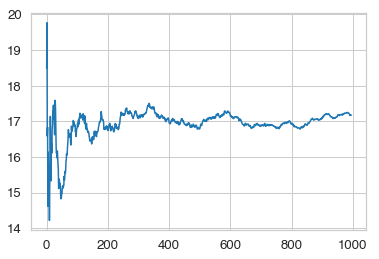

In [144]:
shuffle = random.sample(range(len(all_probs)), k=len(all_probs))
ppls = [np.exp(-np.sum(np.array(all_probs)[shuffle][:idx])/np.sum(np.array(sen_lens)[shuffle][:idx])) for idx in range(1,1001)]
plt.plot(ppls[5:])

In [71]:
language, tokenizer = load_language(0.6, corpus_size=10_000)
add_special_token(language.grammar)
prod2prob = create_prod2prob_dict(language.grammar)

In [19]:
lm_language.grammar._lhs_index[Nonterminal('DOT_0')]

[DOT_0 -> '!' [0.00203565], DOT_0 -> '.' [0.997964], DOT_0 -> '<X>' [1.0]]

In [24]:
list(zip(sen,map(np.exp,weighted_leaf_probs)))

[('Almira', 7.053522651702768e-05),
 ('forced', 0.00267633377746431),
 ('his', 0.4421911844356622),
 ('pocket', 0.004229922502838947),
 ('at', 0.35858585224919615),
 ('him', 0.16102516406398404),
 (',', 0.9996836275167588),
 ('looking', 0.008846722567134398),
 ('my', 0.0069689356579791485),
 ('redundancy', 5.261007465285515e-06),
 ('swords', 0.0009425560568572889),
 ('.', 0.997964348715547)]

In [24]:
[(w, prod2prob[prod]) for w, prod in zip(sen,leaf_prods)]

[('They', 0.0660420505198262),
 ('let', 0.0016849272245365),
 ('a', 0.7364581405368444),
 ('perfect', 0.0039968242906128),
 ('run', 0.0006715993540818),
 ('Of', 0.001473416062139),
 ('the', 0.8873723119317655),
 ('time', 0.002909220199913),
 ('and', 0.9185625204769388),
 ('punched', 0.0011918728527211),
 ('his', 0.4503269939342952),
 ('headset', 0.0004371295805754),
 ('through', 0.0592206707517366),
 ('the', 0.8873723119317655),
 ('stream', 0.0004056592653914),
 ('.', 0.9979643487155468)]

In [27]:
sen_prob

-60.8252826018134

In [27]:
# np.exp(sen_prob / len(leaf_prods))
np.array(list(map(np.exp,weighted_leaf_probs))) / np.array([(prod2prob[prod]) for prod in leaf_prods])

array([0.2276897 , 0.67499543, 0.98193355, 0.70787636, 0.89870472,
       0.99899058, 1.        , 1.        , 0.04504538, 1.00005887,
       0.48840525, 1.        ])

In [28]:
[(prod, prod2prob[prod]) for prod in tree.productions()]

[(S_0 -> ATS_3 DOT_0, 1.0),
 (ATS_3 -> NP_20 VP_2, 0.4118796506741108),
 (NP_20 -> PRP_0, 1.0),
 (PRP_0 -> 'It', 0.1199151411640022),
 (VP_2 -> ATVP_18 PP_8, 0.1863028809381776),
 (ATVP_18 -> VBD_20 PRT_0, 0.2562932075551089),
 (VBD_20 -> 'looked', 0.0989902776565594),
 (PRT_0 -> RP_0, 1.0),
 (RP_0 -> 'in', 0.0305947135085663),
 (PP_8 -> IN_1 NP_1, 1.0),
 (IN_1 -> 'across', 0.0232678565298133),
 (NP_1 -> DT_18 NN_27, 0.6966304614103903),
 (DT_18 -> 'the', 0.8873723119317655),
 (NN_27 -> 'railing', 0.0009628039057074),
 (DOT_0 -> '<X>', 0.0)]

In [25]:
sen = 'They nodded his head down An bar and said her luggage into a street .'.split()

for idx in range(len(sen)):
    sen2 = list(sen)
    sen2[idx] = '<X>'
    
    trees = list(chart_parser.parse(sen2))
    print(len(trees))
    if len(trees) > 4:
        break

4
4
6


In [75]:
lm_language.grammar._rhs_index['his']

[PRPDOLLAR_2 -> 'his' [0.450327],
 PRP_1 -> 'his' [2.31979e-06],
 PRP_2 -> 'his' [1.58977e-05]]

In [35]:
trees[1].leaves()

['They',
 'nodded',
 '<X>',
 'head',
 'down',
 'An',
 'bar',
 'and',
 'said',
 'her',
 'luggage',
 'into',
 'a',
 'street',
 '.']

In [97]:
op, ap = all_leaf_probs[0]
sorted(ap).index(op) / len(ap)

0.8888888888888888

In [14]:
import numpy as np

10**(np.log10(10e-2)*.5 + np.log10(10e-4)*.5), 10e-2, 10e-4

(0.01, 0.1, 0.001)

In [67]:
# for tree_prob, leaf_prob in zip(sen_tree_probs, sen_leaf_probs):
#     print(tree_prob/total_sen_tree_probs, leaf_prob)



0.015059596169672772 7.030358084265181e-28
0.029203848823241025 7.651156355547778e-26
0.01259067878478279 3.057120373470934e-29
0.021440153559688195 2.3022972113035397e-29
0.1290344576704781 4.2876514665354e-25
0.792671264992137 1.4815131844034166e-19


In [78]:
weighted_sen_ppl, np.log(np.prod([(prod2prob[prod]) for prod in orig_tree.productions() if isinstance(prod.rhs()[0], str)]))

(-43.588398978627815, -43.35605277953392)

In [76]:
sen_tree_probs

[6.71768939324659e-09,
 1.302706814123861e-08,
 5.616370344421264e-09,
 9.5638880707533e-09,
 5.755887461324481e-08,
 3.535897834958174e-07]

In [62]:
sen_leaf_probs,  np.prod([(prod2prob[prod]) for prod in orig_tree.productions() if isinstance(prod.rhs()[0], str)])

([7.030358084265181e-28,
  7.651156355547778e-26,
  3.057120373470934e-29,
  2.3022972113035397e-29,
  4.2876514665354e-25,
  1.4815131844034166e-19],
 1.4815131844034166e-19)

(0, 1)

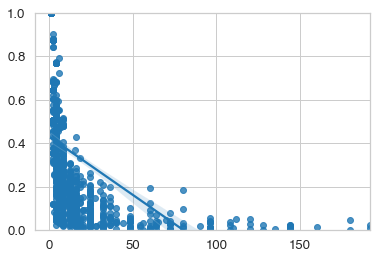

In [61]:
# num_parses = np.array(num_parses)
# orig_tree_prob_ratios = np.array(orig_tree_prob_ratios)

sns.regplot(num_parses[num_parses<200], orig_tree_prob_ratios[num_parses<200])
plt.ylim(0,1)

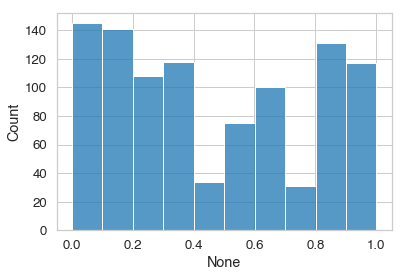

In [38]:
sns.histplot(orig_tree_prob_ratios, bins=10)

In [23]:
sen_tree_probs

[4.722776193339363e-36,
 9.967213520299177e-34,
 1.716992020488821e-37,
 2.2018912834514512e-37,
 2.4679239314760617e-32,
 5.238479261194032e-26]

(0, 200)

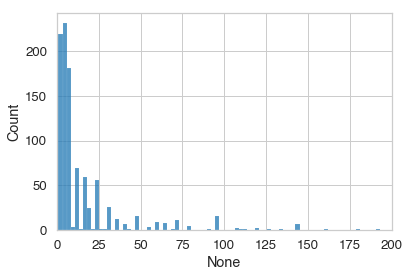

In [22]:
sns.histplot(num_parses)
plt.xlim(0,200)

In [26]:
trees = [tree for tree in chart_parser.parse(lm_language.test_corpus[3].split())]

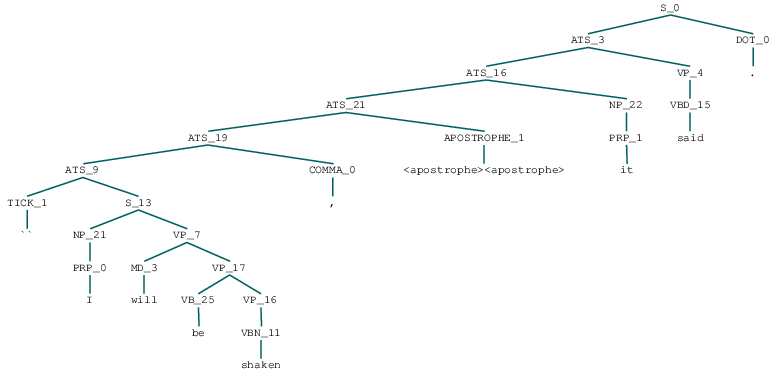

In [27]:
trees[0]

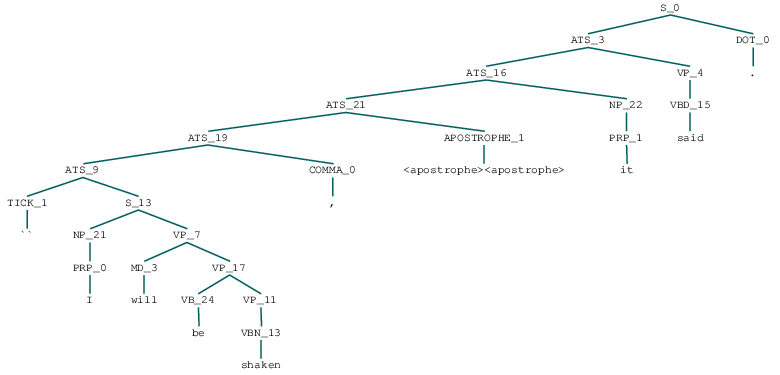

In [28]:
trees[1]

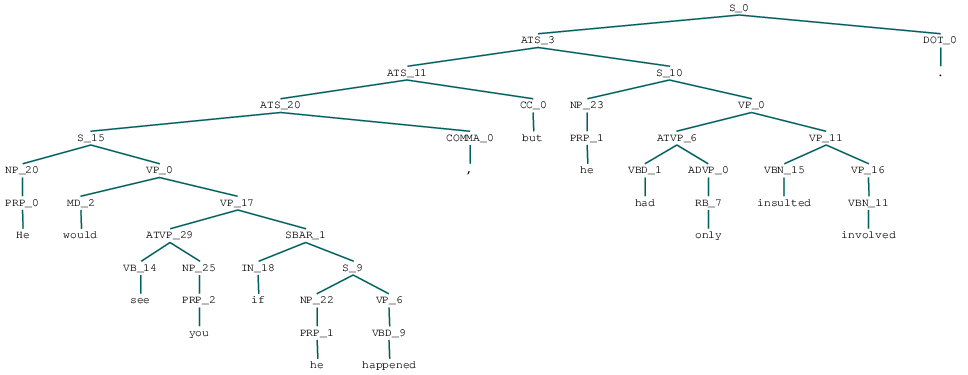

In [38]:
lm_language.tree_corpus[lm_language.test_corpus[np.argmax(num_parses)]]

In [69]:
np.mean(ppls)

17.33379321300533

In [71]:
np.mean(ppls)

17.54020219785142

In [19]:
np.mean(ppls)

32.35017261859403

In [29]:
np.mean(ppls)

20.755621401038553

In [31]:
np.mean(ppls)

20.763799825893237

In [18]:
all_pos = [
    tree_to_pos(tree, merge=False)
    for tree in tqdm_notebook(lm_language.tree_corpus.values())
]

<ipython-input-18-698c09c9f255>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tree in tqdm_notebook(lm_language.tree_corpus.values())


  0%|          | 0/200000 [00:00<?, ?it/s]

In [23]:
for tree, pos in zip(lm_language.tree_corpus.values(), all_pos):
    for idx in range(1,len(pos)):
        for tree2, other_pos in zip(lm_language.tree_corpus.values(), all_pos):
            if len(other_pos) == len(pos) and pos != other_pos:
                pos_minus_idx = [x for jdx, x in enumerate(pos) if jdx != idx]
                other_pos_minus_idx = [x for jdx, x in enumerate(other_pos) if jdx != idx]

                if pos_minus_idx == other_pos_minus_idx:
                    print(idx)
                    print(pos)
                    print(other_pos)

                    assert False

9
['PRP_0', 'MD_2', 'VB_25', 'DT_16', 'JJ_11', 'NN_22', 'COMMA_0', 'CC_0', 'PRP_1', 'VBD_5', 'DT_16', 'JJ_11', 'NN_22', 'DOT_0']
['PRP_0', 'MD_2', 'VB_25', 'DT_16', 'JJ_11', 'NN_22', 'COMMA_0', 'CC_0', 'PRP_1', 'VBD_6', 'DT_16', 'JJ_11', 'NN_22', 'DOT_0']


AssertionError: 

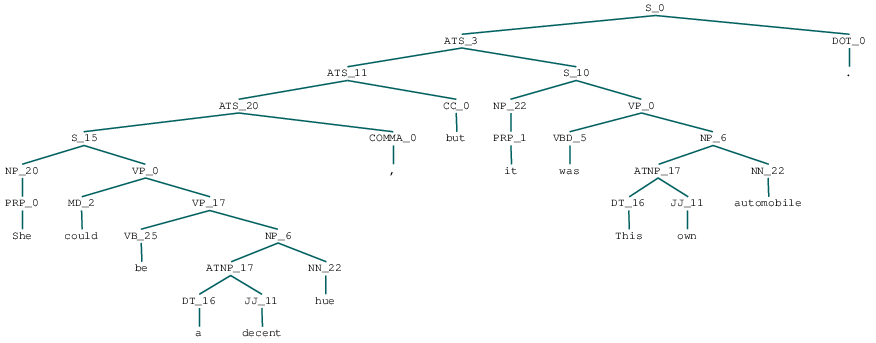

In [24]:
tree

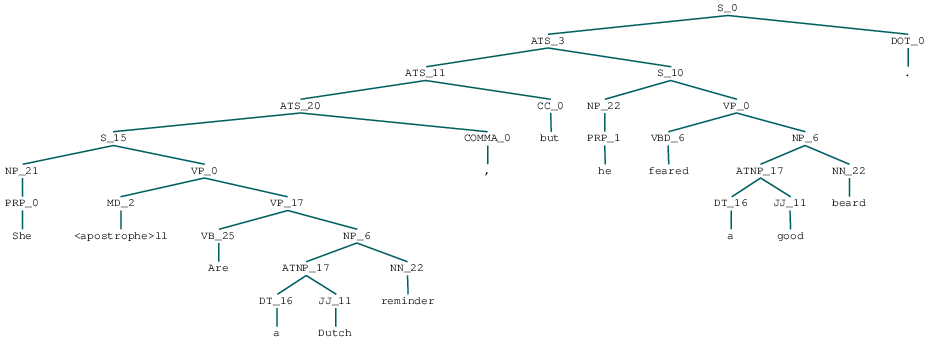

In [25]:
tree2

In [30]:
print('_'.join(pos))
print('_'.join(other_pos))

PRP_0_VBD_16_CC_5_VBD_12_PRPDOLLAR_2_NN_4_DOT_0
TICK_1_PRP_0_MD_3_VB_10_DT_16_NN_25_IN_10_NN_11_COMMA_0_APOSTROPHE_1_PRP_1_VBD_15_DOT_0


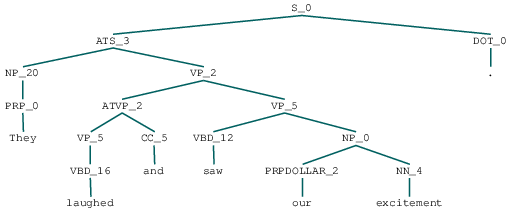

In [31]:
all_trees = list(lm_language.tree_corpus.values())

all_trees[0]

In [23]:
unique_prods = set(lm_language.grammar.productions())

In [35]:
lm_language.grammar.productions(lhs=Nonterminal('VP_5'))

[VP_5 -> VBD_12 NP_0 [0.308677],
 VP_5 -> ATVP_18 PP_8 [0.327781],
 VP_5 -> VBD_16 [0.363541]]

## HuggingFace Training

```+------------------------+------------+-------------------+---------------+-----------------+-----------------------+---------------------+------------------------+-------------+
| Trial name             | status     | loc               |   hidden_size |   learning_rate |   num_attention_heads |   num_hidden_layers |   per_device_train_bat |   objective |
|                        |            |                   |               |                 |                       |                     |                ch_size |             |
|------------------------+------------+-------------------+---------------+-----------------+-----------------------+---------------------+------------------------+-------------|
| _objective_31cc3_00000 | TERMINATED | 172.28.0.12:16474 |           512 |     5.61152e-05 |                    16 |                  10 |                     64 |     5.76626 |
| _objective_31cc3_00001 | TERMINATED | 172.28.0.12:19281 |           512 |     0.000157513 |                     8 |                   8 |                     64 |     5.11001 |
| _objective_31cc3_00002 | TERMINATED | 172.28.0.12:21805 |           512 |     1.30667e-05 |                    16 |                   6 |                    128 |     7.69922 |
| _objective_31cc3_00003 | TERMINATED | 172.28.0.12:23234 |           256 |     1.29665e-05 |                    16 |                   8 |                    128 |     8.82616 |
| _objective_31cc3_00004 | TERMINATED | 172.28.0.12:24706 |           256 |     2.3102e-05  |                    16 |                   6 |                     64 |     7.22172 |
| _objective_31cc3_00005 | TERMINATED | 172.28.0.12:26897 |           512 |     1.03308e-05 |                     8 |                   6 |                     64 |     7.05497 |
| _objective_31cc3_00006 | TERMINATED | 172.28.0.12:29188 |           256 |     6.30554e-05 |                    16 |                  10 |                    128 |     6.61289 |
| _objective_31cc3_00007 | TERMINATED | 172.28.0.12:30818 |           128 |     0.000371836 |                     8 |                  10 |                     64 |     5.68084 |
| _objective_31cc3_00008 | TERMINATED | 172.28.0.12:33568 |           128 |     0.000524663 |                     8 |                   6 |                     64 |     5.5077  |
| _objective_31cc3_00009 | TERMINATED | 172.28.0.12:35777 |           256 |     1.06299e-05 |                    16 |                   8 |                     64 |     8.4016  |
+------------------------+------------+-------------------+---------------+-----------------+-----------------------+---------------------+------------------------+-------------+```


### Tokenizer

In [2]:
from transformers import PreTrainedTokenizer, BertTokenizer
from collections import Counter


def create_tokenizer(
    corpus: str, 
    unk_token: str = '<unk>', 
    pad_token: str = '<pad>', 
    mask_token: str = '<mask>',
    min_freq: int = 1,
):
    vocab = create_vocab(corpus, unk_token=unk_token, pad_token=pad_token, mask_token=mask_token, min_freq=min_freq)
            
    tokenizer = create_tf_tokenizer_from_vocab(vocab, unk_token=unk_token, pad_token=pad_token, mask_token=mask_token)
    
    return tokenizer


def create_vocab(
    corpus: str, 
    unk_token: str = '<unk>', 
    pad_token: str = '<pad>', 
    mask_token: str = '<mask>',
    min_freq: int = 1,
):
    with open(corpus) as f:
        train = f.read().split('\n')

    token_freqs = Counter()

    for sen in train:
        for w in sen.split():
            token_freqs[w] += 1

    vocab = {unk_token: 0, pad_token: 1, mask_token: 2}
    
    for w, freq in token_freqs.most_common():
        if freq >= min_freq:
            vocab[w] = len(vocab)

    return vocab


class CustomTokenizer(PreTrainedTokenizer):
    def __len__(self):
        return len(self.added_tokens_encoder)

    @property
    def vocab_size(self):
        return len(self.added_tokens_encoder)
    
    def save_vocabulary(self, *args, **kwargs):
        return BertTokenizer.save_vocabulary(self, *args, **kwargs)
    
    def _tokenize(self, sen: str):
        return sen.split(" ")
    
    def _convert_token_to_id(self, w: str):
        return self.added_tokens_encoder.get(w, self.added_tokens_encoder[self.unk_token])


def create_tf_tokenizer_from_vocab(
    vocab, 
    unk_token: str = '<unk>', 
    pad_token: str = '<pad>',
    mask_token: str = '<mask>',
):
    tokenizer = CustomTokenizer()

    tokenizer.added_tokens_encoder = vocab
    tokenizer.added_tokens_decoder = {idx: w for w, idx in vocab.items()}
    tokenizer.vocab = tokenizer.added_tokens_encoder
    tokenizer.ids_to_tokens = tokenizer.added_tokens_decoder
    
    tokenizer.unk_token = unk_token
    tokenizer.pad_token = pad_token
    tokenizer.mask_token = mask_token

    return tokenizer

### Data

In [3]:
import os
from typing import Optional, Tuple

from datasets import DatasetDict, load_dataset
from transformers import PreTrainedTokenizerFast


def tokenize_wrapper(tokenizer):
    def tokenize(element, min_length=0, max_length=128):
        input_ids = [
            item
            for item in tokenizer(element["text"])["input_ids"]
            if max_length > len(item) > min_length
        ]
        return {"input_ids": input_ids}  #, "test": element["text"]}

    return tokenize


def load_data(
    tokenizer: PreTrainedTokenizerFast,
    data_dir: str,
    train_size: Optional[int] = None,
    dev_size: Optional[int] = None,
    test_size: Optional[int] = None,
    train_file: str = 'train_1.0.txt',
) -> DatasetDict:
    raw_train = load_dataset("text", data_files=os.path.join(data_dir, train_file))[
        "train"
    ]
    raw_dev = load_dataset("text", data_files=os.path.join(data_dir, "dev_1.0.txt"))[
        "train"
    ]
    raw_test = load_dataset("text", data_files=os.path.join(data_dir, "test_1.0.txt"))[
        "train"
    ]
    raw_eval = load_dataset("text", data_files=os.path.join(data_dir, "eval_sens_10k.txt"))[
        "train"
    ]

    if train_size is not None:
        raw_train = raw_train.shuffle().select(range(train_size))
    if dev_size is not None:
        raw_dev = raw_dev.shuffle().select(range(dev_size))
    if test_size is not None:
        raw_test = raw_test.shuffle().select(range(test_size))

    raw_datasets = DatasetDict(
        {
            "train": raw_train,
            "valid": raw_dev,
            "test": raw_test,
            "eval": raw_eval,
        }
    )

    tokenized_datasets = raw_datasets.map(
        tokenize_wrapper(tokenizer),
        batched=True,
    )

    return tokenized_datasets

### Model

In [4]:
from transformers import AutoConfig, PreTrainedTokenizer, AutoModelForMaskedLM


def initialize_model(
    tokenizer: PreTrainedTokenizer, model_type: str, **config
) -> AutoModelForMaskedLM:
    config = AutoConfig.from_pretrained(
        model_type,
        vocab_size=len(tokenizer.added_tokens_encoder),
        **config,
    )

    model = AutoModelForMaskedLM.from_config(config)

    return model

### Trainer

In [5]:
from datasets import DatasetDict
from transformers import (
    DataCollatorForLanguageModeling,
    PreTrainedTokenizerFast,
    Trainer,
    TrainingArguments,
)


def initialize_trainer(
    model: AutoModelForMaskedLM,
    tokenizer: PreTrainedTokenizerFast,
    data_collator: DataCollatorForLanguageModeling,
    datasets: DatasetDict,
    **config,
):
    args = TrainingArguments(**config)

    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        args=args,
        data_collator=data_collator,
        train_dataset=datasets["train"],
        eval_dataset=datasets["valid"],
    )

    return trainer

### Train Loop

In [10]:
from transformers import DataCollatorForLanguageModeling


tokenizer = create_tokenizer('corpora/train_1.0.txt', min_freq=5)
datasets = load_data(tokenizer, 'corpora')
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=True)

model = initialize_model(
    tokenizer, 
    'phueb/BabyBERTa-1', 
    num_hidden_layers=6, 
    intermediate_size=64,
    hidden_size=64,
    num_attention_heads=8,
)

print('#params', sum(param.numel() for param in model.parameters()))

trainer = initialize_trainer(
    model, 
    tokenizer, 
    data_collator, 
    datasets, 
    output_dir='checkpoints', 
    save_steps=10_000, 
    eval_steps=100, 
    logging_steps=100,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=8,
    weight_decay=0.1,
    lr_scheduler_type='cosine',
    learning_rate=5e-4,
)

trainer.train()

Using custom data configuration default-d55463337585e821
Found cached dataset text (/home/jaap/.cache/huggingface/datasets/text/default-d55463337585e821/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-7e538b17ccf182dc
Found cached dataset text (/home/jaap/.cache/huggingface/datasets/text/default-7e538b17ccf182dc/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-3a1e4176791c240c
Found cached dataset text (/home/jaap/.cache/huggingface/datasets/text/default-3a1e4176791c240c/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jaap/.cache/huggingface/datasets/text/default-d55463337585e821/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2/cache-af2c418ad28cab50.arrow
Loading cached processed dataset at /home/jaap/.cache/huggingface/datasets/text/default-7e538b17ccf182dc/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2/cache-468a972fd04399f3.arrow
Loading cached processed dataset at /home/jaap/.cache/huggingface/datasets/text/default-3a1e4176791c240c/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2/cache-f6deb8905692cae8.arrow


#params 1719025


Step,Training Loss


KeyboardInterrupt: 

### Eval

In [16]:
import json
from transformers import AutoModelForMaskedLM, AutoModelForCausalLM

checkpoint = 'deberta_7.5M_20L_512_64bsz'  # 
checkpoint = 'distilgpt2_7.5M'

automodel = AutoModelForCausalLM#AutoModelForMaskedLM
model = automodel.from_pretrained(f'checkpoints/{checkpoint}/')

with open(f'checkpoints/{checkpoint}/added_tokens.json') as f:
    vocab = json.load(f)

tokenizer = create_tf_tokenizer_from_vocab(vocab)

datasets = load_data(tokenizer, 'corpora', train_size=0, dev_size=0, test_size=0)
# data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=True)

Using custom data configuration default-d55463337585e821
Found cached dataset text (/home/jaap/.cache/huggingface/datasets/text/default-d55463337585e821/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-7e538b17ccf182dc
Found cached dataset text (/home/jaap/.cache/huggingface/datasets/text/default-7e538b17ccf182dc/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-3a1e4176791c240c
Found cached dataset text (/home/jaap/.cache/huggingface/datasets/text/default-3a1e4176791c240c/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-a10030f19e05c8bb
Found cached dataset text (/home/jaap/.cache/huggingface/datasets/text/default-a10030f19e05c8bb/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jaap/.cache/huggingface/datasets/text/default-a10030f19e05c8bb/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2/cache-3e606340d7a1f5bd.arrow


In [6]:
from tqdm import *
import numpy as np
import torch


def eval_corpus_ppl(model, corpus):
    model.eval()

    all_token_probs = []

    for input_ids in tqdm_notebook(corpus):
        sen_len = len(input_ids)
        all_input_ids = torch.tensor(input_ids).repeat(sen_len, 1)
        all_input_ids.fill_diagonal_(tokenizer.mask_token_id)
        
        with torch.no_grad():
            all_logits = model(input_ids=all_input_ids).logits
            all_probs = all_logits.log_softmax(-1)
            
        token_probs = all_probs[range(sen_len), range(sen_len)][range(sen_len), input_ids]
        
        all_token_probs.extend(token_probs.tolist())

    ppl = np.exp(-np.sum(all_token_probs)/len(all_token_probs))
    
    return ppl


# eval_corpus_ppl(model, datasets['test']['input_ids'])

In [17]:
import torch
import numpy as np
from tqdm import tqdm_notebook, tqdm


def causal_ppl(model, corpus, skip_tokens, ntokens=None):
    model.eval()
    
    all_token_probs = []
    all_sen_probs = []
    tokens_seen = 0
    break_loop = False

    for input_ids_list, sen in tqdm(zip(corpus['input_ids'], corpus['text'])):
        input_ids = torch.tensor(input_ids_list).unsqueeze(0)
        sen_len = input_ids.shape[-1]
        sen_probs = []

        with torch.no_grad():
            probs = model(input_ids[:, :-1]).logits.log_softmax(-1)[0]
            
        for idx, prob_row in enumerate(probs, start=1):
            token_id = input_ids[0, idx].item()
            tokens_seen += 1
            if ntokens is not None and tokens_seen > ntokens:
                break_loop = True
                break
            
            if token_id not in skip_tokens:
                token_prob = prob_row[token_id].item()
                all_token_probs.append(token_prob)
                sen_probs.append(token_prob)
            else:
                print(sen.split()[idx])

        all_sen_probs.append(sen_probs)
        if break_loop:
            break

    ppl = np.exp(-np.mean(all_token_probs))
    
    return ppl, all_token_probs, all_sen_probs


ppl, all_token_probs, all_sen_probs = causal_ppl(model, datasets['eval'][:100], {tokenizer.unk_token_id})
np.round(ppl, 2)

27it [00:00, 83.15it/s]

scaffold


55it [00:00, 85.24it/s]

Knightly


74it [00:00, 85.92it/s]

spatial
fable
sandbar
Gracie
amphibious


92it [00:01, 86.91it/s]

B4
shuttled
Sí
payments
sorceress


100it [00:01, 85.44it/s]


190.7

In [32]:
import pickle


with open("earleyx_pcfg_dict.pickle", "rb") as f:
    pcfg_dict = pickle.load(f)

pcfg_probs = []
lm_probs = []
tokens = []

corpus = datasets['eval'][:100]['text']

for sen, pcfg_sen_probs in pcfg_dict.items():
    sen_idx = corpus.index(sen)
    lm_sen_probs = all_sen_probs[sen_idx]
    
    lm_probs.extend(lm_sen_probs)
    
    for idx, (w, prob) in enumerate(zip(sen.split(), pcfg_sen_probs)):
        if idx > 0 and w in tokenizer.vocab:
            pcfg_probs.append(-prob)
            tokens.append(f"{w}__{sen}")
            
lm_probs = np.array(lm_probs)
pcfg_probs = np.array(pcfg_probs)

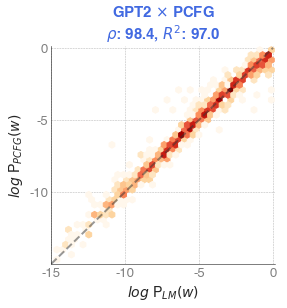

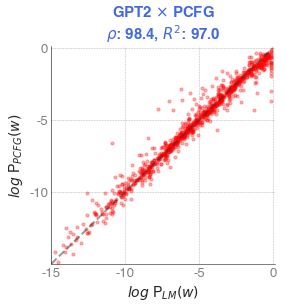

192.82091519272566 183.05507653285633
SpearmanrResult(correlation=0.9840994687614217, pvalue=0.0)
0.97


In [44]:
from sklearn.metrics import r2_score

plot_probs(lm_probs, pcfg_probs, "GPT2 $\\times$ PCFG", ylim=(-15,0.1), xlim=(-15,0.1), do_scatter=False, mincnt=1)
plot_probs(lm_probs, pcfg_probs, "GPT2 $\\times$ PCFG", ylim=(-15,0.1), xlim=(-15,0.1), do_scatter=True, alpha=0.3, s=10, color='red', save_as="gpt_pcfg")

print(np.exp(-np.mean(lm_probs)), np.exp(-np.mean(pcfg_probs)))
print(spearmanr(lm_probs, pcfg_probs))
print(np.round(r2_score(lm_probs, pcfg_probs), 3))

In [52]:
from nltk.draw.tree import TreeView


with open('corpora/eval_trees_10k.txt') as f:
    tree_corpus = [nltk.Tree.fromstring(l.strip()) for l in f]

tree = [tree for tree in tree_corpus if " ".join(tree.leaves()).startswith("Under the building")][0]

TreeView(tree)._cframe.print_to_file('output.ps')

In [48]:
for lm_p, pcfg_p, w in zip(lm_probs, pcfg_probs, tokens):
    if lm_p-pcfg_p < -1 and lm_p>-5:
        print(lm_p-pcfg_p, w, lm_p, pcfg_p)

-1.154679344242453 he__Under the building dealer he smiled . -3.3664629459381104 -2.2117836016956574
-1.0263950824649228 and__They saw Samantha to relish no one the Cobras thought and kissed his surroundings . -3.7475311756134033 -2.7211360931484805
-1.4807540753458568 ,__`` I even <apostrophe>ll to a radiant case suitcase , <apostrophe><apostrophe> I had loudly , to look really . -4.1038432121276855 -2.6230891367818288
-1.5307803987425856 and__`` But For the ex and , I desire to go over where no reason Scarlett . -4.715537071228027 -3.1847566724854417
-1.8010549778816163 ,__`` But For the ex and , I desire to go over where no reason Scarlett . -3.890613555908203 -2.089558578026587
-1.6360546611497284 ?__`` * On B4 are ? <apostrophe><apostrophe> -4.593310356140137 -2.9572556949904083
-1.4079660610954718 never__`` Yeah , at all , <apostrophe><apostrophe> the Captain <apostrophe>ve never worked . -4.886729717254639 -3.478763656159167
-1.3442139309400147 least__Everyone ... to with my mot

#### Optimal Perplexity Correlation

In [60]:
from collections import defaultdict


def get_model_prob_dict(fn: 'checkpoints/deberta_1M_64bsz/token_probs_eval.txt'):
    with open(fn) as f:
        lines = f.read().split('\n')

    sen2lm_probs = defaultdict(list)
    cur_sen = None

    for line in lines:
        if len(line) == 0:
            continue
        if not line[-1].isnumeric():
            cur_sen = line
        else:
            sen2lm_probs[cur_sen].append(float(line))

    return sen2lm_probs


def get_pcfg_prob_dict():
    with open('petrov/src/eval_sens_probs.txt') as f:
        lines = f.read().split('\n')

    sen2pcfg_probs = defaultdict(list)
    cur_sen = None

    for line in lines:
        if len(line) == 0:
            continue
        if line.startswith('Token:'):
            continue
        elif not line[-1].isnumeric():
            cur_sen = line
        else:
            sen2pcfg_probs[cur_sen].append(float(line))
            
    return sen2pcfg_probs


deberta_prob_dict = get_model_prob_dict('checkpoints/deberta_1M_64bsz/token_probs_eval.txt')
roberta_prob_dict = get_model_prob_dict('checkpoints/roberta_1M_32bsz/token_probs_eval.txt')
pcfg_prob_dict = get_pcfg_prob_dict()

In [14]:
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import r2_score


def get_probs(sen2lm_probs, sen2pcfg_probs):
    lm_probs = []
    pcfg_probs = []

    first_n = None
    skip_tokens = {tokenizer.unk_token_id}

    for sen, input_ids in zip(datasets['eval']['text'][:first_n], datasets['eval']['input_ids'][:first_n]):
        pcfg_sen = sen.replace("<apostrophe>", "'")

        sen_pcfg_probs = sen2pcfg_probs[pcfg_sen]
        sen_lm_probs = sen2lm_probs[sen]

        assert len(sen_pcfg_probs) == len(sen_lm_probs), f"{sen}\n{len(sen_pcfg_probs)},{len(sen_lm_probs)}"

        for input_id, lm_prob, pcfg_prob in zip(input_ids, sen_lm_probs, sen_pcfg_probs):
            if input_id not in skip_tokens:
                lm_probs.append(np.exp(lm_prob))
                pcfg_probs.append(pcfg_prob)


    lm_probs = np.array(lm_probs)
    pcfg_probs = np.array(pcfg_probs)

    lm_probs = np.log(lm_probs)
    pcfg_probs = np.log(pcfg_probs)

    return lm_probs, pcfg_probs


def plot_probs(
    lm_probs, 
    pcfg_probs, 
    model_name: str, 
    save_as: Optional[str] = None, 
    cmap = 'OrRd', 
    ymodel='PCFG', 
    ylim=(-20,0.1), 
    xlim=(-20,0.1), 
    do_scatter=False,
    mincnt=3,
    **plot_args,
):
    fig, ax = plt.subplots(figsize=(4,4))

    # sns.regplot(lm_probs, pcfg_probs, scatter_kws={'alpha':0.05, 's':2}, color='orange', line_kws={"color": "0.5", 'ls': '--', 'lw': 1})
    if do_scatter:
        ax.scatter(lm_probs, pcfg_probs, cmap=cmap, **plot_args)
    else:
        ax.hexbin(
            lm_probs, 
            pcfg_probs, 
            gridsize=40, 
            mincnt=mincnt,
            cmap=cmap,
            bins='log',
            **plot_args,
        )

    plt.xlabel(r'$log$ P$_{LM}(w)$', fontsize=14)
    plt.ylabel(r'$log$ P$_{PCFG}(w)$'.replace('PCFG', ymodel), fontsize=14)

    if ylim is not None:
        plt.ylim(*ylim)
    if xlim is not None:
        plt.xlim(*xlim)

    # Ticks
    plt.xticks(range(xlim[0],1,5), range(xlim[0],1,5))
    plt.yticks(range(xlim[0]+5,1,5), range(xlim[0]+5,1,5))

    ax.tick_params(
        axis='x', 
        which='major', 
        pad=-3,
        labelcolor="0.5",
    )
    ax.tick_params(
        axis='y', 
        which='major', 
        pad=-3,
        labelcolor="0.5",
    )

    # Grid
    ax.grid(color='0.7', linestyle='--', linewidth=0.5)

    # Spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.setp(ax.spines.values(), color="black", lw=.5)

    # Title
    corr, p = spearmanr(lm_probs, pcfg_probs)
    r2 = r2_score(lm_probs, pcfg_probs) * 100
    
    # plt.plot(np.linspace(xlim[0],0,10), pearsonr(lm_probs, pcfg_probs)[0] * np.linspace(xlim[0],0,10), c='0.2', linestyle='--', lw=2, alpha=0.5)
    plt.plot(np.linspace(xlim[0],0,10), np.linspace(xlim[0],0,10), c='0.2', linestyle='--', lw=2, alpha=0.5)
    plt.title(f"{model_name}\n" + f"$\\rho$: {corr*100:.1f}, $R^2$: {r2:.1f}", fontweight=600, color="royalblue", fontsize=15)
        
    if save_as is not None:
        plt.savefig(f"petrov/figures/{save_as}.pdf", bbox_inches="tight")
    
    plt.show()

# roberta_probs, pcfg_probs = get_probs(roberta_prob_dict, pcfg_prob_dict)
# deberta_probs, pcfg_probs = get_probs(deberta_prob_dict, pcfg_prob_dict)


# plot_probs(roberta_probs, pcfg_probs, "RoBERTa $\\times$ PCFG")
# plot_probs(deberta_probs, pcfg_probs, "DeBERTa $\\times$ PCFG", save_as='deberta_pcfg')
# plot_probs(deberta_probs, roberta_probs, "DeBERTa $\\times$ RoBERTa", ymodel='LM')

In [14]:
np.exp(-np.mean(pcfg_probs))

63.861566735728076

In [431]:
print(f"RoBERTa {np.exp(-np.mean(roberta_probs)):.2f}")
print(f"DeBERTa {np.exp(-np.mean(deberta_probs)):.2f}")
print(f"\nPCFG\t{np.exp(-np.mean(pcfg_probs)):.2f}")

RoBERTa 78.39
DeBERTa 78.03

PCFG	63.86


#### Corpus Size & Model Size PPLs

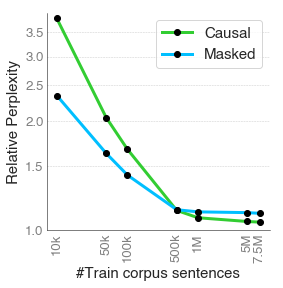

In [564]:
corpus_sizes = [10000, 50000, 100000, 500000, 1000000, 5000000, 7500000] 

ppls_masked = [149.77532211296602, 103.9383332000615, 90.57802702472031, 72.73485451820352, 71.76024144269196, 71.40987922893244, 71.09663845955495]
masked_ppl = 63.86

ppls_causal = [689.4168767942786, 368.5242303842697, 301.4738534262417, 204.72539303616804, 195.47440889690478, 190.89499043555816, 190.1178393611341]
causal_ppl = 190.1178*(183.1/192.8)  #184.54

plt.figure(figsize=(4,4))
ax = plt.gca()

relative_ppl = True

if relative_ppl:
    ppls_masked = np.array(ppls_masked) / masked_ppl
    ppls_causal = np.array(ppls_causal) / causal_ppl
    plt.plot(corpus_sizes, ppls_causal, 'o-', lw=3, color="limegreen", markerfacecolor='black', markeredgecolor='black', label='Causal')
else:
    plt.axhline(masked_ppl, ls='--', c='0.5')
    plt.text(10_000, 67, 'Optimal perplexity', color='0.6', fontsize=11)

plt.plot(corpus_sizes, ppls_masked, 'o-', lw=3, color="deepskyblue", markerfacecolor='black', markeredgecolor='black', label='Masked')
plt.xscale('log', basex=2)
plt.xticks(corpus_sizes, ['10k', '50k', '100k', '500k', '1M', '5M', '7.5M'], rotation=90)

ax.tick_params(
    axis='x', 
    which='major', 
    pad=-3,
    labelcolor="0.5",
)
ax.tick_params(
    axis='y', 
    which='major', 
    pad=-3,
    labelcolor="0.5",
)
ax.tick_params(
    axis='y', 
    which='minor', 
    labelsize=0,
    labelcolor="white",
)

# Grid
ax.grid(False)
ax.grid(color='0.8', linestyle='--', linewidth=0.5, axis='y')

# Spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.setp(ax.spines.values(), color="black", lw=.5)

if relative_ppl:
    plt.ylabel("Relative Perplexity", fontsize=15)
else:
    plt.ylabel("Perplexity", fontsize=15)
plt.xlabel("#Train corpus sentences", fontsize=15)

if relative_ppl:
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(1,ymax)

    plt.yscale('log')
    plt.yticks(np.arange(1,4,0.5), np.arange(1,4,0.5))
    plt.legend(fontsize=15)

plt.savefig(f"petrov/figures/corpus_sizes.pdf", bbox_inches="tight")

plt.show()

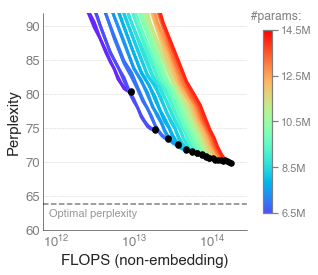

In [592]:
ppls1 = [[120.66960889002816,  103.49900868932038,  96.69870080674075,  92.52930531823077,  89.80902700848628,  88.10102959004108,  86.46954562815017,  84.92392826082454,  83.7184315629908,  82.59712932246337,  81.64640246125713,  81.05235118503661,  80.62119223448624,  80.44702228041281,  80.43115550316072], [111.52229548603647,  96.25918047460618,  90.0063102992839,  86.2154097178684,  84.03354839311997,  82.47836341457828,  80.51085790757641,  79.31938312195615,  77.99085468718174,  76.85299291591339,  76.06578332714093,  75.4744189128096,  75.11731026278775,  74.89951516319357,  74.8818655338089], [109.25532212401787,  94.2504199747598,  88.20299549976059,  84.56943045325775,  82.53427274423261,  80.70334305485943,  78.91683552264298,  77.92778320012113,  76.57154617950653,  75.44720337570344,  74.62144108413229,  73.9821499417966,  73.61244918812422,  73.42849042577872,  73.40962725487034], [107.55380402951049,  93.01168903516545,  87.52990186497838,  83.90118999005183,  81.88966272101847,  80.27986263043813,  78.06781202595,  77.11845645607725,  75.89372128403981,  74.68399028590461,  73.82035863450895,  73.24161213024279,  72.84178342902,  72.63504836201975,  72.61931250946606], [106.01947538680479,  92.32154155330998,  86.92671649992016,  83.12734235673062,  81.33665846271099,  79.64106938232416,  77.60398789709022,  76.41239714722373,  75.23032426668163,  74.08657422429225,  73.22595558457424,  72.58195421088253,  72.21218654718345,  72.02192313141197,  72.0052240202244], [105.80936741286055,  91.97721474636799,  86.37092892201812,  82.90690452336462,  81.06685965067652,  79.41032970611256,  77.34441132580662,  76.16872615584037,  75.02898128513989,  73.75732261552655,  72.88076933060844,  72.26559922437028,  71.90201282558124,  71.68578227332277,  71.67060792606881], [104.81303704904738,  91.50041852270829,  85.94897838324444,  82.48202633990904,  80.63389155327658,  78.95196693453944,  77.02426937576655,  75.90755783268156,  74.70153666544459,  73.41319612964435,  72.53794842370347,  71.90980150886986,  71.51150171910403,  71.31476716759417,  71.29766716761011], [104.37141069787022,  91.4674298191761,  85.97130117073544,  82.4616950215775,  80.57515529140053,  79.08783059751855,  76.89898535398336,  75.79060592147889,  74.55097447544604,  73.25956971162208,  72.45347660267586,  71.77285931348067,  71.3986079291389,  71.18556207597322,  71.16491888105115], [104.19983504002307,  91.00709457671799,  85.677993118173,  82.55536358769699,  80.22593706419428,  78.84473858801724,  76.81679697020782,  75.69031708796302,  74.38150380635058,  73.05162987903516,  72.19027246231913,  71.53066243862904,  71.12528602626274,  70.90620017423176,  70.88819921609135], [103.8671117887971,  91.19021408664194,  85.76565693593024,  82.2043776778064,  80.08917908960974,  78.92356545662965,  76.56798244499323,  75.26770295287102,  74.17427003757437,  72.83950560096332,  71.94256193118773,  71.28537809261563,  70.87967405540743,  70.67729512500728,  70.65545118488711], [103.70582414000539,  90.9630726705187,  85.79336835352916,  81.95240050757675,  80.04029084306143,  78.67064229197429,  76.47366547001545,  75.27614154333439,  74.08780776715817,  72.74364494268501,  71.89865303152341,  71.2005415194964,  70.83046708731926,  70.608349818001,  70.58961390461268], [103.9088275444075,  90.72219474959269,  85.69190411115287,  82.24014371120566,  79.78595498783322,  78.48320659687741,  76.35854216488818,  75.1286671498847,  73.82226174298957,  72.60247112125663,  71.72889374033532,  71.05045301012353,  70.60453254231552,  70.39689299016982,  70.37353525293679], [103.51779902906881,  90.58646117939428,  85.25621652477459,  81.71040939095674,  79.93648687946077,  78.3992434633457,  76.5101173151874,  75.02156926622423,  73.98826392822552,  72.48743052071238,  71.67684466276313,  70.96166524087946,  70.56384296483601,  70.33199407471693,  70.31213789828713],[103.2765461974872,  91.43971333012703,  85.26952771233792,  81.92118388966983,  80.0938460853424,  78.59431882136874,  76.45677292926884,  75.1559250480806,  73.90758923555904,  72.60029536181958,  71.70147521974064,  71.02458523440345,  70.57019142132006,  70.34443185340528,  70.32496601200718], [102.82367911903195,  90.73427534323325,  85.57242095942118,  81.73426215915116,  79.76586510539157,  78.4120503896296,  76.39822073460336,  75.01088757082047,  73.89048621690412,  72.48003955604516,  71.63502692464067,  70.91591397586146,  70.49479803730527,  70.27620579989501,  70.25421864524063], [102.83588250821202,  90.67322409918924,  85.64725585304451,  81.69541818854748,  79.9579541442392,  78.40825003204768,  76.32238443141911,  75.14121277869187,  73.90678762600442,  72.59658112947737,  71.66612138859509,  70.95889402494969,  70.52101901318866,  70.29273687498069,  70.27219403597208], [103.66024883525162,  91.4129286085133,  85.45579652513742,  81.8972994514091,  79.67886849511771,  78.39011475285055,  76.2666724483598,  74.94287587770063,  73.77455104160428,  72.3682755262538,  71.49386796036819,  70.8150705108994,  70.37663941212254,  70.13672955193914,  70.11501094993784], [102.89102318541723,  91.06943690461131,  85.64965242901411,  82.12682831479154,  79.81875271199,  78.34315157302404,  76.23290833672064,  74.88544153755085,  73.77917673571135,  72.32685805855219,  71.46989222253464,  70.72341268534962,  70.32391474332117,  70.074383307756,  70.05197984571095], [102.85546670571217,  90.60798876345957,  85.54179140120229,  81.88209125212606,  79.99955224637085,  78.4072168185029,  76.4163418528235,  74.75950173022231,  73.6210962204252,  72.27417452687021,  71.3260102791538,  70.6558577551104,  70.20999166077947,  69.95056477919547,  69.93324333690767]]
ppls2 = [[117.63603195261717,  102.17064265538913,  96.2777886873714,  92.71230341413494,  90.59851651650074,  88.07839439029425,  86.17729911840851,  84.79512164435039,  83.76018321005712,  82.27900461019003,  81.57746529515603,  80.83648391950656,  80.57089182088853,  80.36488918311484,  80.35056443159506], [109.73123945948832,  95.5849010786032,  89.99523728772046,  86.12537095505678,  84.10103980397088,  81.9816773830054,  80.3337682297286,  78.95388380303586,  78.00156836517553,  76.64036374465934,  75.90512444593273,  75.256562008264,  74.93741656430886,  74.7792997541325,  74.76585249744055], [108.00054953454612,  93.8124468268435,  88.55059386493824,  84.91933154924291,  83.16782362740057,  80.98326620421656,  79.24282557710991,  77.8660914820217,  76.78197047359578,  75.45996008518068,  74.72701393918688,  74.1344933040963,  73.76558540391102,  73.59068759102269,  73.5820585367642], [106.48140618172116,  92.9779158920702,  87.7951441241706,  83.7888604133259,  82.06261879113286,  79.90578222413943,  78.21395116620772,  76.78416042815807,  75.80251964237725,  74.49561210129275,  73.69965719906571,  73.05717853201298,  72.7243605492641,  72.55234243882265,  72.5390051870566], [105.3389897725951,  92.55714384615236,  86.87316222927171,  83.27946455513221,  81.39887097094545,  79.20103394109091,  77.52576548314565,  75.92544208348382,  75.08990864817359,  73.81211956451457,  73.04112655091414,  72.35382340184248,  72.02088765603932,  71.84175626586739,  71.83122386590885], [103.9161158560468,  91.75318568926362,  86.5842159601318,  82.67559776588787,  81.28004718524348,  79.1163601535743,  77.41798680282217,  75.8921695239127,  74.92201959637123,  73.49070757748542,  72.7602418444907,  72.06209668993115,  71.70996679090311,  71.55115884529943,  71.5315277088141], [104.36109523965918,  91.32412883230074,  86.55861387484352,  82.78630448296347,  80.97531625281438,  79.04325078969232,  77.34109853786131,  75.58018422094072,  74.71989007404517,  73.35900380617493,  72.63100210080961,  71.89150258631885,  71.54123186798937,  71.34035953431079,  71.32599515767451], [103.4794894523422,  92.24368690013902,  86.44659827245705,  82.59296445339882,  80.87960266131464,  78.64528202636563,  76.96637876560479,  75.4272371392683,  74.47520413461594,  73.09076573954599,  72.38974617860757,  71.58354305074053,  71.22248149334551,  71.04466621224053,  71.03191150472122], [104.05351678526822,  90.87057324396666,  85.9136023360933,  82.27477395331303,  80.78797821396691,  78.45238988545104,  76.79093810295355,  75.058640110342,  74.23078317824282,  72.89220017241833,  72.11424299201698,  71.3571915718414,  71.00233367711752,  70.82043221053719,  70.80781877406893], [102.33556588952237,  91.20685540204505,  86.08922975565918,  82.34918840596296,  80.8989614684568,  78.42249373463413,  76.83662526203248,  75.11032996812763,  74.26010555287644,  72.80379739263464,  72.06553506627303,  71.24388457602396,  70.88821546065245,  70.7083526689198,  70.69348151447836]]    
# ppls1.append([106.37616636329597,92.79321328274175,86.83778235653904,82.75881374206537,80.57135768418729,78.7794853017367,76.43326762933016,74.71877828207225,73.23307475655001,71.6305699945959,70.51389364051131,69.76254286186116,69.16164973864572,68.89090726194864,68.86135617468447])

checkpoints = np.array(list(range(1000, 15000, 1000)) + [14839])

plt.figure(figsize=(4.1,4))

cmap = 'rainbow'
offset = 0

for ppls in [ppls1,ppls2]:
    palette = sns.color_palette(cmap, len(ppls1))

    for nlayers, (layer_ppls, c) in enumerate(zip(ppls, palette), start=1):
        flops = checkpoints*(64*2*((4_823_040*nlayers)))  #31_899_648
        if nlayers == 20:
            print(nlayers)
            flops = checkpoints*(64*2*((31_899_648*nlayers)))
        plt.plot(flops, np.array(layer_ppls)-offset, lw=3, c=c)

        plt.scatter(flops[-1], layer_ppls[-1]-offset, c='black', zorder=100, s=30)
    

plt.axhline(63.86-offset, ls='--', c='0.5')

plt.ylim(60,92)
xmin, xmax = min(flops)*0.11, max(flops)*3

plt.xscale('log')
plt.xlim(xmin, xmax)

ax = plt.gca()


ax.tick_params(
    axis='x', 
    which='major', 
    pad=-3,
    labelcolor="0.5",
)
ax.tick_params(
    axis='y', 
    which='major', 
    pad=-3,
    labelcolor="0.5",
)

plt.text(xmin*1.2, 62, 'Optimal perplexity', color='0.6', fontsize=11)

# Grid
ax.grid(False)
ax.grid(color='0.8', linestyle='--', linewidth=0.5, axis='y')

# Spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.setp(ax.spines.values(), color="black", lw=.5)

plt.ylabel("Perplexity", fontsize=15)
plt.xlabel("FLOPS (non-embedding)", fontsize=15)


nparams = 6141184 + 395776*(np.linspace(1,len(ppls1)+2,5))

norm = mpl.colors.Normalize(vmin=0,vmax=10)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = plt.colorbar(sm, ticks=np.linspace(1, 10, 5), 
             boundaries=np.arange(.99, 10.01, .01), fraction=0.04, pad=0.07)

cb.ax.set_yticklabels([f"{p / 1_000_000:.1f}M" for p in nparams])
cb.outline.set_edgecolor("0.5")
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color="0.5", fontsize=11)
cb.ax.yaxis.set_tick_params(color="0.5")
cb.ax.set_title('     #params:', color="0.5", fontsize=12, pad=10)

plt.savefig(f"petrov/figures/model_sizes.pdf", bbox_inches="tight")

# plt.ylim(63,75)
# plt.yscale('log')

plt.show()

In [570]:
sum(p.numel() for p in model.parameters()) - sum(p.numel() for p in model.model.decoder.layers.parameters())

# 395776

AttributeError: 'DebertaForMaskedLM' object has no attribute 'model'

In [576]:
sum(p.numel() for p in model.parameters()) - sum(p.numel() for p in model.deberta.encoder.layer.parameters()), sum(p.numel() for p in model.deberta.encoder.layer.parameters())

(13060465, 42045440)

In [364]:
np.arange(4823040, nparams[-1]+1, nparams[-1]/10)

array([4.82304000e+06, 1.69946112e+07, 2.91661824e+07, 4.13377536e+07,
       5.35093248e+07, 6.56808960e+07, 7.78524672e+07, 9.00240384e+07,
       1.02195610e+08, 1.14367181e+08])

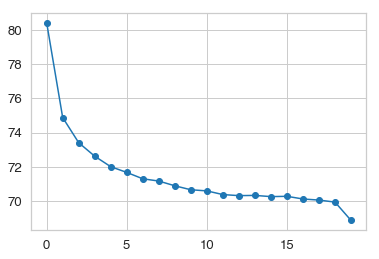

In [583]:
plt.plot([x[-1] for x in ppls1], 'o-')

In [181]:
sum(map(len,datasets['eval']['input_ids'])) / len(datasets['eval'])

11.7111

In [567]:
from fvcore.nn import FlopCountAnalysis

model.eval()

input_ids = torch.tensor(datasets['eval']['input_ids'][2])[:12].unsqueeze(0)
print(input_ids.shape)
flops = FlopCountAnalysis(model, input_ids)

flops.by_module()

torch.Size([1, 12])


/home/jaap/miniconda3/lib/python3.8/site-packages/transformers/models/deberta/modeling_deberta.py:663: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scale = torch.sqrt(torch.tensor(query_layer.size(-1), dtype=torch.float) * scale_factor)
/home/jaap/miniconda3/lib/python3.8/site-packages/transformers/models/deberta/modeling_deberta.py:724: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_query_layer /= torch.sqrt(torch.tensor(pos_query_layer.size(-1), dtype=torch.float) * scale_factor)
Unsupported operator aten::embedding encountered 1 time(s)
Unsupported operator aten::mean encountered 82 time(s)
Unsupported operator aten::sub encountered 123 time(s)
Unsupported operator aten::pow encou

Counter({'': 788140032,
         'deberta': 637992960,
         'deberta.embeddings': 0,
         'deberta.embeddings.word_embeddings': 0,
         'deberta.embeddings.LayerNorm': 0,
         'deberta.embeddings.dropout': 0,
         'deberta.encoder': 637992960,
         'deberta.encoder.layer': 637992960,
         'deberta.encoder.layer.0': 31899648,
         'deberta.encoder.layer.0.attention': 25608192,
         'deberta.encoder.layer.0.attention.self': 22462464,
         'deberta.encoder.layer.0.attention.self.in_proj': 9437184,
         'deberta.encoder.layer.0.attention.self.pos_dropout': 0,
         'deberta.encoder.layer.0.attention.self.pos_proj': 6291456,
         'deberta.encoder.layer.0.attention.self.pos_q_proj': 6291456,
         'deberta.encoder.layer.0.attention.self.dropout': 0,
         'deberta.encoder.layer.0.attention.output': 3145728,
         'deberta.encoder.layer.0.attention.output.dense': 3145728,
         'deberta.encoder.layer.0.attention.output.LayerNorm':

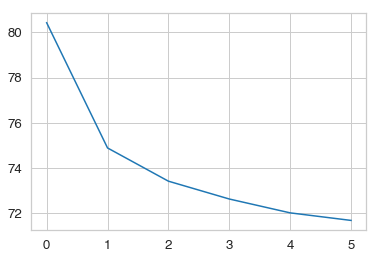

In [112]:
plt.plot(np.array(ppls)[:,-1])

In [35]:
palette[0]

TypeError: 'ListedColormap' object is not subscriptable

(-4, 4)

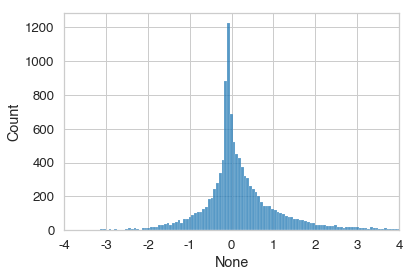

In [103]:
sns.histplot(pcfg_probs - lm_probs)
plt.xlim(-4,4)

In [116]:
np.exp(-pcfg_probs.sum() / len(pcfg_probs)), np.exp(-lm_probs.sum() / len(lm_probs))

(69.72188217216862, 85.19853827383297)

In [149]:
def get_prob(sen, idx):
    input_ids = tokenizer(sen, return_tensors='pt')['input_ids']
    orig_token = input_ids[0,idx].item()
    input_ids[0,idx] = tokenizer.mask_token_id

    with torch.no_grad():
        return model(input_ids).logits.log_softmax(-1)[0,idx,orig_token].item()

In [153]:
sen = 'until he might sell a different girl on here , this be faintly skilled without directly .'

for idx, (w, pcfg_p, lm_p) in enumerate(zip(sen.split(), sen2prob_pcfg[sen], sen2probs[sen])):
    print(f'{w:<15}{np.log(pcfg_p):<12.5f}{get_prob(sen, idx):.5f}')

#### Probing Results

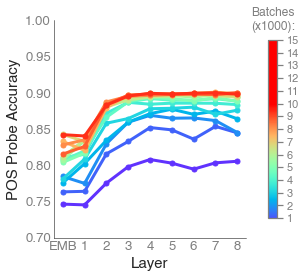

In [156]:
import matplotlib as mpl

prev_test_mccs = [[0.7781217339861507,  0.7399300864351005,  0.7619810743491864,  0.7694698792098812,  0.7773937410161368,  0.7728437337974193,  0.7705404427101413,  0.769790493771578,  0.7699527288861484], [0.7738317096761972,  0.7805095715919909,  0.8027333726478112,  0.8346083073743539,  0.8557193470033051,  0.8516467404435349,  0.8106316742448345,  0.848452461345941,  0.815790490609408], [0.7862219750630914,  0.7730160304819742,  0.8207639879258902,  0.8532801042556676,  0.8633353719163489,  0.8577995459448478,  0.8586930746625819,  0.8575600924226989,  0.8564147314224119], [0.7896901897040869,  0.8019269878184204,  0.8198548070266554,  0.850399941978929,  0.8698966322396724,  0.8670869970460876,  0.8677894409033238,  0.863962264377046,  0.8267460599054741], [0.7950647020390645,  0.7967072756306349,  0.8430426633162525,  0.8659472063945614,  0.8728566843615604,  0.86900962783275,  0.8682815564028069,  0.8632791638541439,  0.8622234634735362], [0.8413479001723702,  0.8020496171124895,  0.8531303166845255,  0.869808373551316,  0.8737126291436295,  0.872143478813561,  0.8716939806205735,  0.8706700169706133,  0.8712375359430982], [0.8424212341244592,  0.8028758367137393,  0.850883333083053,  0.8740521056990046,  0.8799538119238693,  0.8770285564021368,  0.8767281812405268,  0.8785274107373587,  0.8744239709794727], [0.7987326898710844,  0.8078869798427452,  0.8617674507088525,  0.8764649792111059,  0.8801427768280355,  0.8780386981062193,  0.8775157149907152,  0.8769545476373313,  0.8730997470036094], [0.800114549030752,  0.8275221066678097,  0.8663759164158247,  0.8792505770918992,  0.8841097096251231,  0.8801342556549949,  0.8766108463867957,  0.8772612083006668,  0.8806452671612116], [0.8005921300757265,  0.8345245921017834,  0.8652826607298705,  0.8774342028311666,  0.8794085176333724,  0.8807258819675553,  0.8784552239247857,  0.8826338994634195,  0.8820845230716399], [0.842063411432168,  0.8102455610700897,  0.86495811737269,  0.8766564180337317,  0.8818208026000413,  0.8819081404118776,  0.8816929722568071,  0.8824536062229413,  0.8814184920518272], [0.801987939538379,  0.81037674500864,  0.862908465456455,  0.8800958462777408,  0.8836089375576919,  0.8862056290288512,  0.884181026758125,  0.884682674832662,  0.8831151268005228], [0.8024874512224227,  0.8121619162327608,  0.8684283487211535,  0.8821208234884841,  0.8835600357278927,  0.8834479430267356,  0.884340960890038,  0.8836945098822868,  0.8846151343169977], [0.800054154709005,  0.8111279143449334,  0.8635763748046905,  0.8796757889708743,  0.8853186688808051,  0.8834194407377375,  0.8835689124960542,  0.8826473988628796,  0.8829853732081486], [0.8437379139235928,  0.8133558152958945,  0.8651848118670539,  0.8801915197729938,  0.8835144725369931,  0.8837985815955279,  0.883410041114421,  0.8820605498264378,  0.8835184621167641]]
prev_test_mccs2 = [[0.7682770683233778,  0.7903715724001127,  0.7958657272032518,  0.8418379310349082,  0.8343140716807467,  0.8298740092707816,  0.8270923833125235,  0.8269698367202577,  0.8296467551606383], [0.783467936132751,  0.7977107603874499,  0.8555578994817719,  0.8628233988738595,  0.8638414869468027,  0.8664996583318108,  0.8681538373329427,  0.8694931441516005,  0.8650810225217296], [0.8193162550259637,  0.8198494597167587,  0.8534577367553645,  0.8748841212227049,  0.8764359993216253,  0.8765459935062277,  0.8799225145273332,  0.8708236641384128,  0.8442760153321707], [0.7999428714802681,  0.8477810594418285,  0.8490765647295259,  0.8586895967300896,  0.865010206005833,  0.8863161077170344,  0.8632097142866129,  0.887014900304858,  0.891770965138599], [0.8000221443670068,  0.8212940475614006,  0.8714829350177324,  0.8859288827148692,  0.8848324270740338,  0.8912817287283549,  0.8914714340176068,  0.8929162834152222,  0.8887503468749515], [0.8078253016798819,  0.8252862329590483,  0.8914536845865024,  0.9073352637977686,  0.8963680934873154,  0.8974693853951089,  0.8971736166226356,  0.8980957084777939,  0.8919935170193075], [0.8112927664548697,  0.8661148110076673,  0.8654097975746272,  0.8992481707278993,  0.9000707808211641,  0.9011721035174183,  0.9015837454564429,  0.9007675531257494,  0.8976953195165566], [0.8421445392254336,  0.8533998599462261,  0.910755073666319,  0.9051549903242565,  0.9068268317570473,  0.903560138872822,  0.9005167979631655,  0.9105932276381598,  0.8971630957102585], [0.8501061332455131,  0.8898432977436143,  0.9064439275293809,  0.9018755877096678,  0.903383084812136,  0.9115512193392378,  0.909635093222844,  0.9160071391330314,  0.9016060260377299], [0.8189438219256552,  0.8611194284615916,  0.8949339863322864,  0.9019309065010234,  0.9063937506776255,  0.9088241209620664,  0.9107806756164846,  0.9033118041520037,  0.9026328128267904], [0.8719807088476856,  0.8839969570748235,  0.9082966528289286,  0.9089270785129943,  0.9143957453023894,  0.9118705732352482,  0.9134803799353085,  0.909194589239948,  0.9073345984511239], [0.8688535710539957,  0.8437934856772628,  0.9016359638024778,  0.912563029554997,  0.9083084522452562,  0.9072704812658189,  0.9100555179637037,  0.9138427386287314,  0.9099668624575582], [0.8687497204297763,  0.8795893704453132,  0.909902422518666,  0.9067440881404699,  0.9123092817148424,  0.910191410776963,  0.9137204772493251,  0.9063895205854305,  0.911363946306826], [0.8167458772085919,  0.8824178539592905,  0.9031160520543271,  0.9148164824620525,  0.9129584024069178,  0.9130881839833188,  0.9093544015160488,  0.9082140722785591,  0.9156810587598547], [0.8703199431776727,  0.8782095738883541,  0.8968924179221611,  0.9100820597466659,  0.9121902274257321,  0.9104644382770397,  0.9134920412712928,  0.913334062619691,  0.9104131367648658]]
prev_test_mccs3 = [[0.6929590364330894,  0.705983085300784,  0.7685801733449628,  0.7830709348783507,  0.8122946227997772,  0.8062880470552837,  0.7864972193512726,  0.813582001116261,  0.8172243408367431], [0.7328497547619187,  0.7141561375498913,  0.7892177934039369,  0.8013594140081202,  0.8367241842034918,  0.8285933547247429,  0.8295290349200132,  0.8430925093593921,  0.8536027201630423], [0.7483257046212813,  0.732307546311126,  0.8149213978754957,  0.8503295562505181,  0.8671774746419377,  0.8605683192765282,  0.8574664054950079,  0.8567690007504947,  0.8350587635615295], [0.7374599504057904,  0.7575984048909136,  0.8347612397447769,  0.8695030096870832,  0.8789623124849022,  0.8787343528361575,  0.8799683205281988,  0.8732548108604559,  0.8741572733955929], [0.7484136537352585,  0.8080039424366705,  0.8597027042832291,  0.8417856947610023,  0.8766121244862011,  0.875834888440551,  0.8810202987478114,  0.8548542281716717,  0.8771758948384796], [0.7822421826596331,  0.8184043252542652,  0.8709409161082723,  0.8834654491760109,  0.882884582085169,  0.8876770329557085,  0.888389159942987,  0.8880866053627057,  0.8880681615006517], [0.7665044356486536,  0.7909150995355655,  0.8824898938709305,  0.889763667513206,  0.8960898135091194,  0.8913277572615441,  0.8915158897589213,  0.8962521228535132,  0.8936909288561391], [0.7711316534680892,  0.7890871770306725,  0.880932634048253,  0.8855683444361896,  0.8945882058363088,  0.8948773213093928,  0.8883730578312417,  0.8929075236555866,  0.8940596749476545], [0.772977470529182,  0.7845886411970581,  0.8839934432486458,  0.8942469135126514,  0.8988772722657128,  0.898456562663529,  0.8954088826385662,  0.9001234746435512,  0.899328744398557], [0.8140338450019136,  0.811105560208945,  0.8815532094380949,  0.8919129250137753,  0.8974279891961794,  0.8971868183030327,  0.9002379640913805,  0.9012872205030126,  0.8979027111563437], [0.8137842530019671,  0.8047365678361301,  0.8834493039305698,  0.8956133314073852,  0.9021124645305474,  0.9005514827779898,  0.8999723011706124,  0.9024334964195851,  0.8969084987442763], [0.8278626448323024,  0.8079932264129596,  0.8735288497060821,  0.8980022953370176,  0.8990861097634645,  0.9012227796495983,  0.9037369434802486,  0.9042320242155049,  0.9031327818689939], [0.8129192731766468,  0.8140399230131488,  0.8841774975420238,  0.8971047888760226,  0.8938407016321097,  0.8989376509995597,  0.9012821718262962,  0.9026723711433032,  0.9021975055754863], [0.8297528318544478,  0.7845757379905133,  0.88463260041273,  0.896186399859738,  0.896868214520064,  0.8986111237582858,  0.9012493498878194,  0.9029034214860286,  0.9025010895791632], [0.8129449106192198,  0.8298441885154632,  0.8873373280794049,  0.8966382737966513,  0.9024665632980472,  0.9006229723828694,  0.9013755181955968,  0.9049572813988226,  0.9005190999776406]]
prev_test_mccs4 = [[0.814851632497883,  0.827369530717667,  0.8591196353349788,  0.8263451441644529,  0.847219999001939,  0.7626581836291914,  0.78116723681304,  0.7790923130668661,  0.7843534453174775], [0.8402988764457293,  0.8171654223985494,  0.8632020471449656,  0.8705610986480325,  0.8680435781343852,  0.8710061128389787,  0.8633975738536549,  0.8660677411071286,  0.8324983858319223], [0.8535593705513501,  0.855856643813536,  0.8959215817227008,  0.8964183708594065,  0.899264920430089,  0.9057659659136539,  0.8994355274827842,  0.8948641825508659,  0.8735728195452644], [0.8546593830064088,  0.8600810115548159,  0.8934915283205787,  0.9049686164464493,  0.9042447349369451,  0.901743307012877,  0.9052949121500877,  0.9044450256660225,  0.9024237912535447], [0.8542393719732811,  0.862614013974902,  0.8874081840500861,  0.9118458313898055,  0.9154444930679744,  0.9117721188271523,  0.9148325204976949,  0.9177923393788217,  0.9153362971765668], [0.8583316648462912,  0.8626126844651026,  0.9000021677720987,  0.9135095698687242,  0.9140592400838741,  0.9168253358329075,  0.9077481854099206,  0.9063030370173236,  0.9028935712433735], [0.8745807887836486,  0.8649523332644427,  0.9040611722081453,  0.9118332493485587,  0.9135306255030702,  0.9075107010139353,  0.9049560133968961,  0.9087714877884211,  0.9082942183257944], [0.86493811150864,  0.8678599547810978,  0.9079035323092693,  0.9167611767527327,  0.9161442684505898,  0.91579650814628,  0.9177668143357397,  0.9056190538830544,  0.9119160067347666], [0.8653216331497303,  0.8704481153755288,  0.9075720332579099,  0.9139175034974806,  0.9139833154531855,  0.9213717506559608,  0.9162392905452126,  0.9201714535483536,  0.8968945284595168], [0.8677277932255351,  0.8785234981400143,  0.9093884057684077,  0.9210361056904659,  0.9257879441213142,  0.9231431591223666,  0.9237537075655763,  0.9225090310164967,  0.9216702807685275], [0.8604368992393672,  0.8767604363452783,  0.9126032989675443,  0.9198306718319733,  0.9291608129517357,  0.9276189439429561,  0.9303784555566087,  0.9273348763608544,  0.9237391141764784], [0.8667084664307545,  0.8765316296167873,  0.9133267011839443,  0.924828813591901,  0.9231219854067653,  0.929789745619919,  0.9272218157540328,  0.9269620625894484,  0.9218377141635412], [0.867849022413624,  0.8790889998003966,  0.9137937208112792,  0.9235131024046623,  0.9271994046581283,  0.9268582006870857,  0.9241223589079771,  0.924573052991474,  0.9144442260789157], [0.8683568515822613,  0.8767399412588536,  0.9159996432387272,  0.9252931449285537,  0.9247529023264066,  0.92912387586087,  0.9298132017299224,  0.9258484179959754,  0.9206846173524023], [0.5442604828018175,  0.8767097718849968,  0.913762825038108,  0.8930480842351234,  0.9231203586111519,  0.9283622032600337,  0.9283662106509177,  0.9253514741530342,  0.9091761846063707]]

avg_test_mccs = np.mean(np.array([prev_test_mccs, prev_test_mccs2, prev_test_mccs3]), axis=0)

# plt.figure(figsize=(4,4))

# nsteps, nlayers = avg_test_mccs.shape

# palette = sns.color_palette('rainbow', nlayers)
# for i, mcc_scores in enumerate(avg_test_mccs.T):
#     plt.plot(mcc_scores, 'o-', lw=2, markersize=4, c=palette[i])

# plt.grid(False)
# plt.xticks(range(nsteps), range(1, 16))
# plt.show()


plt.figure(figsize=(4,4))
ax = plt.gca()

palette = sns.color_palette('rainbow', nsteps)
for i, mcc_scores in enumerate(avg_test_mccs):
    plt.plot(mcc_scores, 'o-', lw=3, markersize=5, c=palette[i])


cmap = 'rainbow'
norm = mpl.colors.Normalize(vmin=0,vmax=10)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = plt.colorbar(sm, ticks=np.linspace(1, 15, 15), 
             boundaries=np.arange(.99, 15.01, .01), fraction=0.04, pad=0.1)

cb.ax.set_yticklabels(range(1,16))
cb.outline.set_edgecolor("0.5")
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color="0.5", fontsize=11)
cb.ax.yaxis.set_tick_params(color="0.5")
cb.ax.set_title('Batches\n(x1000):', color="0.5", fontsize=12, pad=10)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.setp(ax.spines.values(), color="black", lw=.5)

plt.grid(False)
plt.xticks(range(9), ['EMB'] + list(range(1,9)))
plt.ylim(0.7,1)
ax.tick_params(
    axis='x', 
    which='major', 
    pad=-3,
    labelcolor="0.5",
)
ax.tick_params(
    axis='y', 
    which='major', 
    pad=-3,
    labelcolor="0.5",
)
plt.xlabel("Layer", fontsize=15)
plt.ylabel("POS Probe Accuracy", fontsize=15)
# plt.title("POS Probing ")
plt.savefig(f"petrov/figures/pos_learning_dynamics.pdf", bbox_inches="tight")

plt.show()


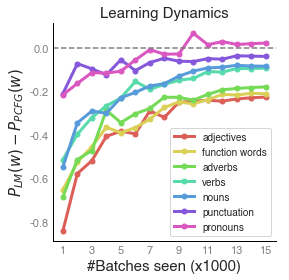

In [155]:
results = {'pronouns': [-0.21485567781159792, -0.16253604107528355, -0.11221505288377907, -0.11525188810247841, -0.10620988879200864, -0.0546974969182102, -0.0071303759994222095, -0.028098341449030378, -0.026988922492020263, 0.06818637873822622, 0.015609377042225899, 0.029783964951813326, 0.016566525610047365, 0.020257696986371473, 0.023047484195032088] ,
'punctuation': [-0.20942898043743824, -0.07140621765019135, -0.09528669808075658, -0.12287833610727784, -0.05391077905550584, -0.10325178001060184, -0.06656889703991506, -0.04661744263984299, -0.060185061860255545, -0.06198079310570477, -0.0484757381602284, -0.05105561202756124, -0.03538809947921136, -0.036887118454062603, -0.03835967703709127] ,
'nouns': [-0.5467154645478755, -0.3437400495803071, -0.2892469481923782, -0.2994588764526405, -0.2285544157784927, -0.2035382380167047, -0.17405600179044195, -0.16353737931561826, -0.1290393373208022, -0.1059162578350332, -0.09129477311968179, -0.08778450460412365, -0.07902180440363184, -0.08254608691966586, -0.083130683930362] ,
'verbs': [-0.5130369016674137, -0.39581018580978866, -0.31905301303517536, -0.2655840139992466, -0.22918597347514733, -0.15353097233241944, -0.18938026908228553, -0.1672230408088077, -0.14760260089638438, -0.13974822093040326, -0.10775665909696826, -0.11063394125221077, -0.09400799668703809, -0.09399626550066767, -0.0921933586448797] ,
'adverbs': [-0.6840970118846513, -0.5121965710164059, -0.4711790182498488, -0.28570130249868403, -0.3422573976648089, -0.30171628281838253, -0.2774917128788739, -0.22573616051617307, -0.22646777711198662, -0.2389713004972447, -0.21273517479505125, -0.19174695962666785, -0.18549261207116596, -0.18128304045649704, -0.17838287971196132] ,
'function words': [-0.651122171946066, -0.5246026135142711, -0.45317813685466496, -0.36409092948757954, -0.3889634885662501, -0.3656359751678441, -0.3263596134169735, -0.2729986595414418, -0.24785528982313468, -0.2562378881017326, -0.23694056753773582, -0.2127712372627404, -0.2156612752852822, -0.20790424643022384, -0.20999495678469227] ,
'adjectives': [-0.8401581489588772, -0.5769546726537621, -0.5172038702876619, -0.4054827835575307, -0.3823098068455216, -0.3939067769943876, -0.2884403996373425, -0.31856161812234973, -0.24936896978329026, -0.24469970036051683, -0.23959720260916692, -0.24388881345177102, -0.23361725683010012, -0.2283047263039999, -0.22529870825469386] ,}

plt.figure(figsize=(4,4))
ax = plt.gca()

palette = sns.color_palette('hls', len(results))

for idx, (pos, diffs) in enumerate(list(results.items())[::-1]):
    plt.plot(diffs, 'o-', label=pos, lw=3, markersize=5, c=palette[idx])
    
plt.axhline(0, ls='--', c='0.5')
plt.legend(fontsize=10)

plt.grid(False)

plt.xticks(range(0, 15, 2), range(1,16, 2))
plt.xlabel("#Batches seen (x1000)", fontsize=15)
plt.ylabel("$P_{LM}(w) - P_{PCFG}(w)$", fontsize=15)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.setp(ax.spines.values(), color="black", lw=1)
plt.title("Learning Dynamics", fontsize=15)
ax.tick_params(axis='both', which='major', pad=-2, colors='0.5', labelsize=11)


plt.savefig(f"petrov/figures/learning_dynamics.pdf", bbox_inches="tight")

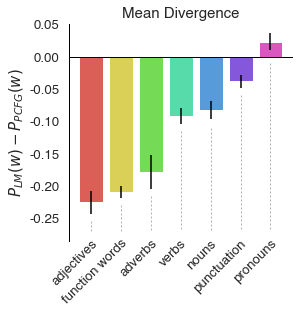

In [85]:
plt.figure(figsize=(4,4))
ax = plt.gca()

means = {'adjectives': -0.09779366399488154, 'function words': -0.09276188701209509, 'verbs': -0.06263858835068059, 'adverbs': -0.05993595513595684, 'nouns': -0.03207745213705815, 'punctuation': 0.10403131356740988, 'pronouns': 0.10692777289960576}
means = {'adjectives': -0.22529870656927975, 'function words': -0.20999494802540813, 'adverbs': -0.1783828940623779, 'verbs': -0.09219335892639106, 'nouns': -0.08313068116255025, 'punctuation': -0.03835967996560524, 'pronouns': 0.02304747573767549}

order_mean = sorted(means.items(), key=lambda x: x[1])
names = [x[0] for x in order_mean]
order_mean = [x[1] for x in order_mean]
plt.grid(False)

plt.bar(
    names, 
    order_mean, 
    yerr=np.array([0.036003466316347034,
 0.019125523971544572,
 0.05364734146595029,
 0.025447287570316293,
 0.027501345089889384,
 0.019810824297948747,
 0.02556631579797107])/2,
    color=palette,
)

plt.xlabel("")
plt.ylabel("$P_{LM}(w) - P_{PCFG}(w)$", fontsize=15)
ax.set_xticklabels(names, rotation=45, ha='right', rotation_mode='anchor')
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,
    top=False,
    rotation=45,
    pad=-10,
)

plt.plot([0,0],[-0.255,-.27], linestyle='--', dashes=(2, 2), lw=1, c='0.7', zorder=-100)
plt.plot([1,1],[-0.23,-.27], linestyle='--', dashes=(2, 2), lw=1, c='0.7', zorder=-100)
plt.plot([2,2],[-0.215,-.27], linestyle='--', dashes=(2, 2), lw=1, c='0.7', zorder=-100)
plt.plot([3,3],[-0.115,-.27], linestyle='--', dashes=(2, 2), lw=1, c='0.7', zorder=-100)
plt.plot([4,4],[-0.11,-.27], linestyle='--', dashes=(2, 2), lw=1, c='0.7', zorder=-100)
plt.plot([5,5],[-0.06,-.27], linestyle='--', dashes=(2, 2), lw=1, c='0.7', zorder=-100)
plt.plot([6,6],[-0.01,-.27], linestyle='--', dashes=(2, 2), lw=1, c='0.7', zorder=-100)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.setp(ax.spines.values(), color="black", lw=1)
plt.title("Mean Divergence", fontsize=15)
plt.axhline(0, lw=1, color='black')

plt.savefig(f"petrov/figures/pos_divergence.pdf", bbox_inches="tight")

# Explanations

## Setup

In [12]:
input_ids = torch.tensor([1,1,3,3,0,2])  #[x for x, l in language.train_corpus if l==1][6]
baseline_ids = torch.tensor([0,0,2,2,1,3])  # torch.zeros_like(input_ids) + len(language.idx2token) 

language = binary_language

input_ids = torch.tensor([x for x, l in language.train_corpus if l==1][1])
baseline_ids = torch.zeros_like(input_ids) + language.pad_idx

logit = model(input_ids).detach()
bl_logit = model(baseline_ids).detach()

print(logit, bl_logit)

input_embs = model.create_inputs_embeds(input_ids)
baseline_embs = model.create_inputs_embeds(baseline_ids)

sen = [language.idx2token[idx] for idx in input_ids]


def gen_dyck_deps(input_list):
    stack = []
    deps = []
    for idx, x in enumerate(input_list):
        if x < 2:
            stack.append((idx, x))
        else:
            prev_idx, y = stack.pop()
            assert (x - 2) == y, "string not well formed"
            deps.append((prev_idx, idx))

    return deps

# deps = gen_dyck_deps(input_ids)
deps = None

tensor([8.3517]) tensor([-10.0753])


<ipython-input-12-b579ac3d7a53>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor([x for x, l in language.train_corpus if l==1][1])


## Attention

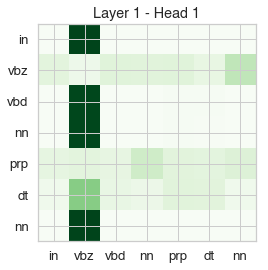

In [47]:
# sen = [2,2,0,1,1,2,2,1,0,3]
# model = sorted_runs[0][0]
out, attns = model(input_ids, return_attention=True)

for idx, attn in enumerate(attns):
    for h_idx, attn_head in enumerate(attn):
        plt.imshow(attn_head.detach().numpy(), cmap="Greens")
        plt.title(f"Layer {idx+1} - Head {h_idx+1}")
        plt.xticks(range(len(sen)), sen)
        plt.yticks(range(len(sen)), sen)
        plt.show()

## Integrated Hessians

100%|██████████| 1/1 [00:08<00:00,  8.72s/it]

b b b B B B a A a A - 6.37


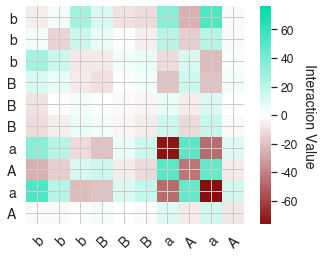

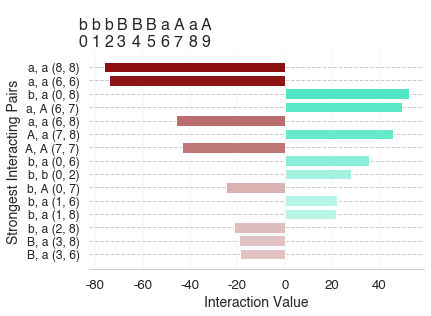

Torch: 6.368838
Keras: 6.368839
True
[16.39894485  4.69252157  5.18881941 -3.82202792 -2.26152802  0.31720126
 -1.3213191   2.06568432  2.32514787  4.95906973]
delta -0.08498382568359375
mse 522.5806566025691
spearman 0.8303030303030302


In [14]:
import keras
import keras.layers as layers
import tensorflow as tf
import torch
import numpy as np

# https://github.com/tensorflow/tensorflow/issues/38942
tf.keras.backend.set_image_data_format("channels_last")


class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, max_seq_len, vocab_size, embed_dim, padding_offset: int = 0):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=max_seq_len, output_dim=embed_dim)
        self.padding_offset = padding_offset

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        position_ids = tf.range(start=0, limit=maxlen, delta=1) + self.padding_offset
        position_embs = self.pos_emb(position_ids)
        x = self.token_emb(x)
        return x + position_embs


class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-05)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-05)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        final_output = self.layernorm2(out1 + ffn_output)
        return final_output


class KerasModel(keras.Model):
    def __init__(self, torch_model):
        super().__init__()
        
        self.torch_model = torch_model

        if isinstance(torch_model.encoder, torch.nn.LSTM):
            keras_model = self.port_lstm(torch_model)
            
            self.embeddings = keras_model.layers[0]
            self.encoder = keras_model.layers[1]
            self.decoder = keras_model.layers[2]
        else:
            keras_model = self.port_transformer(torch_model)
            
            self.embeddings = keras.Sequential(keras_model.layers[:2])
            self.encoder = keras.Sequential(keras_model.layers[2:-2])
            self.decoder = keras.Sequential(keras_model.layers[-2:])

    def validate_keras_port(self, input_string: List[List[int]]):
        torch_out = self.torch_model(torch.tensor(input_string)).item()
        keras_out = self(np.array(input_string)).numpy().item()

        print(f"Torch: {torch_out:.6f}")
        print(f"Keras: {keras_out:.6f}")

        print(np.allclose(torch_out, keras_out, rtol=1e-03, atol=1e-08))
            
    def port_lstm(self, torch_model):
        assert torch_model.num_layers == 1, "Multi-layer LSTM not supported"

        vocab_size = torch_model.embeddings.num_embeddings
        emb_dim = torch_model.embeddings.embedding_dim
        nhid = torch_model.encoder.hidden_size

        keras_model = keras.Sequential()

        keras_model.add(layers.Embedding(input_dim=vocab_size, output_dim=emb_dim))        
        keras_model.add(layers.LSTM(nhid))        
        keras_model.add(layers.Dense(torch_model.decoder.out_features))

        keras_model.layers[0].set_weights([torch_model.embeddings.weight.detach().numpy()])    
        keras_model.layers[1].set_weights([
            torch_model.encoder.weight_ih_l0.detach().numpy().T,
            torch_model.encoder.weight_hh_l0.detach().numpy().T,
            torch_model.encoder.bias_hh_l0.detach().numpy() + torch_model.encoder.bias_ih_l0.detach().numpy(),
        ])
        keras_model.layers[2].set_weights([
            torch_model.decoder.weight.detach().numpy().T,
            torch_model.decoder.bias.detach().numpy()
        ])
        
        return keras_model
    
    def port_transformer(self, torch_model):
        if hasattr(torch_model.positional_embeddings, "weights"):
            # Sinusoidal embeddings
            positional_embeddings = torch_model.positional_embeddings.weights
        elif hasattr(torch_model.positional_embeddings, "weight"):
            # Learned embeddings
            positional_embeddings = torch_model.positional_embeddings.weight
        else:
            raise AttributeError("Positional Embeddings not found")

        emb_dim = torch_model.embeddings.embedding_dim
        vocab_size = torch_model.embeddings.num_embeddings
        ffn_embedding_dim = torch_model.encoder.layers[0].fc1.out_features
        num_heads = torch_model.num_heads
        num_layers = torch_model.num_layers
        max_seq_len = positional_embeddings.shape[0]

        input_tokens = keras.layers.Input(shape=(None,))

        embeddings = TokenAndPositionEmbedding(
            max_seq_len, 
            vocab_size, 
            emb_dim, 
            padding_offset=torch_model.encoder.padding_idx + 1
        )(input_tokens)

        for _ in range(num_layers):
            embeddings = TransformerBlock(emb_dim, num_heads, ffn_embedding_dim)(embeddings)

        output = layers.Dense(torch_model.decoder.out_features)(embeddings)

        keras_model = keras.models.Model(inputs=[input_tokens], outputs=output)

        weights = [
            torch_model.embeddings.weight.detach().numpy(),
            positional_embeddings.detach().numpy(),
        ]

        for block in torch_model.encoder.layers:
            weights.extend([
                block.self_attn.q_proj.weight.t().unsqueeze(1).detach().numpy(),
                block.self_attn.q_proj.bias.unsqueeze(0).detach().numpy(),
                block.self_attn.k_proj.weight.t().unsqueeze(1).detach().numpy(),
                block.self_attn.k_proj.bias.unsqueeze(0).detach().numpy(),
                block.self_attn.v_proj.weight.t().unsqueeze(1).detach().numpy(),
                block.self_attn.v_proj.bias.unsqueeze(0).detach().numpy(),
                block.self_attn.out_proj.weight.t().unsqueeze(0).detach().numpy(),
                block.self_attn.out_proj.bias.detach().numpy(),
                block.fc1.weight.detach().numpy().T,
                block.fc1.bias.detach().numpy(),
                block.fc2.weight.detach().numpy().T,
                block.fc2.bias.detach().numpy(),
                block.self_attn_layer_norm.weight.detach().numpy(),
                block.self_attn_layer_norm.bias.detach().numpy(),
                block.final_layer_norm.weight.detach().numpy(),
                block.final_layer_norm.bias.detach().numpy(),
            ])

        weights.extend([
            torch_model.decoder.weight.detach().numpy().T,
            torch_model.decoder.bias.detach().numpy(),
        ])

        keras_model.set_weights(weights)
        
        return keras_model
        
    def call(self, input_ids=None, input_embeds=None):
        assert input_ids is not None or input_embeds is not None
        
        if input_embeds is None:
            input_embeds = self.embeddings(input_ids)
        if input_embeds.ndim == 2:
            input_embeds = input_embeds[np.newaxis, ...]
        
        hidden = self.encoder(input_embeds)
        logits = self.decoder(hidden)

        if logits.ndim == 3:
            logits = logits[:, -1]
        
        return logits

def mse(a, b):
    return ((a - b) ** 2).mean(axis=-1)


def prediction_model(model: LanguageClassifier):
    def forward_pass(batch_embedding: torch.Tensor) -> torch.Tensor:
        return model(None, input_embeds=batch_embedding)

    return forward_pass


def invert(input_list):
    return [
        {
#             0: 1,
#             1: 0,
#             2: 3,
#             3: 2,
            0: 1,
            1: 2,
            2: 0,
        }[x]
        for x in input_list
    ]


def marginal_baseline(
    model: KerasModel,
    language: Language,
    sen_len: int,
    n_samples: int,
    **kwargs,
) -> np.ndarray:
    baselines = language.gen_baselines(sen_len, n_samples, **kwargs)

    baseline_embedding = model.embedding(baselines)

    return baseline_embedding


def gen_explanation(
    model: KerasModel,
    language: Language,
    input_embedding: np.ndarray,
    baseline_embedding: np.ndarray,
    num_interpolations: int = 500,
    output_indices: Optional[int] = None,
    gen_interactions: bool = True,
    gauss_legendre: bool = False,
    verbose: bool = False,
    integrate_along_axes: bool = False,
    **kwargs,
):
    """Generate the explanations for a single input."""
    explainer = EmbeddingExplainerTF(
        prediction_model(model), 
        gauss_legendre=gauss_legendre,
        integrate_along_axes=integrate_along_axes,
    )

    use_expectation = baseline_embedding.shape[0] > 1

    output = keras_model(None, input_embeds=input_embedding).numpy()
    if language.config.is_binary:
        logit = np.round(output.item(), 2)
    else:
        logit = np.round(output[0, output_indices], 2)
        
    attributions = explainer.attributions(
        input_embedding,
        baseline_embedding,
        use_expectation=use_expectation,
        batch_size=min(num_interpolations, 2000),
        num_samples=num_interpolations,
        output_indices=output_indices,
        verbose=verbose,
    ).squeeze()

    interactions = None
    if gen_interactions:
        interactions = explainer.interactions(
            input_embedding,
            baseline_embedding,
            use_expectation=use_expectation,
            batch_size=min(num_interpolations, 1000),
            num_samples=num_interpolations,
            output_indices=output_indices,
            verbose=verbose,
        ).squeeze()

    return logit, attributions, interactions, baseline_embedding


def gen_avg_explanation(
    keras_model: KerasModel,
    language: Language,
    all_inputs: List[List[int]],
    num_baselines: int = 50,    
    return_all_explanations: bool = False,
    gen_interactions: bool = True,
    verbose: bool = False,
    baseline_type: str = "zero",
    gauss_legendre: bool = True,
    well_formed: bool = False,
    **kwargs,
):
    all_logits = []
    all_attributions = []
    all_interactions = []
    all_baselines = []

    if baseline_type == "marginal" and gauss_legendre:
        baselines = marginal_baseline(
            keras_model, language, len(all_inputs[0]), num_baselines,
        )
        all_inputs *= num_baselines

    iterator = tqdm(all_inputs) if verbose else all_inputs        
        
    for idx, input_list in enumerate(iterator):
        input_embedding = keras_model.embeddings(np.array([input_list]))

        if baseline_type == "marginal" and gauss_legendre:
            baseline_embedding = baselines[idx:idx+1]
        else:
            baseline_embedding = {
                "zero": lambda: np.zeros_like(input_embedding),
                "marginal": lambda: marginal_baseline(
                    keras_model, language, len(input_list), num_baselines, well_formed=well_formed,
                ),
                "fixed": lambda: keras_model.embeddings(baseline),
                "invert": lambda: keras_model.embeddings(np.array([invert(input_list)])),
                "average": lambda: np.zeros_like(input_embedding) + np.array([0.25, 0.25, 0.25, 0.25, 0.]),
                "gaussian_noise": lambda: input_embedding + np.random.normal(0, 1., size=input_embedding.shape),
                "gaussian_random": lambda: np.clip(np.random.normal(.5, .5, size=input_embedding.shape), 0, 1),
            }[baseline_type]()

        logit, attributions, interactions, baseline_embedding = gen_explanation(
            keras_model,
            language,
            input_embedding,
            baseline_embedding,
            gen_interactions=gen_interactions,
            gauss_legendre=gauss_legendre,            
#             verbose=verbose,
            **kwargs,
        )

        all_logits.append(logit)
        all_attributions.append(attributions)
        all_interactions.append(interactions)
        all_baselines.append(baseline_embedding)

    if return_all_explanations:
        return all_logits, all_attributions, all_interactions, all_baselines

    logits = np.array(all_logits).mean(0)
    attributions = np.array(all_attributions).mean(0)
    if gen_interactions:
        interactions = np.array(all_interactions).mean(0)
        print(mse(interactions.sum(-1), attributions))
    else:
        interactions = None

    return logits, attributions, interactions, all_baselines


def plot_explanations(
    language, input_list, attributions=None, interactions=None, logit=None
):
    sen = language.translate(input_list)

    if logit is not None:
        print(" ".join(sen), "-", logit)

    if attributions is not None:
        text_plot(sen, attributions)
        plt.show()

    if interactions is not None:
        text_plot(sen, interactions.sum(-1))
        plt.show()
        matrix_interaction_plot(interactions, sen, zero_diagonals=False)
        plt.show()

        top_k = min(15, (len(sen) * (len(sen) + 1)) // 2)
        bar_interaction_plot(interactions, sen, zero_diagonals=False, top_k=top_k)
        plt.show()


# model = experiment.best_model  # torch.load('dyck2.pt')
# model = torch.load("dyck2_d4_l20.pt")
# model = sorted_runs[0][0]
# language = torch.load("dyck2_lang.pt")
keras_model = KerasModel(model)

all_inputs = [x[0].tolist() for x in language.corpus if x[1] == 1][:100]
all_inputs = [[1, 1, 1, 3, 3, 3, 0, 2, 0, 2]]

logits, ig_attributions, interactions, baselines = gen_avg_explanation(
    keras_model,
    language, 
    all_inputs, 
    baseline="zero", 
    num_interpolations=20**2,
    num_baselines=50,
    output_indices=0,
    gen_interactions=True,
    well_formed=False,
    return_all_explanations=True,
    gauss_legendre=False,
    verbose=True,
)

## PLOT
plot_explanations(language, all_inputs[0], ig_attributions[0], interactions[0], logits[0])

in_ = model.embeddings(torch.tensor(all_inputs[0]))
bl = torch.zeros_like(in_)

keras_model.validate_keras_port(all_inputs)

print(ig_attributions[0])
# Note delta is comuted wrt zero baseline
print(
    "delta", (ig_attributions[0].sum() - (model(inputs_embeds=in_) - model(inputs_embeds=bl))).item(),
)
print(
    'mse',
    mse(ig_attributions[0], interactions[0].sum(-1))
)
print(
    'spearman',
    spearmanr(ig_attributions[0], interactions[0].sum(-1))[0]
)

### Torch

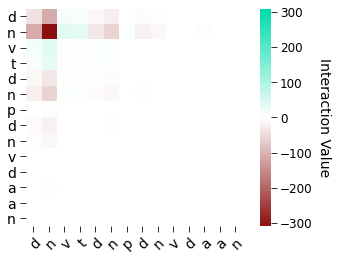

In [720]:
def prediction_model_torch(model: LanguageClassifier):
    def forward_pass(batch_embedding: torch.Tensor) -> torch.Tensor:
        return model(inputs_embeds=batch_embedding)

    return forward_pass


explainer = EmbeddingExplainerTorch(prediction_model_torch(model))

# attrs = explainer.interactions(
#     input_embs.detach(),
#     baseline_embs.detach(),
#     batch_size=50,
#     num_samples=30**2,
#     use_expectation=False,
# )

# delta = attrs.sum() - (model(inputs_embeds=input_embs) - model(inputs_embeds=baseline_embs))

# print(delta)
# text_plot(sen, attrs.sum(-1).squeeze())

interaction = explainer.interactions(
    input_embs.detach(),
    baseline_embs.detach(),
    batch_size=50,
    num_samples=40**2,
    use_expectation=False,
)

matrix_interaction_plot(interaction.squeeze(), sen, zero_diagonals=False)

if deps is not None:
    ax = plt.gca()
    for x,y in deps:
        rectangle = Rectangle((x-.5,y-.5), 1, 1, linewidth=2, facecolor='none', edgecolor='0.0', clip_on=False)
        ax.add_patch(rectangle)

        rectangle = Rectangle((y-.5,x-.5), 1, 1, linewidth=2, facecolor='none', edgecolor='0.0', clip_on=False)
        ax.add_patch(rectangle)

100%|██████████| 99/99 [00:07<00:00, 13.52it/s]


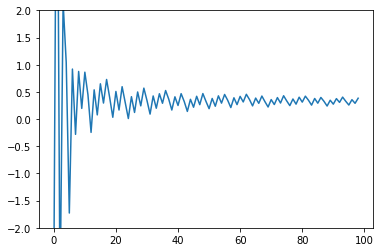

In [58]:
spearmans = []
mses = []
deltas = []

for x in trange(10, 1000, 10):
    logits, ig_attributions, interactions, baselines = gen_avg_explanation(
        keras_model,
        language, 
        all_inputs, 
        baseline="zero", 
        num_interpolations=x,
        num_baselines=50,
        output_indices=0,
        gen_interactions=False,
        well_formed=False,
        return_all_explanations=True,
        gauss_legendre=True,
    )

    ## PLOT
    in_ = model.embeddings(torch.tensor(all_inputs[0]))
    bl = torch.zeros_like(in_)

    # Note delta is computed wrt zero baseline
#     print(
#         "delta", (ig_attributions[0].sum() - (model(inputs_embeds=in_) - model(inputs_embeds=bl))).item(),
#     )
#     print(
#         'mse',
#         mse(ig_attributions[0], interactions[0].sum(-1))
#     )
#     print(
#         'spearman',
#         spearmanr(ig_attributions[0], interactions[0].sum(-1))[0]
#     )
        
    deltas.append(((ig_attributions[0].sum() - model(inputs_embeds=in_)) - model(inputs_embeds=bl)).item())
#     spearmans.append(spearmanr(ig_attributions[0], interactions[0].sum(-1))[0])
#     mses.append(mse(ig_attributions[0], interactions[0].sum(-1)))
    

plt.ylim(-2,2)
plt.plot(deltas)

## Archipelago

In [721]:
import sys

sys.path.append("../../archipelago/src")
# from explainer import Archipelago
from application_utils.text_utils import *
from application_utils.text_utils_torch import BertWrapperTorch
from viz.text import viz_text


class Explainer:
    def __init__(
        self,
        model,
        input=None,
        baseline=None,
        data_xformer=None,
        output_indices=0,
        batch_size=20,
        verbose=False,
    ):

        input, baseline = self.arg_checks(input, baseline, data_xformer)

        self.model = model
        self.input = np.squeeze(input)
        self.baseline = np.squeeze(baseline)
        self.data_xformer = data_xformer
        self.output_indices = output_indices
        self.batch_size = batch_size
        self.verbose = verbose

    def arg_checks(self, input, baseline, data_xformer):
        if (input is None) and (data_xformer is None):
            raise ValueError("Either input or data xformer must be defined")

        if input is not None and baseline is None:
            raise ValueError("If input is defined, the baseline must also defined")

        if data_xformer is not None and input is None:
            input = np.ones(data_xformer.num_features).astype(bool)
            baseline = np.zeros(data_xformer.num_features).astype(bool)
        return input, baseline

    def verbose_iterable(self, iterable):
        if self.verbose:
            from tqdm import tqdm

            return tqdm(iterable)
        else:
            return iterable

    def batch_set_inference(
        self, set_indices, context, insertion_target, include_context=False
    ):
        """
        Creates archipelago type data instances and runs batch inference on them
        All "sets" are represented as tuples to work as keys in dictionaries
        """

        num_batches = int(np.ceil(len(set_indices) / self.batch_size))

        scores = {}
        for b in self.verbose_iterable(range(num_batches)):
            batch_sets = set_indices[b * self.batch_size : (b + 1) * self.batch_size]
            data_batch = []
            for index_tuple in batch_sets:
                new_instance = context.copy()
                for i in index_tuple:
                    new_instance[i] = insertion_target[i]

                if self.data_xformer is not None:
                    new_instance = self.data_xformer(new_instance)

                data_batch.append(new_instance)

            if include_context and b == 0:
                if self.data_xformer is not None:
                    data_batch.append(self.data_xformer(context))
                else:
                    data_batch.append(context)

            preds = self.model(np.array(data_batch))

            for c, index_tuple in enumerate(batch_sets):
                scores[index_tuple] = preds[c, self.output_indices]
            if include_context and b == 0:
                context_score = preds[-1, self.output_indices]

        output = {"scores": scores}
        if include_context and num_batches > 0:
            output["context_score"] = context_score
        return output


class Archipelago(Explainer):
    def __init__(
        self,
        model,
        input=None,
        baseline=None,
        data_xformer=None,
        output_indices=0,
        batch_size=20,
        interactive=False,
        verbose=False,
    ):
        Explainer.__init__(
            self,
            model,
            input,
            baseline,
            data_xformer,
            output_indices,
            batch_size,
            verbose,
        )
        self.inter_sets = None
        self.main_effects = None
        self.interactive = interactive
        self.interactive_explanations = None
        self.max_interactive_attribution_magnitude = None

        if self.interactive:
            self.cache_interactive_explanations()

    def archattribute(self, set_indices):
        """
        Gets archipelago attributions of index sets
        """
        if not set_indices:
            return dict()
        scores = self.batch_set_inference(
            set_indices, self.baseline, self.input, include_context=True
        )
        set_scores = scores["scores"]
        baseline_score = scores["context_score"]
        for index_tuple in set_scores:
            set_scores[index_tuple] -= baseline_score
        return set_scores

    def archdetect(
        self,
        get_main_effects=True,
        get_pairwise_effects=True,
        single_context=False,
        weights=[0.5, 0.5],
    ):
        """
        Detects interactions and sorts them
        Optional: gets archipelago main effects and/or pairwise effects from function reuse
        "Effects" are archattribute scores
        """
        search_a = self.search_feature_sets(
            self.baseline,
            self.input,
            get_main_effects=get_main_effects,
            get_pairwise_effects=get_pairwise_effects,
        )
        inter_a = search_a["interactions"]

        # notice that input and baseline have swapped places in the arg list
        search_b = self.search_feature_sets(self.input, self.baseline)
        inter_b = search_b["interactions"]

        inter_strengths = {}
        for pair in inter_a:
            if single_context:
                inter_strengths[pair] = inter_b[pair] ** 2
            else:
                inter_strengths[pair] = (
                    weights[1] * inter_a[pair] ** 2 + weights[0] * inter_b[pair] ** 2
                )
        sorted_scores = sorted(inter_strengths.items(), key=lambda kv: -kv[1])

        output = {"interactions": sorted_scores}
        for key in search_a:
            if key not in output:
                output[key] = search_a[key]
        return output

    def explain(self, top_k=None, separate_effects=False):
        if (self.inter_sets is None) or (self.main_effects is None):
            detection_dict = self.archdetect(get_pairwise_effects=False)
            inter_strengths = detection_dict["interactions"]
            self.main_effects = detection_dict["main_effects"]
            self.inter_sets, _ = zip(*inter_strengths)
            print(detection_dict)

        if isinstance(top_k, int):
            thresholded_inter_sets = self.inter_sets[:top_k]
        elif top_k is None:
            thresholded_inter_sets = self.inter_sets
        else:
            raise ValueError("top_k must be int or None")

        inter_sets_merged = merge_overlapping_sets(thresholded_inter_sets)
        inter_effects = self.archattribute(inter_sets_merged)

        if separate_effects:
            return inter_effects, self.main_effects

        merged_indices = merge_overlapping_sets(
            set(self.main_effects.keys()) | set(inter_effects.keys())
        )
        merged_explanation = dict()
        for s in merged_indices:
            if s in inter_effects:
                merged_explanation[s] = inter_effects[s]
            elif s[0] in self.main_effects:
                assert len(s) == 1
                merged_explanation[s] = self.main_effects[s[0]]
            else:
                raise ValueError(
                    "Error: index should have been in either main_effects or inter_effects"
                )
        return merged_explanation

    def search_feature_sets(
        self,
        context,
        insertion_target,
        get_interactions=True,
        get_main_effects=False,
        get_pairwise_effects=False,
    ):
        """
        Gets optional pairwise interaction strengths, optional main effects, and optional pairwise effects
        "Effects" are archattribute scores
        All three options are combined to reuse function calls
        """
        num_feats = context.size
        idv_indices = [(i,) for i in range(num_feats)]

        preds = self.batch_set_inference(
            idv_indices, context, insertion_target, include_context=True
        )
        idv_scores, context_score = preds["scores"], preds["context_score"]

        output = {}

        if get_interactions:
            pair_indices = []
            pairwise_effects = {}
            for i in range(num_feats):
                for j in range(i + 1, num_feats):
                    pair_indices.append((i, j))

            preds = self.batch_set_inference(pair_indices, context, insertion_target)
            pair_scores = preds["scores"]

            inter_scores = {}
            for i, j in pair_indices:

                # interaction detection
                ell_i = np.abs(context[i].item() - insertion_target[i].item())
                ell_j = np.abs(context[j].item() - insertion_target[j].item())
                f_a = context_score
                f_b = idv_scores[(i,)]
                f_c = idv_scores[(j,)]
                f_d = pair_scores[(i, j)]
                
                numerator = f_a - f_b - f_c + f_d
                denominator = ell_i * ell_j
                                
                # The numerator should theorecially be zero when there aren't interactions 
                # in the function f. However, it is possible that the numerator is not 
                # exactly zero due to precision issues in the function call. Here, if all 
                # f_x are much larger than and the existing numerator value in magitude,
                # then we set the numerator to zero
                if np.abs(numerator) / np.min(np.abs(np.array([f_a, f_b, f_c, f_d]))) < 1e-5:
                    numerator = 0.0
                    
                if denominator == 0.0:
                    inter_scores[(i, j)] = 0.0
                else:
                    inter_scores[(i, j)] = numerator / denominator

                if (
                    get_pairwise_effects
                ):  # leverage existing function calls to compute pairwise effects
                    pairwise_effects[(i, j)] = pair_scores[(i, j)] - context_score

            output["interactions"] = inter_scores

            if get_pairwise_effects:
                output["pairwise_effects"] = pairwise_effects

        if get_main_effects:  # leverage existing function calls to compute main effects
            main_effects = {}
            for i in idv_scores:
                main_effects[i[0]] = idv_scores[i] - context_score
            output["main_effects"] = main_effects

        return output

    def get_interactive_explanations(self):
        if self.interactive_explanations is None:
            assert not self.interactive
            self.cache_interactive_explanations()

        return self.interactive_explanations, self.max_interactive_attribution_magnitude

    def cache_interactive_explanations(self):
        detection_dict = self.archdetect(get_pairwise_effects=False)
        inter_strengths = detection_dict["interactions"]
        inter_strengths = [
            (inter, strength) for inter, strength in inter_strengths if strength > 1e-10
        ]
        self.main_effects = detection_dict["main_effects"]
        self.inter_sets, _ = zip(*inter_strengths)

        existing_inter_sets = set()
        inter_sets_slider = []
        existing_inter_sets_slider = set()

        break_out = False
        for top_k in range(len(self.inter_sets)):
            thresholded_inter_sets = self.inter_sets[:top_k]
            inter_sets_merged = merge_overlapping_sets(thresholded_inter_sets)
            inter_sets_key = tuple(sorted(inter_sets_merged))
            if inter_sets_key not in existing_inter_sets_slider:
                inter_sets_slider.append(inter_sets_key)
                existing_inter_sets_slider.add(inter_sets_key)

            for inter_set in inter_sets_merged:
                if inter_set in existing_inter_sets:
                    continue
                else:
                    existing_inter_sets.add(inter_set)
                    if len(inter_set) == len(self.input):
                        break_out = True
                        break
            if break_out:
                break

        inter_effects = self.archattribute(list(existing_inter_sets))
        self.max_interactive_attribution_magnitude = np.max(
            np.abs(list(inter_effects.values()))
        )

        self.interactive_explanations = []
        for inter_sets_key in inter_sets_slider:
            inter_effects_slider = {
                inter_set: inter_effects[inter_set] for inter_set in inter_sets_key
            }
            merged_indices = merge_overlapping_sets(
                set(self.main_effects.keys()) | set(inter_effects_slider.keys())
            )

            merged_explanation_slider = dict()
            for s in merged_indices:
                if s in inter_effects:
                    merged_explanation_slider[s] = inter_effects[s]
                elif s[0] in self.main_effects:
                    assert len(s) == 1
                    merged_explanation_slider[s] = self.main_effects[s[0]]
                else:
                    raise ValueError(
                        "Error: index should have been in either main_effects or inter_effects"
                    )
            self.interactive_explanations.append(merged_explanation_slider)


def merge_overlapping_sets(lsts, output_ints=False):
    """Check each number in our arrays only once, merging when we find
    a number we have seen before.

    O(N) mergelists5 solution from https://stackoverflow.com/questions/9110837/python-simple-list-merging-based-on-intersections
    """

    def locatebin(bins, n):
        """
        Find the bin where list n has ended up: Follow bin references until
        we find a bin that has not moved.
        """
        while bins[n] != n:
            n = bins[n]
        return n

    data = []
    for lst in lsts:
        if type(lst) not in {list, set, tuple}:
            lst = {lst}
        data.append(set(lst))

    bins = list(range(len(data)))  # Initialize each bin[n] == n
    nums = dict()

    sets = []
    for lst in lsts:
        if type(lst) not in {list, set, tuple}:
            lst = {lst}
        sets.append(set(lst))

    for r, row in enumerate(data):
        for num in row:
            if num not in nums:
                # New number: tag it with a pointer to this row's bin
                nums[num] = r
                continue
            else:
                dest = locatebin(bins, nums[num])
                if dest == r:
                    continue  # already in the same bin

                if dest > r:
                    dest, r = r, dest  # always merge into the smallest bin

                data[dest].update(data[r])
                data[r] = None
                # Update our indices to reflect the move
                bins[r] = dest
                r = dest

    # take single values out of sets
    output = []
    for s in data:
        if s:
            if output_ints and len(s) == 1:
                output.append(next(iter(s)))
            else:
                output.append(tuple(sorted(s)))

    return output

In [722]:
import torch
import numpy as np


class ModelWrapperTorch:
    def __init__(self, model, device, merge_logits=False):
        self.model = model.to(device)
        self.device = device
        self.merge_logits = merge_logits

    def get_predictions(self, batch_embs):
        batch_embs = torch.tensor(batch_embs).to(self.device)
        if batch_embs.ndim == 2:
            batch_embs = batch_embs.unsqueeze(0)
        
        return self.model(inputs_embeds=batch_embs).unsqueeze(1)

    def __call__(self, batch_embs):
        batch_predictions = self.get_predictions(batch_embs)
        if self.merge_logits:
            batch_predictions2 = (
                (batch_predictions[:, 1] - batch_predictions[:, 0]).unsqueeze(1).numpy()
            )
            return batch_predictions2
        else:
            return batch_predictions.detach().numpy()
        
        
model_wrapper = ModelWrapperTorch(model, "cpu")

tensor([1, 2, 5, 4, 1, 2, 3, 1, 2, 5, 1, 0, 0, 2]) [[7.4613256]]
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]) [[-10.346385]]
{'interactions': [((0, 2), 480.6484824184213), ((1, 2), 231.9501602038422), ((1, 4), 230.63407336984028), ((1, 7), 206.26778616748243), ((1, 10), 195.1044086372135), ((0, 1), 155.39149831290004), ((1, 5), 152.16746755297675), ((0, 5), 151.59469544613648), ((3, 4), 151.21439803697285), ((2, 5), 151.13141895117042), ((4, 5), 151.02482626645542), ((2, 3), 150.3289725900122), ((0, 4), 150.03252469352628), ((2, 4), 149.60430423167645), ((10, 11), 149.17912989590695), ((1, 11), 148.92888408862382), ((1, 8), 136.5391729663611), ((0, 8), 136.35798703208457), ((5, 8), 136.35316773753812), ((2, 8), 136.15253874683776), ((4, 8), 135.83216032160271), ((0, 7), 126.72098457999527), ((5, 7), 126.68898220548044), ((2, 7), 126.5433222109591), ((4, 7), 126.08278031410055), ((5, 10), 122.41223635782444), ((0, 10), 122.40777402367576), ((2, 10), 122.18673412036969), ((4, 10), 

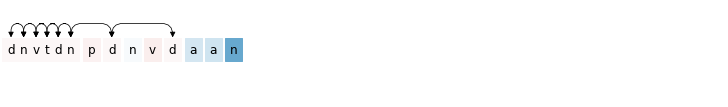

In [724]:
np_input_embs = input_embs.detach().numpy()[0]
np_baseline_embs = baseline_embs.detach().numpy()[0]

logit = model_wrapper(np_input_embs)
baseline_logit = model_wrapper(np_baseline_embs)
print(input_ids, logit)
print(baseline_ids, baseline_logit)

xf = TextXformer(np_input_embs, np_baseline_embs) 

apgo = Archipelago(model_wrapper, data_xformer=xf, output_indices=0, batch_size=5)

explanation = apgo.explain(top_k=10)

# explanation_sum = sum(explanation.values())
# diff_f = model_wrapper([text_ids])[0,class_idx] - model_wrapper([baseline_ids])[0,class_idx]

# print(
#     f"sum phi(I)\t{explanation_sum:.2f}",
#     f"f(x) - f(x')\t{diff_f:.2f}", sep="\n"
# )
print(explanation)
viz_text(explanation, sen)
plt.show()



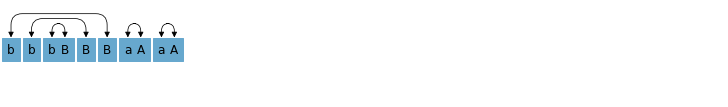

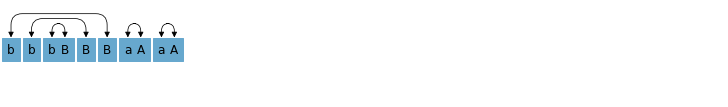

In [227]:
viz_text(
    {(2,3): 1.,
     (1,4): 1.,
     (0,5): 1.,     
     (6,7): 1.,
     (8,9): 1.,
    }, language.translate(input_ids.squeeze())
)

<ipython-input-52-84a10d1b5ef5>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prev_output = model(inputs_embeds=torch.tensor(x)).detach()
<ipython-input-52-84a10d1b5ef5>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_output = model(inputs_embeds=torch.tensor(y)).detach()
<ipython-input-52-84a10d1b5ef5>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor((1-alpha) * x + alpha * y)
<ipython-input-52-84a10d1b5ef5>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clon

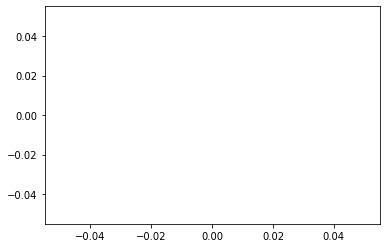

In [52]:
OUTPUTS = []
ALPHAS = []

def find_root_point(x, y, model, reps=10, partitions=10):
    prev_input = x    
    prev_output = model(inputs_embeds=torch.tensor(x)).detach()
    final_output = model(inputs_embeds=torch.tensor(y)).detach()

    assert np.sign(prev_output) != np.sign(final_output)
    
    if reps == 0 and abs(prev_output) < abs(final_output):
        return x
    elif reps == 0:
        return y

    for alpha in np.linspace(0, 1, partitions)[1:]:
        input_tensor = torch.tensor((1-alpha) * x + alpha * y)
        output = model(inputs_embeds=input_tensor).detach()

        if np.sign(output) != np.sign(prev_output):
            return find_root_point(prev_input, input_tensor, model, reps=(reps-1), partitions=partitions)
        
        prev_input = input_tensor
        prev_output = output
        
    return x

root_point = find_root_point(baseline_embs, input_embs, model, reps=30, partitions=100)
model(inputs_embeds=torch.tensor(root_point))

plt.plot(OUTPUTS)

## Pairwise Ablation

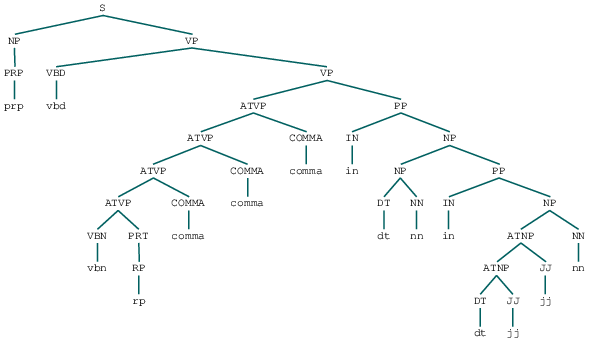

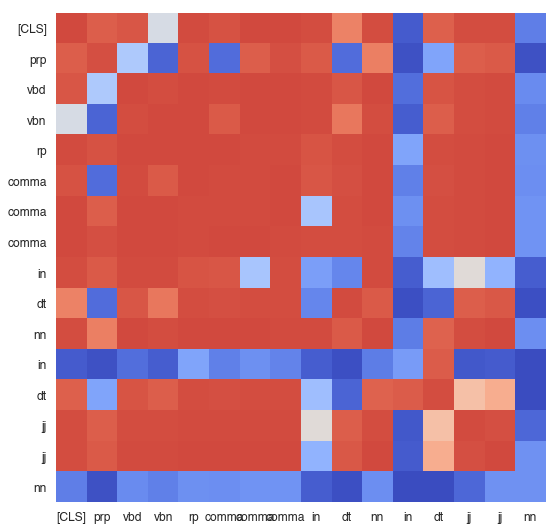

In [21]:
def flatten(container):
    for i in container:
        if isinstance(i, (list,tuple)):
            for j in flatten(i):
                yield j
        else:
            yield i
            
            
def dyck_cond_prob(input_ids, ids, use_model_probs=False, num_cond_samples=1):
    old_ids = [input_ids[idx].item() for idx in ids]

    candidate_ids = product(*[set(range(4)) - {old_idx} for old_idx in old_ids])
    candidate_items = []

    for new_ids in candidate_ids:
        candidate_item = torch.clone(input_ids)
        for i, new_idx in zip(ids, new_ids):
            candidate_item[i] = new_idx
        candidate_items.append(candidate_item)

    if use_model_probs:
        with torch.no_grad():
            model_probs = model(torch.stack(candidate_items)).sigmoid()

        return random.choices(candidate_items, weights=model_probs, k=num_cond_samples)
    else:
        valid_candidates = [item for item in candidate_items if language.is_dyck(item)]
        if len(valid_candidates) > 0:
            return random.choices(valid_candidates, k=num_cond_samples)

        return random.choices(candidate_items, k=num_cond_samples)


def gen_ablation_matrix(
    input_ids, 
    baseline_ids, 
    coalitions=None, 
    use_embs=False, 
    exclude_diagonal=False, 
    keep=False, 
    discard=False, 
    cond_prob=False,
    num_cond_samples=1,
    use_model_probs=False,
):   
    # with torch.no_grad():
    #     logit = model(inputs_embeds=input_ids) if use_embs else model(input_ids)
    #     baseline_logit = model(inputs_embeds=baseline_ids) if use_embs else model(baseline_ids)
    if coalitions is None:
        coalitions = [[idx] for idx in range(len(input_ids))]

    ablation_matrix = torch.zeros(len(coalitions), len(coalitions))

    for i, coal_i in enumerate(coalitions):
        for j, coal_j in enumerate(coalitions[i+exclude_diagonal:], start=i+exclude_diagonal):
            coal_ij = list(set(flatten(coal_i + coal_j)))

            if discard:
                mixed_input = torch.tensor([x for k, x in enumerate(input_ids) if k not in coal_ij])
                if len(mixed_input) == 0:
                    break
            elif cond_prob:
                mixed_input = dyck_cond_prob(input_ids, coal_ij, num_cond_samples=num_cond_samples, use_model_probs=use_model_probs)
                mixed_input = torch.stack(mixed_input)
            elif keep:
                mixed_input = torch.clone(baseline_ids)
                mixed_input[coal_ij] = input_ids[coal_ij]
            else:
                mixed_input = torch.clone(input_ids)
                mixed_input[coal_ij] = baseline_ids[coal_ij]

            with torch.no_grad():
                if use_embs:
                    output = model(inputs_embeds=mixed_input)
                    ablation_matrix[i,j] = output
                    ablation_matrix[j,i] = output
                else:
                    output = model(mixed_input)
                    if cond_prob and num_cond_samples > 1:
                        output = output.mean()
                    ablation_matrix[i,j] = output
                    ablation_matrix[j,i] = output

    return ablation_matrix


def plot_interaction_matrix(interactions, input_ids=None, sen=None, deps=None, save_file=None, add_ranks=False):
    fig, ax = plt.subplots(figsize=(9,9))
    ims = ax.imshow(interactions, cmap="coolwarm", clim=(-torch.max(abs(interactions)), torch.max(abs(interactions))))
    # plt.colorbar(ims)

    if input_ids is not None:
        plt.xticks(range(len(input_ids)), input_ids.tolist())
        plt.yticks(range(len(input_ids)), input_ids.tolist())
    elif sen is not None:
        plt.xticks(range(len(sen)), sen, fontsize=12)
        plt.yticks(range(len(sen)), sen, fontsize=12)

    if deps is not None:
        for x,y in deps:
            rectangle = Rectangle((x-.5,y-.5), 1, 1, linewidth=3, facecolor='none', edgecolor='black', clip_on=False)
            ax.add_patch(rectangle)

            rectangle = Rectangle((y-.5,x-.5), 1, 1, linewidth=3, facecolor='none', edgecolor='black', clip_on=False)
            ax.add_patch(rectangle)
            
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['bottom'].set_color('none')

    plt.grid(False)
    
    if add_ranks:
        ax.text(6.5, -1, 'Relative', fontsize=12, ha='center', fontweight='bold')
        ax.text(6.5, -.7, 'Rank', fontsize=12, ha='center', fontweight='bold')
        ax.text(6.5, 6, 'ARR: 1.0', fontsize=12, ha='center', fontweight='bold')
        ax.text(2.5, -.85, 'Row Ranks', fontsize=12, ha='center', fontweight='bold')

        plt.plot([5.7,7.3],[5.5,5.5], color="0.5")
        
        for i, row in enumerate(interactions):
            ranks = torch.zeros_like(row).to(int)
            for idx, rank in enumerate(row.argsort()):
                ranks[rank] = idx

            for j, rank in enumerate(ranks.tolist()):
                ax.text(j,i,rank, fontsize=12, ha='center', va='center')
                
            ax.text(6.5, i+.1, '5/5', fontsize=12, ha='center')
    
    if save_file is not None:
        plt.savefig(save_file, bbox_inches = "tight")
    


# input_ids = torch.tensor([1, 1, 1, 3, 3, 3, 0, 2, 1, 3])
# baseline_ids = torch.tensor([0, 0, 0, 2, 2, 2, 1, 3, 0, 2])
# sen = [language.idx2token[idx] for idx in input_ids]
# deps = gen_dyck_deps(input_ids)

pos_samples = [x for x, l in language.corpus if l==1 and len(x) == 10 and 1 in x[:2]]
neg_samples = [x for x, l in language.corpus if l==0 and len(x) == 10 and 1 not in x[:2]]

ablation_matrices = []
# for baseline_ids in tqdm_notebook([
#     x for x,_ in language.corpus
#     if len(x) == len(input_ids)
#     and all(input_ids != x)
# ]):

ablation_matrix = gen_ablation_matrix(
    input_ids, 
    baseline_ids, 
    use_embs=False, 
    discard=False, 
    exclude_diagonal=False, 
    keep=False, 
    cond_prob=False, 
    num_cond_samples=10, 
    use_model_probs=True,
)
ablation_matrices.append(ablation_matrix)

avg_interactions = torch.mean(torch.stack(ablation_matrices), dim=0)
plot_interaction_matrix(avg_interactions, sen=sen, deps=deps, add_ranks=False)

nltk.Tree.fromstring(trees.pop())

In [20]:
parser = Parser(language.grammar)

trees = set()

for i, tree in enumerate(parser.parse(sen[1:])):
    s = tree.pformat()
    tree_str = re.sub(r'([A-Z]*)_[0-9]*', r'\1', s)
    
    if tree_str not in trees:
        trees.add(tree_str)

# nltk.Tree.fromstring(trees.pop())

## Hierarchical Explanations

[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
6 7 tensor(8.4041)
[[0], [1], [2], [3], [4], [5], [[6], [7]], [8], [9]]
0 5 tensor(8.2626)
[[[0], [5]], [1], [2], [3], [4], [[6], [7]], [8], [9]]
0 5 tensor(8.1768)
[[[[0], [5]], [[6], [7]]], [1], [2], [3], [4], [8], [9]]
1 4 tensor(8.1161)
[[[[0], [5]], [[6], [7]]], [[1], [4]], [2], [3], [8], [9]]
2 3 tensor(7.7236)
[[[[0], [5]], [[6], [7]]], [[1], [4]], [[2], [3]], [8], [9]]
0 2 tensor(7.8024)
[[[[[0], [5]], [[6], [7]]], [[2], [3]]], [[1], [4]], [8], [9]]
0 1 tensor(7.6966)
[[[[[[0], [5]], [[6], [7]]], [[2], [3]]], [[1], [4]]], [8], [9]]
1 2 tensor(6.3688)
[[[[[[0], [5]], [[6], [7]]], [[2], [3]]], [[1], [4]]], [[8], [9]]]
0 1 tensor(5.7632)


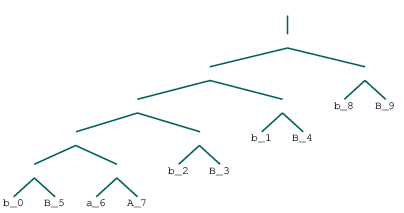

In [194]:
def hierarchical_ablation(input_ids, baseline_ids, contiguous=False, abs_score=True, **kwargs):
    coalitions = [[idx] for idx in range(len(input_ids))]
    
    while len(coalitions) != 1:
        print(coalitions)
        interactions = gen_ablation_matrix(input_ids, baseline_ids, coalitions=coalitions, exclude_diagonal=True, **kwargs)
        interactions.fill_diagonal_(-math.inf)
        coalitions = merge_coalitions(interactions, coalitions, contiguous=contiguous, abs_score=abs_score)
    
    return coalitions
            
def ablation_scores(input_ids, baseline_ids, coalitions: List[List[int]] = None):
    if coalitions is None:
        coalitions = [[idx] for idx in range(len(input_ids))]

    interaction_matrix = torch.zeros(len(coalitions), len(coalitions))

    for i, coal_i in enumerate(coalitions):
        for j, coal_j in enumerate(coalitions[i:], start=i):
            coal_ij = list(flatten(coal_i + coal_j))
            
            mixed_input = torch.clone(input_ids)
            mixed_input[coal_ij] = baseline_ids[coal_ij]
                
            with torch.no_grad():
                output = model(mixed_input)
                
            interaction_matrix[i,j] = output
            interaction_matrix[j,i] = output
                
    return interaction_matrix


def merge_coalitions(interactions, coalitions, contiguous=False, abs_score=True):
    if abs_score:
        interactions = interactions.abs()

    if contiguous:
        max_val = -math.inf
        x, y = None, None        
        for i in range(len(coalitions) - 1):
            if interactions[i,i+1] > max_val:
                max_val = interactions[i,i+1]
                x = i
                y = i+1
    else:
        values, indices = torch.topk(interactions, k=1)
        x = values.argmax().item()
        y = indices[x].item()
        max_val = values.max()
    
    print(x, y, max_val)
    
    new_coalitions = []
    for idx, coalition in enumerate(coalitions):
        if idx not in [x,y]:
            new_coalitions.append(coalition)
        elif idx == x:
            new_coalitions.append([coalitions[x], coalitions[y]])
            
    return new_coalitions


def coalitions_to_str(coalitions):
    if isinstance(coalitions, int):
        symbol = language.idx2token[input_ids[coalitions]]
        symbol = symbol.replace('(', '[').replace(')', ']')
        return f"{symbol}_{coalitions}"
    elif len(coalitions) == 1:
        return f"({coalitions_to_str(coalitions[0])})"
    else:
        left, right = coalitions
        return f"({coalitions_to_str(left)} {coalitions_to_str(right)})"
    

coalitions = hierarchical_ablation(
    input_ids, 
    baseline_ids, 
    contiguous=False, 
    abs_score=False, 
    discard=False, 
    keep=False, 
    cond_prob=False,
    num_cond_samples=5,
)
tree_str = coalitions_to_str(coalitions)
tree = nltk.Tree.fromstring(tree_str, read_leaf=lambda x: x.replace("40", "412124").replace("41", ")"))

tree

In [190]:
language.translate(input_ids)


[[[[b2, B3], [b1, B4]], [b0, B5]], [[a6, a7], [b8, B9]]]

[[a6, a7], [b8, B9], [a6A7, b8B9], [b2, B3], [b1, B4], [b0, B5], [b2B3, b1B4], [b2B3]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

## Shapley-Taylor Interaction Index

In [377]:
def plot_pairwise_interactions(interactions, input_ids=None, sen=None):
    ticks = input_ids.tolist()[::-1] if input_ids is not None else sen
    fig, ax1 = plt.subplots(figsize=(1,4))

    max_val = torch.max(abs(interactions))
    sen_len = len(ticks)

    for i in range(interactions.shape[0]):
        for j in range(interactions.shape[0]):
            val = interactions[i,j]
            rel_val = (abs(val)**1.3/max_val**1.3).item()
            c = "blue" if interactions[i,j] > 0 else "orange"
            plt.plot([0,1], [sen_len-i-1,sen_len-j-1], lw=max(0, rel_val*5-.1), c=c, alpha=rel_val)

    plt.yticks(range(sen_len), ticks, fontsize=12)
    plt.xticks([])
    plt.xlim(0,1)

    ax2 = ax1.twinx()
    ax2.set_yticks(range(sen_len))
    ax2.set_yticklabels(ticks, fontsize=12)

    for ax in [ax1, ax2]:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)   
        ax.set_ylim(-.1,sen_len-1+.1)
        ax.tick_params(axis=u'both', which=u'both',length=0)

    plt.show()
    

def plot_pairwise_interactions_hor(interactions, input_ids=None, sen=None):
    ticks = input_ids.tolist() if input_ids is not None else sen
    fig, ax = plt.subplots(figsize=(4,1))

    max_val = torch.max(abs(interactions))
    sen_len = len(ticks)

    for i in range(interactions.shape[0]):
        for j in range(interactions.shape[0]):
            val = interactions[i,j]
            rel_val = (abs(val)**1.3/max_val**1.3).item()
            c = "orange" if interactions[i,j] > 0 else "blue"
            plt.plot([i,j], [0,1], lw=max(0, rel_val*5), c=c, alpha=rel_val)

    plt.xticks(range(sen_len), ticks, fontsize=12)
    plt.yticks([])
    plt.ylim(0,1)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)   
    ax.set_xlim(-.1,sen_len-1+.1)
    
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)

    plt.show()


In [378]:
from itertools import product, combinations, chain
from math import comb, factorial
from tqdm import *
import torch
import multiprocessing


def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))


def fetch_input2(S, input_ids, baseline_ids, N, background_distribution, use_positional_prior):   
    complement = list(N - set(S))
    S = list(S)
    # Coalitions are indexed as a binary number based on present features
    idx = sum(2**x for x in S)

    if background_distribution is None:
        item = input_ids
        item[complement] = baseline_ids[complement]
    else:
        item = background_distribution(
            input_ids, S, use_positional_prior=use_positional_prior
        )[0]

    return idx, item

def fetch_input(coalitions, input_ids, baseline_ids, N, background_distribution, use_positional_prior):
    input_dict = {}
    
    for S in coalitions:
        complement = list(N - set(S))
        S = list(S)
        # Coalitions are indexed as a binary number based on present features
        idx = sum(2**x for x in S)

        if background_distribution is None:
            item = input_ids
            item[complement] = baseline_ids[complement]
        else:
            item = background_distribution(
                input_ids, S, use_positional_prior=use_positional_prior
            )[0]
            
        input_dict[idx] = item
        
    return input_dict


def compute_shapley_value(i, j, output_matrix, N, n, normalising_terms, taylor, compute_main_effect=True):
    val = 0
    k = (i != j) + 1

    if k == 1 and compute_main_effect:
        idx_i = 2**i
        return output_matrix[idx_i] - output_matrix[0]
    
    for T in powerset(N - {i, j}):
        idx_T = sum(2**x for x in T)
        idx_i = 2**i
        idx_j = 2**j
        
        if k == 1:
            delta = output_matrix[idx_T + idx_i] - output_matrix[idx_T]
        else:
            # We compute the loop over W in S (eq.3) directly, much more efficient
            # When generalising STII to any k this needs to be modified
            delta = (
                output_matrix[idx_T]
                - output_matrix[idx_T + idx_i]
                - output_matrix[idx_T + idx_j]
                + output_matrix[idx_T + idx_i + idx_j]
            )

        val += delta * normalising_terms[k][len(T)]

    return val


def stii(
    model,
    input_ids,
    baseline_ids,
    taylor=True,
    batch_size=1000,
    verbose=False,
    background_distribution=None,
    use_positional_prior=False,
    num_marginal_samples=1,
    processes=1,
    normalising_terms=None,
    compute_main_effect=True,
    diagonal_only=False,
    k=2,
):
    N = set(range(len(input_ids)))
    n = len(N)
    num_coalitions = 2**n

    if diagonal_only:
        pair_ids = [(i,i) for i in range(n)]
    else:
        pair_ids = [(i, j) for i in range(n) for j in range(i, n)]
    sti_matrix = torch.zeros(len(input_ids), len(input_ids))
    iterator = tqdm_notebook if verbose else lambda x, *args, **kwargs: x

    output_matrix = torch.zeros(num_marginal_samples, num_coalitions)

    # We precompute the model outputs for all possible coalitions
    for sample_idx in range(num_marginal_samples):
        input_matrix = torch.zeros(num_coalitions, n, dtype=torch.long)

        # fuse input and baseline ids
        for S in iterator(powerset(range(n))):
            complement = list(N - set(S))
            S = list(S)
            # Coalitions are indexed as a binary number based on present features
            idx = sum(2**x for x in S)

            if background_distribution is None:
                input_matrix[idx, S] = input_ids[S]
                input_matrix[idx, complement] = baseline_ids[complement]
            else:
                input_matrix[idx] = background_distribution(
                    input_ids, S, use_positional_prior=use_positional_prior
                )[0]

        with torch.no_grad():
            for idx in iterator(range(0, num_coalitions, batch_size)):
                batch_input = input_matrix[idx : idx + batch_size]
                # batch_embs = model.create_inputs_embeds(batch_input)
                batch_output = model(batch_input)
                output_matrix[sample_idx, idx : idx + batch_size] = batch_output

    # Average over sample dimension
    output_matrix = output_matrix.mean(0)

    if normalising_terms is None:
        if taylor:
            # STII
            # normalising_terms = {t: 1 / comb(n - 1, t) for t in range(n)}
            normalising_terms = {
                s: {
                    t: (s * factorial(n - t - 1) * factorial(t)) / factorial(n)
                    for t in range(n)
                }
                for s in range(1, k+1)
            }
        else:
            # SII
            normalising_terms = {
                s: {
                    t: (factorial(n - t - s) * factorial(t)) / factorial(n - s + 1)
                    for t in range(n - s + 1)
                }
                for s in range(1, k+1)
            }

    if processes > 1:
        # Shapley values can be computed in parallel processes
        with multiprocessing.Pool(processes) as pool:
            params = [
                (i, j, output_matrix, N, n, normalising_terms, taylor, compute_main_effect)
                for i, j in pair_ids
            ]
            jobs = [pool.apply_async(compute_shapley_value, p) for p in params]
            for (i, j), job in iterator(zip(pair_ids, jobs), total=len(pair_ids)):
                val = job.get()
                sti_matrix[i, j] = val
                sti_matrix[j, i] = val
    else:
        for i, j in iterator(pair_ids):
            val = compute_shapley_value(i, j, output_matrix, N, n, normalising_terms, taylor, compute_main_effect=compute_main_effect)
            sti_matrix[i, j] = val
            sti_matrix[j, i] = val

    if diagonal_only:
        sti_matrix = sti_matrix.diag()

    return sti_matrix


def shapley(model, input_ids, baseline_ids, **kwargs):
    return stii(model, input_ids, baseline_ids, taylor=False, compute_main_effect=False, diagonal_only=True, k=1, **kwargs)


def sii(model, input_ids, baseline_ids, **kwargs):
    return stii(model, input_ids, baseline_ids, taylor=False, **kwargs)



# stii(model, input_ids, baseline_ids, taylor=True, verbose=False, background_distribution=None, processes=1, compute_main_effect=False)
# shapley(model, input_ids, baseline_ids, verbose=False)

In [205]:
def model_wrapper(idx, replacement, orig_input=None):
    def model_call(input_):
        t = 1 if orig_input is None else (input_ == orig_input).sum(-1)

        pre_idx, post_idx = torch.split(input_, [idx, input_.size(-1) - idx], dim=-1)
        fixed_idx = torch.tensor([replacement] * input_.size(0)).unsqueeze(1)
        new_input = torch.cat((pre_idx, fixed_idx, post_idx), dim=1)
        return model(new_input) * (t)
    
    return model_call


def shapley_stii(input_ids, baseline_ids):
    n = input_ids.shape[0]
    m = n - 1
    matrix = torch.zeros(n, n)

    normalising_terms = {1: {
        t: (factorial(n - t - 1) * factorial(t)) / factorial(n)
        for t in range(n)
    }}

    normalising_terms = {1: {
        t: (factorial(m - t - 1) * factorial(t) * t) / factorial(m)
        for t in range(m)
    }}    
    
    for idx in range(n):
        print(idx)
        free_ids = [j for j in range(n) if j != idx]

        input_wo_i = input_ids[free_ids]
        baseline_wo_i = baseline_ids[free_ids]

        shap_w_i = (1-1/n) * shapley(
            model_wrapper(idx, input_ids[idx]),
            input_wo_i, 
            baseline_wo_i,
        )
        shap_w_i -= (1/n) * shapley(
            model_wrapper(idx, input_ids[idx], input_ids[free_ids]),
            input_wo_i, 
            baseline_wo_i,
            # normalising_terms=normalising_terms,
        )
        # assert(False)

        shap_wo_i = (1-1/n) *  shapley(
            model_wrapper(idx, baseline_ids[idx]),
            input_wo_i, 
            baseline_wo_i,
        )
        shap_wo_i -= (1/n) * shapley(
            model_wrapper(idx, baseline_ids[idx], input_ids[free_ids]),
            input_wo_i, 
            baseline_wo_i,
            # normalising_terms=normalising_terms,
        )

        matrix[idx, free_ids] = 2*(shap_w_i - shap_wo_i).squeeze()

    return matrix
                                                                                                                                                                                                                            
#tensor([0, 1, 1, 2, 1, 2, 2, 3, 1, 2, 2, 3, 2, 3, 3, 4, 1, 2, 2, 3, 2, 3, 3, 4,
#        2, 3, 3, 4, 3, 4, 4, 5])

shapley_stii(input_ids, baseline_ids)

0
1
2
3
4
5


tensor([[ 0.0000,  4.6655,  6.2756, 20.3592,  3.5620,  4.4728],
        [ 4.7817,  0.0000, 27.9346,  4.5866,  3.6096,  6.1587],
        [ 5.4214, 26.9643,  0.0000,  7.3845,  4.5221,  3.7480],
        [18.4968,  2.6079,  6.3763,  0.0000,  2.2734,  0.7786],
        [ 2.6039,  2.5353,  4.4181,  3.1776,  0.0000, 14.1307],
        [ 3.6383,  5.2080,  3.7677,  1.8065, 14.2544,  0.0000]])

In [173]:
from captum.attr import KernelShap, ShapleyValues


def model_wrapper(idx, replacement, orig_input):
    def model_call(input_):
        t = (input_ == orig_input).sum()
        m = orig_input.size(-1)
        pre_idx, post_idx = torch.split(input_, [idx, input_.size(-1) - idx], dim=-1)
        fixed_idx = torch.tensor([replacement] * input_.size(0)).unsqueeze(1)
        new_input = torch.cat((pre_idx, fixed_idx, post_idx), dim=1)
        
        return model(new_input) * ((m - t) / (m + 1))
    
    return model_call


def shapley_stii(input_ids, baseline_ids):
    n = input_ids.shape[0]
    matrix = torch.zeros(n, n)
    for idx in range(n):
        free_ids = [j for j in range(n) if j != idx]
        
        shapley_w_i = ShapleyValues(model_wrapper(idx, input_ids[idx], input_ids[free_ids]))
        shapley_wo_i = ShapleyValues(model_wrapper(idx, baseline_ids[idx], input_ids[free_ids]))

        input_wo_i = input_ids[free_ids].unsqueeze(0)
        baseline_wo_i = baseline_ids[free_ids].unsqueeze(0)

        shap_w_i = shapley_w_i.attribute(input_wo_i, baseline_wo_i)
        shap_wo_i = shapley_wo_i.attribute(input_wo_i, baseline_wo_i)

        matrix[idx, free_ids] = 2*(shap_w_i - shap_wo_i).squeeze()

    return matrix

#  4.6481,  6.5802, 23.4806,  3.3239,  4.4169],
shapley_stii(input_ids, baseline_ids)

tensor([[ 0.0000,  4.6655,  6.2756, 20.3592,  3.5620,  4.4728],
        [ 4.7817,  0.0000, 27.9347,  4.5866,  3.6096,  6.1587],
        [ 5.4214, 26.9643,  0.0000,  7.3845,  4.5221,  3.7480],
        [18.4968,  2.6079,  6.3763,  0.0000,  2.2734,  0.7786],
        [ 2.6039,  2.5353,  4.4181,  3.1776,  0.0000, 14.1307],
        [ 3.6383,  5.2080,  3.7677,  1.8065, 14.2544,  0.0000]])

In [125]:
def model_wrapper(idx):
    def model_call(input_):
        n = input_.shape[-1]
        num_coalitions = 2**n
        coalitions = vec_bin_array(np.arange(num_coalitions), n)
        t = coalitions.sum(-1)

        all_coefs = (n-t) / t

        mask = coalitions[:, idx] == 1

        coefs = np.ones(num_coalitions)
        coefs[mask] = all_coefs[mask]

        return model(input_) * coefs
    
    return model_call


def shapley_stii(input_ids, baseline_ids):
    n = input_ids.shape[0]
    matrix = torch.zeros(n, n)
    
    for idx in range(n):
        free_ids = [j for j in range(n) if j != idx]

        input_w_i = input_ids.clone()
        baseline_w_i = baseline_ids.clone()      
        baseline_w_i[idx] = input_ids[idx]
        
        input_wo_i = input_ids.clone()
        input_wo_i[idx] = baseline_ids[idx]
        baseline_wo_i = baseline_ids.clone()
                
        shap_w_i = shapley(
            model_wrapper(idx),
            input_w_i, 
            baseline_w_i,
        ) / 2
        shap_wo_i = shapley(
            model_wrapper(idx),
            input_wo_i, 
            baseline_wo_i,
        ) / 2

        matrix[idx] = 2 * (shap_w_i - shap_wo_i).squeeze()

    return matrix


shapley_stii(input_ids, baseline_ids)

<ipython-input-125-5ba9561a901c>:8: RuntimeWarning: divide by zero encountered in true_divide
  all_coefs = (n-t) / t


tensor([[  0.7093,   3.6213,   4.9536,  17.7594,   1.5787,  -5.0212],
        [  4.2735,   1.3054,  25.1043,   3.9838, -10.9013,   4.4772],
        [  1.8884,  22.3841,  -0.4157,  -0.2287,   3.0832,   2.1129],
        [ 14.1961,  -1.4068,   7.5971,  -1.7640,   0.6353,  -0.9378],
        [  1.9168,  -2.2910,   2.2590,   2.4814,  -0.1364,  11.8896],
        [ -0.8008,   4.1131,   2.4209,  -0.1317,  11.8397,  -0.2363]])

In [109]:
def vec_bin_array(arr, m):
    """
    Arguments: 
    arr: Numpy array of positive integers
    m: Number of bits of each integer to retain

    Returns a copy of arr with every element replaced with a bit vector.
    Bits encoded as int8's.
    """
    to_str_func = np.vectorize(lambda x: np.binary_repr(x).zfill(m))
    strs = to_str_func(arr)
    ret = np.zeros(list(arr.shape) + [m], dtype=np.int8)
    for bit_ix in range(0, m):
        fetch_bit_func = np.vectorize(lambda x: x[bit_ix] == '1')
        ret[...,bit_ix] = fetch_bit_func(strs).astype("int8")

    return ret 


n = input_ids.shape[-1]
idx = 0
num_coalitions = 2**n
coalitions = vec_bin_array(np.arange(num_coalitions), n)
t = coalitions.sum(-1)

all_coefs = (n-t) / t

mask = coalitions[:, idx] == 1

coefs = np.ones(num_coalitions)
coefs[mask] = all_coefs[mask]

coefs

<ipython-input-109-0034f927f46f>:26: RuntimeWarning: divide by zero encountered in true_divide
  all_coefs = (n-t) / t


array([1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 5. , 2. , 2. , 1. , 2. , 1. , 1. ,
       0.5, 2. , 1. , 1. , 0.5, 1. , 0.5, 0.5, 0.2, 2. , 1. , 1. , 0.5,
       1. , 0.5, 0.5, 0.2, 1. , 0.5, 0.5, 0.2, 0.5, 0.2, 0.2, 0. ])

In [34]:
%aimport captum
from captum.attr import KernelShap, ShapleyValues
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error as mse

no_pair_mse = []
paired_mse = []
no_pair_spearman = []
paired_spearman = []

full_shapley = torch.tensor([-2.3762, -2.7249,  0.1862,  3.2109,  0.4981,  0.1272])
kshap = KernelShap(model)

for n_samples in trange(50,720*2,10):
    no_pair_shap = kshap.attribute(input_ids.unsqueeze(0), baseline_ids.unsqueeze(0), n_samples=n_samples, perturbations_per_eval=n_samples).squeeze()
    paired_shap = kshap.attribute(input_ids.unsqueeze(0), baseline_ids.unsqueeze(0), n_samples=2*n_samples, perturbations_per_eval=n_samples, paired_sampling=True).squeeze()
    
    no_pair_mse.append(mse(no_pair_shap, full_shapley))
    paired_mse.append(mse(paired_shap, full_shapley))
    no_pair_spearman.append(spearmanr(no_pair_shap, full_shapley)[0])
    paired_spearman.append(spearmanr(paired_shap, full_shapley)[0])
    
import matplotlib.pyplot as plt

plt.plot(range(len(no_pair_mse)),no_pair_mse)
plt.plot(range(0,len(no_pair_mse)*2,2), paired_mse)
plt.yscale('log')
plt.show()

plt.plot(no_pair_spearman)
plt.plot(paired_spearman)
plt.show()

100%|██████████| 139/139 [00:35<00:00,  1.92it/s]


In [140]:
from captum.attr import KernelShap, ShapleyValues


def model_wrapper(idx, replacement):
    def model_call(input_):
        pre_idx, post_idx = torch.split(input_, [idx, input_.size(-1) - idx], dim=-1)
        fixed_idx = torch.tensor([replacement] * input_.size(0)).unsqueeze(1)
        new_input = torch.cat((pre_idx, fixed_idx, post_idx), dim=1)
        return model(new_input)
    
    return model_call


def shapley_sii(input_ids, baseline_ids):
    n = input_ids.shape[0]
    matrix = torch.zeros(n, n)
    for idx in range(n):
        free_ids = [j for j in range(n) if j != idx]
        
        shapley_w_i = ShapleyValues(model_wrapper(idx, input_ids[idx]))
        shapley_wo_i = ShapleyValues(model_wrapper(idx, baseline_ids[idx]))

        input_wo_i = input_ids[free_ids].unsqueeze(0)
        baseline_wo_i = baseline_ids[free_ids].unsqueeze(0)

        shap_w_i = shapley_w_i.attribute(input_wo_i, baseline_wo_i)
        shap_wo_i = shapley_wo_i.attribute(input_wo_i, baseline_wo_i)

        matrix[idx, free_ids] = (shap_w_i - shap_wo_i).squeeze()
        
#         input_w_i = input_ids.clone()
#         baseline_w_i = baseline_ids  .clone()      
#         baseline_w_i[idx] = input_ids[idx]
        
#         input_wo_i = input_ids.clone()
#         input_wo_i[idx] = baseline_ids[idx]
#         baseline_wo_i = baseline_ids.clone()
                
#         shap_w_i = shapley(
#             model,
#             input_w_i, 
#             baseline_w_i,
#         ) 
#         shap_wo_i = shapley(
#             model,
#             input_wo_i, 
#             baseline_wo_i,
#         )

#         matrix[idx] = (shap_w_i - shap_wo_i).squeeze()

    return matrix


def shap_sii(input_ids, baseline_ids, n_samples=1024, perturbations_per_eval=256):
    n = input_ids.shape[0]
    matrix = torch.zeros(n, n)
    for idx in range(n):
        free_ids = [j for j in range(n) if j != idx]

        shapley_w_i = KernelShap(model_wrapper(idx, input_ids[idx]))
        shapley_wo_i = KernelShap(model_wrapper(idx, baseline_ids[idx]))

        input_wo_i = input_ids[free_ids].unsqueeze(0)
        baseline_wo_i = baseline_ids[free_ids].unsqueeze(0)

        shap_w_i = shapley_w_i.attribute(input_wo_i, baseline_wo_i, n_samples=n_samples, perturbations_per_eval=perturbations_per_eval)
        shap_wo_i = shapley_wo_i.attribute(input_wo_i, baseline_wo_i, n_samples=n_samples, perturbations_per_eval=perturbations_per_eval)

        matrix[idx, free_ids] = (shap_w_i - shap_wo_i).squeeze()

    return matrix

shap_sii(input_ids, baseline_ids, n_samples=1024, perturbations_per_eval=256)
shapley_sii(input_ids, baseline_ids)

tensor([[ 0.0000,  3.5046,  5.9197, 22.9693,  2.5102,  3.3855],
        [ 3.5046,  0.0000, 29.9316,  3.5744,  2.3449,  5.0309],
        [ 5.9197, 29.9316,  0.0000,  9.0635,  5.2238,  3.4886],
        [22.9693,  3.5744,  9.0635,  0.0000,  4.1769,  2.3794],
        [ 2.5102,  2.3449,  5.2238,  4.1769,  0.0000, 17.3822],
        [ 3.3855,  5.0309,  3.4886,  2.3794, 17.3822,  0.0000]])

In [66]:
x = torch.tensor([1,2,3])
x[[0,2]] = torch.tensor([5,7])
x

tensor([5, 2, 7])

In [98]:
from captum.attr import KernelShap

kshap = KernelShap(model)

shap_approx = kshap.attribute(input_ids.unsqueeze(0), baseline_ids.unsqueeze(0), n_samples=720, perturbations_per_eval=720, show_progress=True)
full_shapley = torch.tensor([-2.3762, -2.7249,  0.1862,  3.2109,  0.4981,  0.1272])

shap_approx, full_shapley

Kernel Shap attribution: 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]


(tensor([[-2.5326, -2.6482,  1.9162,  3.5622,  0.3971, -1.7735]]),
 tensor([-2.3762, -2.7249,  0.1862,  3.2109,  0.4981,  0.1272]))

In [100]:
shapley(model, input_ids, baseline_ids, verbose=False)

{1: {0: 0.16666666666666666, 1: 0.03333333333333333, 2: 0.016666666666666666, 3: 0.016666666666666666, 4: 0.03333333333333333, 5: 0.16666666666666666}}


tensor([-2.3762, -2.7249,  0.1862,  3.2109,  0.4981,  0.1272])

In [10]:
from sklearn.linear_model import LinearRegression
import numpy as np


num_items = 65
num_features = 7

x = np.random.rand(num_items, num_features)
y = np.random.rand(num_items)

sklearn_model = LinearRegression()
sklearn_model.fit(x, y)

LinearRegression()

In [152]:
from captum.attr import ShapleyValues

c = 3
def f(x):
    if x.ndim == 1:
        x = x.unsqueeze(0)
    return (x[:, 0] != 0).int() + (x[:, 1] != 0).int() + (x[:, 2] != 0).int() + c*(x[:, 0] != 0) * (x[:, 1] != 0) * (x[:, 2] != 0)

x = torch.tensor([1,2,3])
y = torch.tensor([0,0,0])

stii_matrix = stii(f, x, y, taylor=True, verbose=True, background_distribution=None, processes=1)


shapley = ShapleyValues(f)
shap = shapley.attribute(x.unsqueeze(0), y.unsqueeze(0))

f(x) - f(y), stii_matrix, shap

(tensor([6]),
 tensor([[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]),
 tensor([[2., 2., 2.]]))

In [142]:
with torch.no_grad():
    diff = model(input_ids) - model(baseline_ids)
    
diff, sti_matrix.triu().sum(), torch.tensor([[5.4875, 3.9375, 4.1533, 4.3755, 4.1850, 5.4193]]).sum()

(tensor([27.5582]), tensor(27.5582), tensor(27.5581))

In [147]:
from captum.attr import ShapleyValues

shapley = ShapleyValues(model)
shapley.attribute(input_ids.unsqueeze(0), baseline_ids.unsqueeze(0))

tensor([[-2.3762, -2.7249,  0.1862,  3.2109,  0.4981,  0.1271]])

## SHAP

In [42]:
import shap

def masker(mask, features):
    features[mask] = 4
    print(features)
    return features
    

def model_wrapper(input_):
    input_ = torch.tensor(input_)
    print(input_, model(input_).detach())
    return model(input_).detach()
    
explainer = shap.Explainer(model_wrapper, masker)

explainer(torch.tensor([[0,1]]))

tensor([0, 1])
tensor([0, 4])
tensor([4, 4])
tensor([4, 4])
tensor([4, 4])
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4]) tensor([-22.2587])


AssertionError: The model produced 1 output rows when given 10 input rows! Check the implementation of the model you provided for errors.

## Hessian

In [196]:
func = lambda x: model(inputs_embeds=x)
print(func(input_embs))
hessian = torch.autograd.functional.hessian(
    func, input_embs[0]
)

hessian_input = hessian * input_embs

hessian = hessian.sum([1,3])
hessian_input = hessian_input.sum([1,3])

tensor([6.8745], grad_fn=<SqueezeBackward1>)


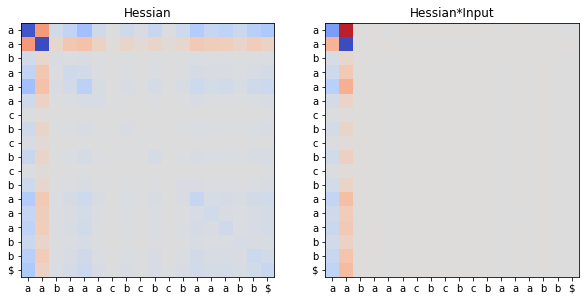

In [197]:
fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

for matrix, ax, title in zip([hessian, hessian_input], [ax1, ax2], ['Hessian', 'Hessian*Input']):
    max_val = torch.sort(abs(matrix.view(-1))).values[-2]*1.05
    ims = ax.imshow(matrix.detach(), cmap="coolwarm", clim=(-max_val, max_val))
    # ax1.colorbar(ims)
    ax.set_xticks(range(len(input_ids)))
    ax.set_yticks(range(len(input_ids)))
    ax.set_xticklabels(sen)
    ax.set_yticklabels(sen)
#     for x,y in deps:
#         rectangle = Rectangle((x-.5,y-.5), 1, 1, linewidth=2, facecolor='none', edgecolor='0.0', clip_on=False)
#         ax.add_patch(rectangle)

#         rectangle = Rectangle((y-.5,x-.5), 1, 1, linewidth=2, facecolor='none', edgecolor='0.0', clip_on=False)
#         ax.add_patch(rectangle)
    ax.set_title(title)

In [638]:
torch.autograd.functional.jacobian(
    func, input_embs
).sum([0,2]) # <-- high attribution for closing bracket?

tensor([-0.4739,  5.0399, -0.6973, -0.2277,  2.8663,  3.2888, -0.3379, -0.1990,
         0.8975,  4.2826])

## Captum Attributions

tensor([[-4.7684e-07, -1.0114e-03,  2.8610e-06,  4.7684e-07, -2.5272e-04,
         -1.1444e-05, -4.7684e-07, -2.3842e-06, -2.0313e-04]])


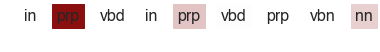

In [117]:
from captum.attr import FeatureAblation


class LastTokenModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        
        self.model = deepcopy(model)
        
    def forward(self, input_, **kwargs):
        bsz = input_.shape[0]

        output = self.model(inputs_embeds=input_, **kwargs)

        if bsz == 1 and output.ndim == 2:
            output = output.unsqueeze(0)
        
        if output.ndim == 0:
            return output.view(1,1)
        elif output.ndim == 1:
            return output.unsqueeze(1)
        if output.ndim == 3:
            return output[:, -1]
                
        return output[-1]
       

# model = experiment.best_model
# model = torch.load("dyck2.pt")
ltm = LastTokenModel(model)

ablator = FeatureAblation(ltm)

input_ = input_ids.unsqueeze(0) #language.train_corpus[2][0].unsqueeze(0)
target = 0
baseline = baseline_ids.unsqueeze(0) #torch.zeros_like(input_) + 4 # language.token2idx['0']

input_embeds = model.create_inputs_embeds(input_)
baseline_embeds = model.create_inputs_embeds(baseline)

fa_attribution = ablator.attribute(
    input_embeds, 
    baselines=baseline_embeds, 
    target=target, 
).sum(-1)
print(fa_attribution)

sen = [language.idx2token[idx] for idx in input_.squeeze()]#language.translate(input_.squeeze().tolist())
text_plot(sen, fa_attribution.numpy().squeeze())

tensor([[ 1.3021e-07, -6.1167e-03,  8.4728e-07,  8.9365e-07, -2.9203e-05,
          1.8371e-06,  1.3859e-07,  1.8398e-08, -3.6183e-03]])


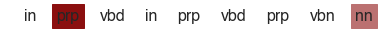

In [118]:
from captum.attr import DeepLift
from copy import deepcopy


dl = DeepLift(ltm)

dl_attribution = dl.attribute(input_embeds, baselines=baseline_embeds, target=target).sum(-1).detach()

print(dl_attribution)
text_plot(sen, dl_attribution.numpy().squeeze())

tensor([[ 1.9824e-02,  1.1450e+01, -4.0685e-02, -1.4197e-03,  8.6850e-01,
         -1.6706e-01,  2.4243e-02, -5.9760e-03,  2.1012e+00]],
       dtype=torch.float64) tensor([0.0004], dtype=torch.float64)


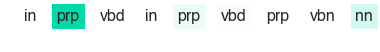

In [119]:
from captum.attr import IntegratedGradients
from copy import deepcopy


ig = IntegratedGradients(ltm)

ig_attribution, delta = ig.attribute(
    input_embeds, 
    baselines=baseline_embeds, 
    target=target, 
    n_steps=1000,
    return_convergence_delta=True,
)
ig_attribution = ig_attribution.sum(-1).detach()

print(ig_attribution, delta)
text_plot(sen, ig_attribution.numpy().squeeze())

tensor([[ 2.2878e-07,  2.3134e-03,  6.5400e-07,  7.8847e-07,  3.7040e-06,
          4.7483e-05,  5.2706e-07,  3.5273e-08, -6.3075e-03]])


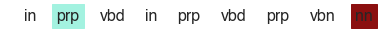

In [120]:
from captum.attr import InputXGradient


input_x_gradient = InputXGradient(ltm)

ixg_attribution = input_x_gradient.attribute(
    input_embeds,
    target=target,
).sum(-1).detach()

print(ixg_attribution)

text_plot(sen, ixg_attribution.numpy().squeeze())

tensor([[-1.6350e-07, -1.3555e-02, -3.9086e-06, -1.6805e-06, -8.3137e-05,
         -1.6227e-05, -7.1191e-07, -2.5516e-07,  6.5062e-06]])


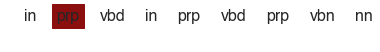

In [121]:
from captum.attr import DeepLiftShap

ds = DeepLiftShap(ltm, multiply_by_inputs=False)

baseline = torch.randint(language.num_symbols, (500, input_.shape[-1]))
baseline_distribution = model.create_inputs_embeds(baseline)

ds_attribution = ds.attribute(
    input_embeds, 
    baselines=baseline_embeds.repeat(2,1,1), 
    target=target,
).sum(-1).detach()

print(ds_attribution)
text_plot(sen, ds_attribution.numpy().squeeze())

tensor([[-1.1027, 76.4640, -0.8629, -1.1885, 18.7286, -0.1348,  1.1377, -1.4447,
         50.8906]])


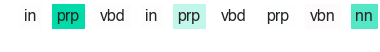

In [122]:
from captum.attr import KernelShap


ks = KernelShap(ltm)

feature_mask = (torch.zeros_like(input_embed) + torch.arange(input_.shape[-1]).view(1,-1,1)).long()

ks_attribution = ks.attribute(
    input_embeds, 
    baselines=baseline_embeds.repeat(1,1,1), 
    target=target,
    feature_mask=feature_mask,
).sum(-1)

print(ks_attribution)
text_plot(sen, ks_attribution.numpy().squeeze())

Model logit: 0.00

Feature Ablation


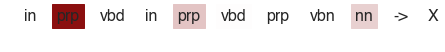


Input x Gradient


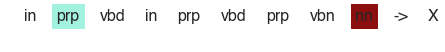


IG


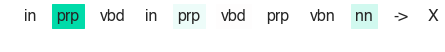


DeepLift


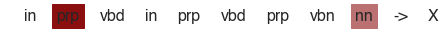


DeepSHAP


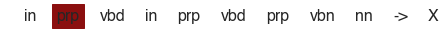


KernelSHAP


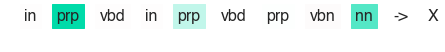

In [123]:
logit = 0#model(input_).squeeze().item()
print(f"Model logit: {logit:.2f}")
# pred_sen = list(sen) + ["->", eval(language.translate(input_[0]))]  # eval for arithmetic expression
pred_sen = list(sen) + ["->", "X"]

print("\nFeature Ablation")
text_plot(pred_sen, fa_attribution.squeeze().tolist() + [0, logit])
plt.show()

print("\nInput x Gradient")
text_plot(pred_sen, ixg_attribution.squeeze().tolist() + [0, logit])
plt.show()

print("\nIG")
text_plot(pred_sen, ig_attribution.squeeze().tolist() + [0, logit])
plt.show()

print("\nDeepLift")
text_plot(pred_sen, dl_attribution.squeeze().tolist() + [0, logit])
plt.show()

print("\nDeepSHAP")
text_plot(pred_sen, ds_attribution.squeeze().tolist() + [0, logit])
plt.show()

print("\nKernelSHAP")
text_plot(pred_sen, ks_attribution.squeeze().tolist() + [0, logit])
plt.show()

# LLM

In [2]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer


DEVICE = 'cpu'

"""
                 in   /  out  
RoBERTa:        69.70 / 58.47 MCC
DeBERTa:        71.19 / 56.60 MCC
DeBERTa-large:  73.26 / 70.11 MCC

"""

# model_name = 'yevheniimaslov/deberta-v3-large-cola'
model_name = 'textattack/roberta-base-CoLA'
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at textattack/roberta-base-CoLA were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
from datasets import Dataset, load_dataset


def tokenization(example):
    return tokenizer(example["text"])


dataset = load_dataset("csv", delimiter="\t", data_dir="cola", column_names=['cat', 'label', 'etc', 'text'])
dataset = dataset.map(tokenization, batched=True)
dataset.set_format(type="torch")

Using custom data configuration default-d1013937b0d64318
Found cached dataset csv (/home/jaap/.cache/huggingface/datasets/csv/default-d1013937b0d64318/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jaap/.cache/huggingface/datasets/csv/default-d1013937b0d64318/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-5a9d6be97672cce2.arrow
Loading cached processed dataset at /home/jaap/.cache/huggingface/datasets/csv/default-d1013937b0d64318/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-6bc11bb4df442fbb.arrow
Loading cached processed dataset at /home/jaap/.cache/huggingface/datasets/csv/default-d1013937b0d64318/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-1661742cf2f61f76.arrow


In [3]:
import torch
from tqdm import *
from sklearn.metrics import matthews_corrcoef as mcc


ncorrect = 0
correct = []
preds = []
split = 'test'

for idx in tqdm_notebook(range(len(dataset[split]['input_ids']))):
    item = dataset[split]['input_ids'][idx]
    label = dataset[split]['label'][idx]

    with torch.no_grad():
        out = model(item.unsqueeze(0))
        pred_label = out.logits.argmax(-1)

    preds.append(pred_label)
    correct.append(label == pred_label)
    ncorrect += label == pred_label

<ipython-input-3-3c0e5263fcac>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(range(len(dataset[split]['input_ids']))):


  0%|          | 0/516 [00:00<?, ?it/s]

In [4]:
mcc(dataset[split]['label'], [p.item() for p in preds])

0.7011852395444055

In [5]:
import torch
from tqdm import *


ncorrect = 0
correct = []
preds = []
split = 'validation'

for idx in tqdm_notebook(range(len(dataset[split]['input_ids']))):
    item = dataset[split]['input_ids'][idx]
    label = dataset[split]['label'][idx]

    with torch.no_grad():
        out = model(item.unsqueeze(0))
        pred_label = out.logits.argmax(-1)

    preds.append(pred_label)
    correct.append(label == pred_label)
    ncorrect += label == pred_label

mcc(dataset[split]['label'], [p.item() for p in preds])

<ipython-input-5-68839a30622c>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(range(len(dataset[split]['input_ids']))):


  0%|          | 0/527 [00:00<?, ?it/s]

0.732623033992897

In [65]:
dataset

DatasetDict({
    train: Dataset({
        features: ['cat', 'label', 'etc', 'text', 'input_ids', 'attention_mask'],
        num_rows: 8551
    })
    test: Dataset({
        features: ['cat', 'label', 'etc', 'text', 'input_ids', 'attention_mask'],
        num_rows: 516
    })
    validation: Dataset({
        features: ['cat', 'label', 'etc', 'text', 'input_ids', 'attention_mask'],
        num_rows: 527
    })
})

In [4]:
dataset['validation']['label'][:100]

tensor([1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
        1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
        1, 0, 1, 1])

In [30]:

# word_embeddings = model.roberta.embeddings.word_embeddings
# inputs_embeds = word_embeddings(input_ids)

tokenizer.eos_token_id

2

In [42]:
def group_ablation(
    model,
    input_ids, 
    baseline_ids, 
    coalitions=None, 
    use_embs=False, 
    exclude_diagonal=False, 
    keep=False, 
    discard=False, 
    background_distribution=None,
    num_marginal_samples=1,
    use_positional_prior=False,
):
    assert input_ids.ndim == 2
    
    if background_distribution is None:
        num_marginal_samples = 1
    num_inputs = input_ids.shape[0]
    max_sen_len = input_ids.shape[1]
    
    if baseline_ids is not None and baseline_ids.ndim == 1:
        baseline_ids = baseline_ids.unsqueeze(0)

    if coalitions is None:
        coalitions = [[idx] for idx in range(max_sen_len)]

    num_coalitions = len(coalitions)

    ablation_matrix = torch.zeros(num_inputs, num_coalitions, num_coalitions, device=DEVICE)
    mixed_input_matrix = []

    for i, coal_i in enumerate(coalitions):
        for j, coal_j in enumerate(coalitions[i+exclude_diagonal:], start=i+exclude_diagonal):
            coal_ij = list(set(flatten(coal_i + coal_j)))

            if discard:
                raise ValueError("discard not updated yet for batched input_ids")
                mixed_input = torch.tensor([x for k, x in enumerate(input_ids) if k not in coal_ij])
                if len(mixed_input) == 0:
                    break
            elif background_distribution is not None:
                mixed_input = background_distribution(
                    input_ids, 
                    coal_ij, 
                    num_marginal_samples=num_marginal_samples,
                    use_positional_prior=use_positional_prior,
                )
                mixed_input = torch.stack(mixed_input, dim=1)
            elif keep:
                mixed_input = torch.clone(baseline_ids)
                mixed_input[:, coal_ij] = input_ids[:, coal_ij]
            else:
                mixed_input = torch.clone(input_ids)
                mixed_input[:, coal_ij] = baseline_ids[:, coal_ij]
            
            if mixed_input.ndim == 2:
                mixed_input = mixed_input.unsqueeze(1)
            
            mixed_input_matrix.append(mixed_input)

    num_unique_coalitions = len(mixed_input_matrix)
    mixed_input_matrix = torch.cat(mixed_input_matrix, dim=1)
    mixed_input_matrix = mixed_input_matrix.view(num_inputs * num_unique_coalitions * num_marginal_samples, max_sen_len)
    
    with torch.no_grad():
        if not use_embs:
            mixed_input_matrix = model.create_inputs_embeds(mixed_input_matrix)

        output = model(inputs_embeds=mixed_input_matrix)  # (num_coalitions * num_inputs * num_marginal_samples,)
        output = output.view(num_inputs, num_marginal_samples, num_unique_coalitions)
        output = output.mean(1)

    k = 0
    for i, coal_i in enumerate(coalitions):
        for j, coal_j in enumerate(coalitions[i+exclude_diagonal:], start=i+exclude_diagonal):
            ablation_matrix[:,i,j] = output[:, k]
            ablation_matrix[:,j,i] = output[:, k]
            k += 1

    return ablation_matrix


def flatten(container):
    for i in container:
        if isinstance(i, (list,tuple)):
            for j in flatten(i):
                yield j
        else:
            yield i

class ModelWrapper:
    def __init__(self, model):
        self.model = model
        
    def create_inputs_embeds(self, input_ids):
        return self.model.roberta.embeddings.word_embeddings(input_ids)
    
    def __call__(self, inputs_embeds):
        return self.model(inputs_embeds=inputs_embeds).logits[:, 0]

    
wrapped_model = ModelWrapper(model)

idx = 0

input_ids = dataset['validation']['input_ids'][idx].unsqueeze(0)
label = dataset['validation']['label'][idx]

baseline_ids = torch.zeros_like(input_ids) + tokenizer.unk_token_id

# ablation_interactions = group_ablation(wrapped_model, input_ids.repeat(2,1), None, background_distribution=create_joint_intervential_baseline, num_marginal_samples=3)
%prun ablation_interactions = group_ablation(wrapped_model, input_ids, baseline_ids, num_marginal_samples=2)

ablation_interactions.shape

torch.Size([1, 12, 12])

         3544 function calls (3295 primitive calls) in 0.891 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       74    0.743    0.010    0.743    0.010 {built-in method torch._C._nn.linear}
       24    0.039    0.002    0.039    0.002 {built-in method matmul}
       12    0.033    0.003    0.033    0.003 {built-in method torch._C._nn.gelu}
       25    0.019    0.001    0.019    0.001 {built-in method layer_norm}
       12    0.014    0.001    0.265    0.022 modeling_roberta.py:377(forward)
       12    0.010    0.001    0.081    0.007 modeling_roberta.py:296(forward)
       12    0.006    0.001    0.006    0.001 {method 'softmax' of 'torch._C._TensorBase' objects}
       12    0.006    0.000    0.006    0.000 {method 'contiguous' of 'torch._C._TensorBase' objects}
        1    0.004    0.004    0.891    0.891 <ipython-input-42-3717b1fd902a>:1(group_ablation)
       12    0.003    0.000    0.246    0.021 modeling_robert

In [36]:
"""tensor([[[-1.6239, -1.3730,  0.0538, -0.5658, -0.0917,  0.2514, -0.6006,
          -0.5176, -0.8986, -0.5034, -1.5981, -0.4998],
         [-1.3730, -1.3750,  1.0039, -0.1952,  0.0590,  0.7207, -0.3575,
           0.6860, -0.4628, -0.2413, -1.3214, -0.0096],
"""
ablation_interactions[0]

tensor([[-1.6239, -1.3730,  0.0538, -0.5658, -0.0917,  0.2514, -0.6006, -0.5176,
         -0.8986, -0.5034, -1.5981, -0.4998],
        [-1.3730, -1.3750,  1.0039, -0.1952,  0.0590,  0.7207, -0.3575,  0.6860,
         -0.4628, -0.2413, -1.3214, -0.0096],
        [ 0.0538,  1.0039,  0.2299,  1.4628,  1.2968,  0.9602,  1.1162,  1.1837,
          0.7942,  0.8255,  0.7810,  0.5040],
        [-0.5658, -0.1952,  1.4628, -0.7335,  0.6367,  0.8448,  0.5156,  0.7060,
          0.3611,  0.6918,  0.2548, -0.0492],
        [-0.0917,  0.0590,  1.2968,  0.6367,  0.1536,  0.5070,  1.0336,  1.0143,
          0.8305,  0.5991,  0.3791,  0.4484],
        [ 0.2514,  0.7207,  0.9602,  0.8448,  0.5070, -0.2061,  0.9349,  0.8055,
          0.2679,  0.7552, -0.1102,  0.2177],
        [-0.6006, -0.3575,  1.1162,  0.5156,  1.0336,  0.9349, -0.3792, -0.3292,
          0.5558,  1.1501,  0.2242,  0.2326],
        [-0.5176,  0.6860,  1.1837,  0.7060,  1.0143,  0.8055, -0.3292, -0.4763,
          0.8711,  0.7938, -0.

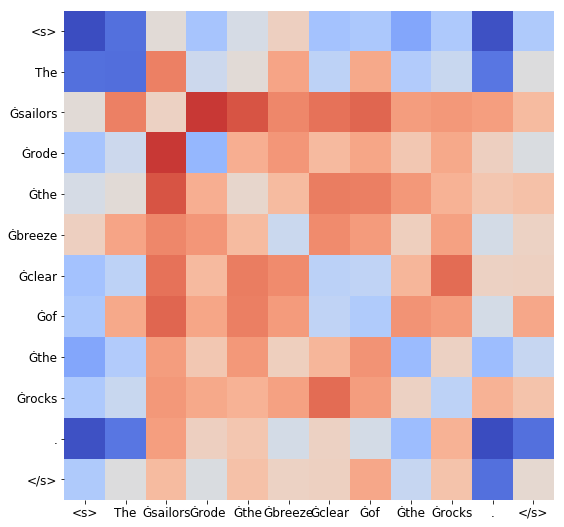

In [38]:
import matplotlib.pyplot as plt


def plot_interaction_matrix(interactions, input_ids=None, sen=None, deps=None, save_file=None, add_ranks=False):
    fig, ax = plt.subplots(figsize=(9,9))
    ims = ax.imshow(interactions, cmap="coolwarm", clim=(-torch.max(abs(interactions)), torch.max(abs(interactions))))
    # plt.colorbar(ims)

    if input_ids is not None:
        plt.xticks(range(len(input_ids)), input_ids.tolist())
        plt.yticks(range(len(input_ids)), input_ids.tolist())
    elif sen is not None:
        plt.xticks(range(len(sen)), sen, fontsize=12)
        plt.yticks(range(len(sen)), sen, fontsize=12)

    if deps is not None:
        for x,y in deps:
            rectangle = Rectangle((x-.5,y-.5), 1, 1, linewidth=3, facecolor='none', edgecolor='black', clip_on=False)
            ax.add_patch(rectangle)

            rectangle = Rectangle((y-.5,x-.5), 1, 1, linewidth=3, facecolor='none', edgecolor='black', clip_on=False)
            ax.add_patch(rectangle)
            
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['bottom'].set_color('none')

    plt.grid(False)
    
    if add_ranks:
        ax.text(6.5, -1, 'Relative', fontsize=12, ha='center', fontweight='bold')
        ax.text(6.5, -.7, 'Rank', fontsize=12, ha='center', fontweight='bold')
        ax.text(6.5, 6, 'ARR: 1.0', fontsize=12, ha='center', fontweight='bold')
        ax.text(2.5, -.85, 'Row Ranks', fontsize=12, ha='center', fontweight='bold')

        plt.plot([5.7,7.3],[5.5,5.5], color="0.5")
        
        for i, row in enumerate(interactions):
            ranks = torch.zeros_like(row).to(int)
            for idx, rank in enumerate(row.argsort()):
                ranks[rank] = idx

            for j, rank in enumerate(ranks.tolist()):
                ax.text(j,i,rank, fontsize=12, ha='center', va='center')
                
            ax.text(6.5, i+.1, '5/5', fontsize=12, ha='center')
    
    if save_file is not None:
        plt.savefig(save_file, bbox_inches = "tight")
        
    plt.show()


sen = tokenizer.convert_ids_to_tokens(input_ids[0])
plot_interaction_matrix(ablation_interactions[0], sen=sen)

In [85]:
random.choices([1,2,3], k=1, weights=[.8,.1,.1])

[1]

In [5]:
def create_distributions(tokenizer, path, split_positional_on_sen_len=False):
    with open(path) as f:
        lines = f.read().split('\n')
        
    # Tokenize
    tokenized = []
    for line in tqdm_notebook(lines):
        tokenized.append(tokenizer.encode(line))
        
    # Initialize
    sen_len_distribution = defaultdict(list)
    unigram_distribution = defaultdict(float)
    positional_distribution = defaultdict(lambda: defaultdict(float))

    # Set counts
    for sen in tokenized:
        sen_len = len(sen)
        sen_len_distribution[sen_len].append(sen)
        
        for idx, w in enumerate(sen):
            unigram_distribution[w] += 1
            if split_positional_on_sen_len:
                positional_distribution[sen_len, idx][w] += 1
            else:
                positional_distribution[idx][w] += 1

    # Normalize
    total_words = sum(unigram_distribution.values())
    for w in unigram_distribution:
        unigram_distribution[w] /= total_words

    for idx in positional_distribution:
        total_words = sum(positional_distribution[idx].values())
        for w in positional_distribution[idx]:
            positional_distribution[idx][w] /= total_words

    unigram_distribution = (
        list(unigram_distribution.keys()), 
        unigram_distribution.values()
    )
    positional_distribution = {
        idx: (list(idx_distribution.keys()), idx_distribution.values())
        for idx, idx_distribution in positional_distribution.items()
    }

    def sen_len_fn(sen_len, k=1):
        return random.choices(sen_len_distribution[sen_len], k=k)

    def unigram_fn(**kwargs):
        return random.choices(
            unigram_distribution[0],
            weights=unigram_distribution[1], 
            k=1,
        )[0]

    def positional_fn(idx, sen_len=None):
        if split_positional_on_sen_len:
            if sen_len is None:
                raise ValueError('sen_len must be provided!')
            return random.choices(
                positional_distribution[sen_len, idx][0], 
                weights=positional_distribution[sen_len, idx][1], 
                k=1,
            )[0]
        else:
            return random.choices(
                positional_distribution[idx][0], 
                weights=positional_distribution[idx][1], 
                k=1,
            )[0]

    return sen_len_fn, unigram_fn, positional_fn


sen_len_fn, unigram_fn, positional_fn = create_distributions(tokenizer, 'cola/100k_sentences.txt', split_positional_on_sen_len=True)


def create_unigram_baseline(input_ids, removed_ids, num_marginal_samples=1, **kwargs):
    assert input_ids.ndim == 2
    baselines = []
    
    sen_len = len(input_ids)
    
    for _ in range(num_marginal_samples):
        new_input = input_ids.clone()
        for batch_idx in range(input_ids.shape[0]):
            for idx, w in enumerate(input_ids[batch_idx]):
                if idx in removed_ids:
                    new_input[batch_idx, idx] = unigram_fn()
        baselines.append(new_input)
        
    return baselines
                

def create_positional_baseline(input_ids, removed_ids, num_marginal_samples=1, **kwargs):
    assert input_ids.ndim == 2
    baselines = []
    
    sen_len = input_ids.shape[1]
    
    for _ in range(num_marginal_samples):
        new_input = input_ids.clone()
        for batch_idx in range(input_ids.shape[0]):        
            for idx, w in enumerate(input_ids[batch_idx]):
                if idx in removed_ids:
                    new_input[batch_idx, idx] = positional_fn(idx, sen_len=sen_len)
        baselines.append(new_input)
        
    return baselines
                
                
def create_joint_intervential_baseline(input_ids, removed_ids, num_marginal_samples=1, **kwargs):
    assert input_ids.ndim == 2
    baselines = []
    
    sen_len = input_ids.shape[1]
    
    sampled_sens = sen_len_fn(sen_len, k=num_marginal_samples)
    
    for sampled_sen in sampled_sens:
        new_input = input_ids.clone()
        for batch_idx in range(input_ids.shape[0]):        
            for idx in range(len(new_input[batch_idx])):
                if idx in removed_ids:
                    new_input[batch_idx, idx] = sampled_sen[idx]

        baselines.append(new_input)
        
    return baselines

<ipython-input-5-62d85e99c279>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(lines):


  0%|          | 0/100001 [00:00<?, ?it/s]

In [129]:
item = dataset['validation']['input_ids'][0].unsqueeze(0)

In [170]:
tokenizer.decode(create_joint_intervential_baseline(item, [0,1,2,3])[0][0])

'<s>She swept through the breeze clear of the rocks.</s>'

In [41]:
ablation_interactions = group_ablation(wrapped_model, input_ids, baseline_ids, num_marginal_samples=1)

# sen = tokenizer.convert_ids_to_tokens(input_ids[0])

# plot_interaction_matrix(ablation_interactions[0], sen=sen)

# print(row_ranks(ablation_interactions[0,1:-1,1:-1], deps))

         227300 function calls (207878 primitive calls) in 3.602 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     5772    2.605    0.000    2.605    0.000 {built-in method torch._C._nn.linear}
      936    0.090    0.000    0.979    0.001 modeling_roberta.py:193(forward)
      936    0.087    0.000    0.087    0.000 {built-in method torch._C._nn.gelu}
     1872    0.081    0.000    0.081    0.000 {built-in method matmul}
17940/156    0.073    0.000    3.588    0.023 module.py:1096(_call_impl)
     1950    0.067    0.000    0.067    0.000 {built-in method layer_norm}
      936    0.046    0.000    0.046    0.000 {method 'softmax' of 'torch._C._TensorBase' objects}
    33150    0.040    0.000    0.040    0.000 module.py:1164(__getattr__)
      936    0.035    0.000    1.059    0.001 modeling_roberta.py:377(forward)
      936    0.023    0.000    0.303    0.000 modeling_roberta.py:296(forward)
     3744    0.021    0.000  

In [159]:
ablation_interactions

tensor([[[-1.6345, -0.3365,  0.4060,  0.0693,  0.3300,  0.2076,  0.3401,
          -0.5467, -0.5073, -0.4349, -1.6017, -1.6345],
         [-0.3365, -0.2508,  1.3620,  0.4255,  1.0940,  0.4667,  0.6922,
           0.5003,  0.0213, -0.2387,  0.0027,  0.1212],
         [ 0.4060,  1.3620,  0.8689,  1.4913,  1.3263,  0.8901,  1.2746,
           1.4357,  1.0561,  1.0593,  0.3287, -0.0565],
         [ 0.0693,  0.4255,  1.4913,  0.2353,  1.3534,  1.0815,  1.2781,
           1.0762,  1.0081,  0.9872,  0.6417,  0.5056],
         [ 0.3300,  1.0940,  1.3263,  1.3534,  0.2903,  0.7101,  1.3164,
           0.9869,  0.8336,  0.8274,  0.6041,  0.1112],
         [ 0.2076,  0.4667,  0.8901,  1.0815,  0.7101,  0.0585,  0.8412,
           0.7597,  0.5275,  0.5725,  0.2384, -0.0100],
         [ 0.3401,  0.6922,  1.2746,  1.2781,  1.3164,  0.8412,  0.8122,
           0.6398,  0.9164,  1.0947,  0.7923,  0.2543],
         [-0.5467,  0.5003,  1.4357,  1.0762,  0.9869,  0.7597,  0.6398,
          -0.1653,  0.67

In [61]:
dataset['validation']['label'].float().mean()

tensor(0.6894)

In [31]:
from scipy.sparse.csgraph import minimum_spanning_tree as mst


-mst(-torch.triu(ablation_interactions[1:-1, 1:-1])).toarray()

array([[-0.        ,  0.98229748, -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        ,  1.49069703,  1.32588148, -0.        ,
         1.10049605,  1.12757039,  0.89757907, -0.        ,  0.47832456],
       [-0.        , -0.        , -0.        , -0.        ,  1.15569985,
        -0.        , -0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        ,  0.951002  , -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        

In [143]:
import spacy


nlp = spacy.load("en_core_web_sm")


In [33]:
dataset['validation']['text'][0]

'The sailors rode the breeze clear of the rocks.'

In [144]:
doc = nlp("The sailors rode the breeze clear of the rocks .")

for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])

The det sailors NOUN []
sailors nsubj rode VERB [The]
rode ROOT rode VERB [sailors, breeze, clear, .]
the det breeze NOUN []
breeze dobj rode VERB [the]
clear advmod rode VERB [of]
of prep clear ADJ [rocks]
the det rocks NOUN []
rocks pobj of ADP [the]
. punct rode VERB []


In [49]:
doc[3].head.i

4

In [145]:
def edges(doc):
    edges = []

    for idx, token in enumerate(doc):
        edges.append(sorted((idx, token.head.i)))
        
    return edges

deps = edges(doc)

In [56]:
from spacy import displacy


displacy.render(doc, style='dep',jupyter=True)

In [147]:
import numpy as np


def row_ranks(interactions, deps):
    topk = torch.topk(-interactions, k=interactions.shape[-1]).indices
    row_ranks = []

    for i, j in dict(deps).items():
        row_rank = topk[i].tolist().index(j)
        row_ranks.append(row_rank / (interactions.shape[-1] - 1))

    return np.mean(row_ranks)


row_ranks(ablation_interactions[0,1:-1,1:-1], deps)

0.5238095238095238

# Explanation Evaluation

In [31]:
%load_ext autoreload
%autoreload 1
%aimport explainers.stii

from explainers.ih import integrated_hessians
from explainers.archipelago import archipelago
from explainers.stii import stii, sii
from explainers.hessian import hessian, hessian_input
from explainers.ablate import group_ablation
from sklearn.metrics import ndcg_score


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
def gen_dyck_deps(input_list):
    stack = []
    deps = []
    for idx, x in enumerate(input_list):
        if x < 2:
            stack.append((idx, x))
        else:
            prev_idx, y = stack.pop()
            assert (x - 2) == y, "string not well formed"
            deps.append((prev_idx, idx))

    return deps

def gen_fe_deps(_):
    return [(0,1)]


def gen_palin_deps(input_list):
    sen_len = len(input_list)
    use_separator = (sen_len % 2) == 1
    return [
        (i, sen_len-i-1)
        for i in range(sen_len // 2)
    ]


def invert_dyck(item):
    return torch.tensor([
        {
            0: 1,
            1: 0,
            2: 3,
            3: 2
        }[x.item()] for x in item
    ])


def invert_palin(item):
    new_item = []
    
    for idx, sym in enumerate(item):
        if idx < len(item) // 2:
            new_item.append((sym + 1) % language.config.n_items)
        else:
            new_item.append((sym + 1) % language.config.n_items + language.config.n_items)
    
    return torch.tensor(new_item)

In [33]:
def gen_dyck_rec(N, memoise):
    if N in memoise:
        return memoise[N]

    memoise[N] = []

    for i in range(1,N+1):
        between = gen_dyck_rec(i-1, memoise)
        after = gen_dyck_rec(N-i, memoise)
        for b in between:
            for a in after:
                memoise[N].append("a"+b+"A"+a)
                memoise[N].append("b"+b+"B"+a)

    return memoise[N]


def gen_dyck(N):
    memoise = {}
    memoise[0] = [""]
    memoise[1] = ["aA", "bB"]

    strings = gen_dyck_rec(N, memoise)
    tokenized = [[language.token2idx[x] for x in item] for item in strings]
    
    return torch.tensor(tokenized)

ALL_DYCK = {}

def dyck_cond_prob(input_ids: torch.Tensor, removed_ids: Tuple[int], num_marginal_samples=1, use_positional_prior=False):
    num_pairs = len(input_ids) // 2
    if num_pairs not in ALL_DYCK:
        ALL_DYCK[num_pairs] = gen_dyck(num_pairs)

    remaining_ids = tuple(i for i in range(len(input_ids)) if i not in removed_ids)
    
    mask = ALL_DYCK[num_pairs] == input_ids
    subset = ALL_DYCK[num_pairs][mask[:, remaining_ids].all(1) & ~mask[:, removed_ids].any(1)]
    
    if len(subset) > 0:
        baselines = random.choices(subset, k=num_marginal_samples)
    else:
        baselines = dyck_interventional(
            input_ids, 
            removed_ids, 
            num_marginal_samples=num_marginal_samples, 
            use_positional_prior=use_positional_prior
        )

    return baselines


def dyck_interventional(input_ids, removed_ids, num_marginal_samples=1, use_positional_prior=False):
    baselines = []
    remaining_ids = tuple(i for i in range(len(input_ids)) if i not in removed_ids)
    
    for _ in range(num_marginal_samples):
        baseline = []
        for idx in range(len(input_ids)):
            if idx in remaining_ids:
                baseline.append(input_ids[idx].item())
            else:
                candidate_ids = list(set(range(4)) - {input_ids[idx].item()})
                if use_positional_prior:
                    weights = positional_distribution_dict[idx][candidate_ids]
                    symbol = random.choices(candidate_ids, weights=weights)[0]
                else:
                    symbol = random.choice(candidate_ids)
                baseline.append(symbol)    
        baselines.append(torch.tensor(baseline))
        
    return baselines


def joint_interventional(input_ids, removed_ids, num_marginal_samples=1, **kwargs):
    baselines = []
    remaining_ids = tuple(i for i in range(len(input_ids)) if i not in removed_ids)
    
    for sample in random.choices(positive_distribution(input_ids, indices=removed_ids), k=num_marginal_samples):
        baseline = []
        for idx in range(len(input_ids)):
            if idx in remaining_ids:
                baseline.append(input_ids[idx].item())
            else:
                baseline.append(sample[idx].item())
        baselines.append(torch.tensor(baseline))
        
    return baselines


In [34]:
def palin_cond_prob(input_ids: torch.Tensor, removed_ids: Tuple[int], num_marginal_samples=1, use_positional_prior=False):
    baselines = []
    sen_len = len(input_ids)
    
    for _ in range(num_marginal_samples):
        baseline = torch.zeros_like(input_ids)
        for idx in range(sen_len):
            if idx in removed_ids:
                if idx < len(input_ids) // 2:
                    sym_range = range(language.config.n_items)
                else:
                    sym_range = range(language.config.n_items, language.config.n_items*2)
                candidate_ids = list(set(sym_range) - {input_ids[idx].item()})
                
                if sen_len - idx - 1 in removed_ids:
                    if idx >= (len(input_ids) // 2):
                        continue
                    symbol = random.choice(candidate_ids)
                    baseline[idx] = symbol
                    baseline[sen_len - idx - 1] = symbol + language.config.n_items
                else:
                    baseline[idx] = random.choice(sym_range)
            else:
                baseline[idx] = input_ids[idx]
        baselines.append(baseline)

        return baselines


def palin_interventional(input_ids, removed_ids, num_marginal_samples=1, use_positional_prior=False):
    baselines = []
    remaining_ids = tuple(i for i in range(len(input_ids)) if i not in removed_ids)
    
    for _ in range(num_marginal_samples):
        baseline = []
        for idx in range(len(input_ids)):
            if idx in remaining_ids:
                baseline.append(input_ids[idx].item())
            else:
                candidate_ids = list(set(range(language.num_symbols)) - {input_ids[idx].item()})
                if use_positional_prior:
                    weights = positional_distribution_dict[idx][candidate_ids]
                    symbol = random.choices(candidate_ids, weights=weights)[0]
                else:
                    symbol = random.choice(candidate_ids)
                baseline.append(symbol)
        baselines.append(torch.tensor(baseline))
        
    return baselines

item = language.corpus[0][0]
item, palin_cond_prob(item, (5,))

(tensor([0, 0, 3, 0, 0, 0, 2, 2, 1, 0, 1, 3, 2, 2]),
 [tensor([0, 0, 3, 0, 0, 0, 2, 2, 1, 0, 1, 3, 2, 2])])

In [35]:
def compute_interactions(
    explainer,
    model,
    item,
    baseline_type,
    use_embs,
    cond_prob_fn=None,
    interventional_prob_fn=None,
    **kwargs
):
    if baseline_type == "zero":
        baseline = torch.zeros_like(item) + 4
    elif baseline_type == "negative":
        baseline = random.choice(negative_distribution(item))
    elif baseline_type == "positive":
        baseline = random.choice(positive_distribution(item))
    elif baseline_type == "independent":
        baseline = torch.tensor(
            [random.choice(list(set(range(4)) - {x})) for x in item]
        )
    elif baseline_type == "positional":
        baseline = torch.tensor(
            [
                random.choices(
                    range(language.num_symbols), positional_distribution_dict[idx]
                )[0]
                for idx in range(len(item))
            ]
        )
    elif baseline_type == "invert":
        baseline = invert(item)
    elif baseline_type == "conditional":
        assert cond_prob_fn is not None
        assert not use_embs, "conditional not compatible with emb based methods"
        kwargs["background_distribution"] = cond_prob_fn
        baseline = None
    elif baseline_type == "interventional_independent":
        assert interventional_prob_fn is not None
        assert not use_embs, "marginal not compatible with emb based methods"
        kwargs["background_distribution"] = interventional_prob_fn
        kwargs["use_positional_prior"] = False
        baseline = None
    elif baseline_type == "interventional_positional":
        assert interventional_prob_fn is not None
        assert not use_embs, "interventional not compatible with emb based methods"
        kwargs["background_distribution"] = interventional_prob_fn
        kwargs["use_positional_prior"] = True
        baseline = None
    elif baseline_type == "joint_interventional":
        kwargs["background_distribution"] = joint_interventional
        baseline = None
    else:
        raise ValueError(baseline_type)

    if use_embs:
        embs = model.create_inputs_embeds(item)
        baseline_embs = model.create_inputs_embeds(baseline)
        interactions = explainer(model, embs, baseline_embs, **kwargs)
    else:
        interactions = explainer(model, item, baseline, **kwargs)

    return interactions.squeeze()


def evaluate(interactions, deps):
    score_dict = {
        "pos": deps_pos(interactions, deps),
        "ndcg": row_ndcg(interactions, deps),
        "row_rank": row_ranks(interactions, deps),
    }

    return score_dict


def deps_pos(interactions, deps):
    """Returns the ratio of *positive* dependency interactions"""
    pos_ids = np.argwhere(interactions > 0).tolist()
    pos_ids = set(zip(*pos_ids))

    return len(set(deps) & pos_ids) / len(deps)


def mean_rank(interactions, deps):
    """Returns the rank of each dependency interaction based on interaction scores

    A perfect ordering would have ranks [0, 1, 2, ...]
    The ranks are normalised between 0 and 1 (1 being best)
    """
    sorted_ids = np.argsort(-interactions.flatten().numpy())

    n = interactions.shape[0]
    sorted_ids = [tuple(sorted((i % n, i // n))) for i in sorted_ids if i % n <= i // n]

    ranks = [sorted_ids.index(dep) for dep in deps]

    total = len(sorted_ids)

    mean_rank = np.mean(ranks)
    num_deps = len(deps)
    # Scale between 0 and 1
    norm_rank = (
        (mean_rank - ((num_deps - 1) / 2))
        * ((total - 1) / (total - num_deps))
        / (total - 1)
    )

    return 1 - norm_rank


def row_ndcg(interactions, deps):
    """Returns the average row-wise NDCG scores."""
    assert interactions.ndim == 2
    deps_dict = dict(deps)

    ndcgs = []

    for i in range(interactions.shape[0]):
        if i in deps_dict:
            gold = np.zeros((1, interactions.shape[1]))
            gold[0, deps_dict[i]] = 1

            ndcgs.append(ndcg_score(gold, interactions[i].view(1, -1).numpy()))

    return np.mean(ndcgs)


def row_ranks(interactions, deps):
    topk = torch.topk(-interactions, k=interactions.shape[-1]).indices
    row_ranks = []

    for i, j in dict(deps).items():
        row_rank = topk[i].tolist().index(j)
        row_ranks.append(row_rank / (interactions.shape[-1] - 1))

    return np.mean(row_ranks)


negative_items = [x for x, l in language.corpus if l == 0]
positive_items = [x for x, l in language.corpus if l == 1 and len(x) <= 12]

positive_len_distribution = defaultdict(list)
for x in positive_items:
    positive_len_distribution[len(x)].append(x)

for length, items in positive_len_distribution.items():
    positive_len_distribution[length] = torch.stack(items, 0)
    
negative_len_distribution = defaultdict(list)
for x in negative_items:
    negative_len_distribution[len(x)].append(x)
    
for length, items in negative_len_distribution.items():
    negative_len_distribution[length] = torch.stack(items, 0)


def positive_distribution_fe(item):
    return [
        x
        for x in positive_items
        if len(x) == len(item) and item[0] not in x[:2] and item[1] not in x[:2]
    ]


def negative_distribution_fe(item):
    return [
        x
        for x in negative_items
        if len(x) == len(item) and item[0] not in x[:2] and item[1] not in x[:2]
    ]


def positive_distribution_dyck(item, indices=None):
    mask = positive_len_distribution[len(item)] != item

    if indices is not None:
        mask = mask[:, indices]
    mask = mask.all(-1)
    
    return positive_len_distribution[len(item)][mask]

def negative_distribution_dyck(item, indices=None):
    mask = negative_len_distribution[len(item)] != item
    if indices is not None:
        mask = mask[:, indices]
    mask = mask.all(-1)
    
    return negative_len_distribution[len(item)][mask]


def positional_distribution(corpus: List[Tuple[Tensor, int]], num_symbols=None):
    if num_symbols is None:
        num_symbols = language.num_symbols

    max_sen_len = max([len(x) for x, _ in corpus])
    distribution_dict = {idx: np.zeros(num_symbols) for idx in range(max_sen_len)}

    for item, label in corpus:
        if label == 0:
            continue

        for idx, symbol in enumerate(item.tolist()):
            distribution_dict[idx][symbol] += 1

    # Normalise
    for idx, counts in distribution_dict.items():
        distribution_dict[idx] /= sum(counts)

    return distribution_dict


def create_score_df(
    experiments,
    baseline_types,
    sample_size,
    expectation_samples,
    sample_curve=False,
    trim: Optional[int] = None,
    cond_prob_fn=None,
    interventional_prob_fn=None,
    num_marginal_samples=1,
):
    raw_dataframe = []

    for explainer, name, use_embs, kwargs in experiments:
        scores = defaultdict(list)

        for item in tqdm_notebook(positive_items[0:sample_size]):
            if trim is not None:
                item = item[:trim]

            for baseline_type in baseline_types:
                print(baseline_type)
                if (
                    baseline_type != "zero" and explainer in [hessian, hessian_input]
                ) or (
                    baseline_type in [
                        "interventional_independent", 
                        "interventional_positional", 
                        "joint_interventional", 
                        "conditional",
                    ]
                    and explainer in [integrated_hessians, archipelago]
                ):
                    continue
                deps = deps_fn(item)
                if name == "Archipelago":
                    kwargs["top_k"] = len(deps)
                
                all_interactions = []

                if baseline_type in ["zero", "invert"]:
                    interactions = compute_interactions(
                        explainer,
                        model,
                        item,
                        baseline_type,
                        use_embs,
                        **kwargs
                    )
                    all_interactions.append(interactions)
                elif baseline_type in ["positive", "negative", "independent", "positional"]:
                    for k in range(expectation_samples):
                        interactions = compute_interactions(
                            explainer,
                            model,
                            item,
                            baseline_type,
                            use_embs,
                            **kwargs
                        )
                        all_interactions.append(interactions)
                else:
                    interactions = compute_interactions(
                        explainer,
                        model,
                        item,
                        baseline_type,
                        use_embs,
                        cond_prob_fn=cond_prob_fn,
                        interventional_prob_fn=interventional_prob_fn,
                        num_marginal_samples=num_marginal_samples,
                        **kwargs
                    )
                    all_interactions.append(interactions)

                if sample_curve:
                    for i in range(expectation_samples):
                        avg_interactions = torch.mean(
                            torch.stack(all_interactions[: i + 1]), dim=0
                        )
                        score_dict = evaluate(avg_interactions, deps)

                        scores[baseline_type + str(i)].append(score_dict)
                else:
                    avg_interactions = torch.mean(torch.stack(all_interactions), dim=0)
                    score_dict = evaluate(avg_interactions, deps)

                    scores[baseline_type].append(score_dict)

        raw_dataframe.append([name] + [scores])

    return raw_dataframe


deps_fn = gen_palin_deps  # gen_dyck_deps
positive_distribution = positive_distribution_dyck
negative_distribution = negative_distribution_dyck
# deps_fn = gen_fe_deps
# positive_distribution = positive_distribution_fe
# negative_distribution = negative_distribution_fe
invert = invert_palin  # invert_dyck

positional_distribution_dict = positional_distribution(language.corpus)

experiments = [
    # (group_ablation, "Group Ablation", False, {}),
    # (archipelago, "Archipelago", True, {}),
    (sii, "SII", False, {"verbose": False, "processes": 1}),
    (stii, "STII", False, {"verbose": False, "processes": 1}),
    # (hessian, "Hessian", True, {}),
    # (hessian_input, "Hessian * Input", True, {}),
    # (integrated_hessians, "IH", True, {}),
]
baseline_types = [
    "zero",
    "invert",
    "positive",
    "negative",
    # "independent",
    # "positional",
    "interventional_independent",
    "interventional_positional",
    "joint_interventional",
    "conditional",
]
sample_size = 1
expectation_samples = 5
num_marginal_samples = 5

raw_df = create_score_df(
    experiments,
    baseline_types,
    sample_size,
    expectation_samples,
    sample_curve=False,
    trim=None,
    cond_prob_fn=palin_cond_prob,  # dyck_cond_prob,
    interventional_prob_fn=palin_interventional,  # dyck_interventional,
    num_marginal_samples=num_marginal_samples,
)

zero
invert
positive
negative
interventional_independent
interventional_positional
joint_interventional
conditional



zero
invert
positive
negative
interventional_independent
interventional_positional
joint_interventional
conditional



In [36]:
raw_df

[['SII',
  defaultdict(list,
              {'zero': [{'pos': 0.8,
                 'ndcg': 0.36494316873429833,
                 'row_rank': 0.3777777777777778}],
               'invert': [{'pos': 1.0,
                 'ndcg': 0.9261859507142916,
                 'row_rank': 0.9777777777777779}],
               'positive': [{'pos': 1.0,
                 'ndcg': 0.7047438028571659,
                 'row_rank': 0.9111111111111111}],
               'negative': [{'pos': 1.0,
                 'ndcg': 0.6387638512756706,
                 'row_rank': 0.7555555555555555}],
               'interventional_independent': [{'pos': 1.0,
                 'ndcg': 0.5009839002970957,
                 'row_rank': 0.711111111111111}],
               'interventional_positional': [{'pos': 1.0,
                 'ndcg': 0.81232126232897,
                 'row_rank': 0.9111111111111111}],
               'joint_interventional': [{'pos': 1.0,
                 'ndcg': 0.6236133388501874,
                 'row_ra

In [347]:
baseline_types = [
    "zero",
    "invert",
    "positive",
    "negative",
    # "independent",
    # "positional",
    "interventional_independent",
    "interventional_positional",
    "joint_interventional",
    "conditional",
]

In [338]:
def gen_latex_table(raw_df, metric, baseline_types, do_print=True, digits=3):
    raw_mean_df = [
        [name] + [
            np.mean([scores[metric] for scores in all_scores[baseline_type]])
            for baseline_type in baseline_types
        ] for name, all_scores in raw_df
    ]
    df = pd.DataFrame(raw_mean_df, columns=["method"] + baseline_types)
    latex_str = df.to_latex(index=False, float_format=lambda x: f'%.{digits}f' % x)
    
    max_vals = [f"{x:.{digits}f}" for x in df.max()[1:].values]
    for val in set(max_vals):
        latex_str = latex_str.replace(val, f"\\textbf{{{val}}}")
    latex_str = latex_str.replace(" * ", "$\\times$")
    latex_str = latex_str.replace("NaN", "--")
    
    if do_print:
        print(latex_str)
    
    return df

import pickle

with open('raw_df_dyck_20samples.pt', 'rb') as f:
    raw_df2 = torch.load(f)


for metric in ['row_rank']:
    df = gen_latex_table(raw_df, metric, baseline_types, digits=3)

\begin{tabular}{lrrrrrrrr}
\toprule
method &  zero &  invert &  positive &  negative &  interventional\_independent &  interventional\_positional &  joint\_interventional &  conditional \\
\midrule
   SII & \textbf{0.472} &   \textbf{0.933} &     \textbf{1.000} &     0.892 &                       \textbf{0.804} &                      \textbf{0.817} &                 \textbf{1.000} &        \textbf{1.000} \\
  STII & \textbf{0.472} &   0.921 &     0.999 &     \textbf{0.917} &                       0.760 &                      0.792 &                 \textbf{1.000} &        0.999 \\
\bottomrule
\end{tabular}



1.2128998

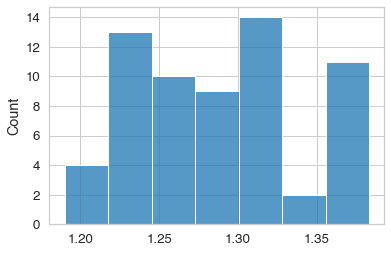

In [890]:
# positive_distribution_dyck(item)
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances


emb_distances = cosine_distances(weights[:4])

def input_distance(item, item2):
    return np.mean([emb_distances[x, y] for x, y in zip(item, item2)])


def trim_distribution(item, k=25):
    distribution = positive_distribution_dyck(item)
    ids = np.argsort([(input_distance(item, item2)) for item2 in distribution])
    
    return [distribution[idx] for idx in ids[:k]]
    
# input_distance(item, item)
# torch.softmax(torch.tensor([(input_distance(item, item2)**3) for item2 in distribution]), 0)

sns.histplot([(input_distance(item, item2)) for item2 in distribution])

input_distance(item, invert(item))

/home/jaap/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jaap/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KeyError: 'zero1'

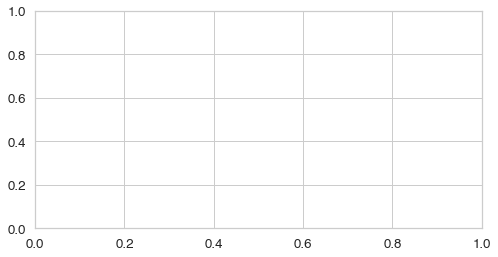

In [91]:
df = gen_latex_table(raw_df, "row_rank", list(raw_df[0][1].keys()), do_print=False)

fig, ax = plt.subplots(figsize=(8,4))

max_samples = 18

for baseline_type in baseline_types:
    for name in sorted(df.method.unique()):
        pos_vals = [df[df.method == name][f"{baseline_type}{i}"].item() for i in range(1,max_samples+1)]

        plot_cls = plt.plot(range(1,max_samples+1), pos_vals, "-o", label=name, lw=2, markersize=4)

        plot_color = plot_cls[0].get_color()
        offset = {
            "SII": 0.018,
            "Group Ablation": -0.007,
            "STII": -0.005,
        }.get(name, 0)
        plt.text(max_samples+0.5, pos_vals[-1]-0.015+offset, baseline_type, color=plot_color, fontsize=12)

# hessian_val = 0.4
# hessian_input_val = 0.54
# plt.plot([1, max_samples], [hessian_val, hessian_val], ls='--', color="blue", alpha=0.4)
# plt.text(len(pos_vals)+.5, hessian_val-0.01, "Hessian", color="blue", fontsize=12, alpha=0.4)
# plt.plot([1, max_samples], [hessian_input_val, hessian_input_val], ls='--', color="lightblue")
# plt.text(len(pos_vals)+.5, hessian_input_val-0.01, "Hessian*Input", color="lightblue", fontsize=12)
    
# plt.legend(bbox_to_anchor=(1.,1.))
plt.ylim(0.2,1.)
plt.xlabel("# of baseline samples")
plt.ylabel("Average Relative Rank")
plt.xticks(range(1, max_samples+1, 2))

plt.grid(color="0.9")
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

# plt.savefig("figures/baseline_samples.pdf", bbox_inches = "tight")
plt.show()

In [314]:
from itertools import product, combinations, chain
from math import comb, factorial
from tqdm import *
import torch


def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))


def sii(model, input_ids, baseline_ids, **kwargs):
    return stii(model, input_ids, baseline_ids, taylor=False, **kwargs)


def stii2(
    model, 
    input_ids, 
    baseline_ids, 
    taylor=True, 
    batch_size=1000, 
    verbose=False, 
    background_distribution=None,
    use_positional_prior=False,
    num_marginal_samples=1,
):
    N = set(range(len(input_ids)))
    k = 2
    n = len(N)
    num_coalitions = 2**n

    pair_ids = [(i, j) for i in range(n) for j in range(i + 1, n) ]
    sti_matrix = torch.zeros(len(input_ids), len(input_ids))
    iterator = tqdm_notebook if verbose else lambda x: x

    output_matrix = torch.zeros(num_marginal_samples, num_coalitions)
    
    for sample_idx in range(num_marginal_samples):
        input_matrix = torch.zeros(num_coalitions, n, dtype=torch.long)

        # fuse input and baseline ids
        for S in iterator(powerset(range(n))):
            complement = list(N-set(S))
            S = list(S)
            # Coalitions are indexed as a binary number based on present features
            idx = sum(2**x for x in S)

            if background_distribution is None:
                input_matrix[idx, S] = input_ids[S]
                input_matrix[idx, complement] = baseline_ids[complement]
            else:
                input_matrix[idx] = background_distribution(
                    input_ids, S, use_positional_prior=use_positional_prior
                )[0]

        with torch.no_grad():
            for idx in iterator(range(0, num_coalitions, batch_size)):
                batch_input = input_matrix[idx:idx+batch_size]
                batch_embs = model.create_inputs_embeds(batch_input)
                batch_output = model(inputs_embeds=batch_embs)
                output_matrix[sample_idx, idx:idx+batch_size] = batch_output

    # Average over sample dimension
    output_matrix = output_matrix.mean(0)
             
    if taylor:
        normalising_terms = {
            t: 1 / comb(n-1, t)
            for t in range(n-1)
        }
    else:
        normalising_terms = {
            t: (
                (factorial(n - t - k) * factorial(t)) / factorial(n - k + 1)
            )
            for t in range(n-1)
        }
    
    
    for i, j in iterator(pair_ids):
        val = 0

        for T in (powerset(N - {i, j})):
            idx_T = sum(2**x for x in T)
            idx_i = 2**i
            idx_j = 2**j

            # We compute the loop over W in S (eq.3) directly, much more efficient
            # When generalising STII to any k this needs to be modified
            delta = (
                output_matrix[idx_T]
                - output_matrix[idx_T + idx_i]
                - output_matrix[idx_T + idx_j]
                + output_matrix[idx_T + idx_i + idx_j]
            )

            val += delta * normalising_terms[len(T)]

        if taylor:
            val *= k/n

        sti_matrix[i,j] = val
        sti_matrix[j,i] = val
    
    return sti_matrix


baseline = torch.tensor([4]*len(item))
stii2(model, item, baseline, verbose=True, taylor=False)

tensor([[ 0.0000e+00,  2.9052e+00,  4.6241e+00,  1.6309e+00,  1.2051e+00,
          1.3505e+00,  2.8312e+00,  3.0676e+00,  1.8347e+00,  9.3911e-01,
          2.3385e-01, -2.2461e-01],
        [ 2.9052e+00,  0.0000e+00,  3.2305e+00,  2.9942e+00,  1.3394e+00,
          1.0531e+00,  2.9727e+00,  2.4036e+00,  1.7377e+00,  1.4371e+00,
          6.9551e-01,  1.1319e+00],
        [ 4.6241e+00,  3.2305e+00,  0.0000e+00,  2.8969e+00,  1.1376e+00,
          1.4769e+00,  2.8906e+00,  2.9311e+00,  2.2815e+00,  1.2359e+00,
          6.0386e-01,  4.9079e-01],
        [ 1.6309e+00,  2.9942e+00,  2.8969e+00,  0.0000e+00,  2.5726e-02,
          1.4584e+00,  2.4070e+00,  2.1139e+00,  1.2387e+00,  3.6671e-01,
          3.0806e-01,  1.3892e+00],
        [ 1.2051e+00,  1.3394e+00,  1.1376e+00,  2.5726e-02,  0.0000e+00,
          1.5945e-01,  8.5130e-01,  1.3101e+00,  1.4389e+00,  6.0977e-01,
          2.8775e-01,  2.1068e-01],
        [ 1.3505e+00,  1.0531e+00,  1.4769e+00,  1.4584e+00,  1.5945e-01,
      

# Misc


In [9]:
from transformers import AutoConfig, GPT2LMHeadModel, PreTrainedTokenizerFast


def initialize_model(
    model_type: str, **config
) -> GPT2LMHeadModel:
    config = AutoConfig.from_pretrained(
        model_type,
        vocab_size=10000,
        **config,
    )

    model = GPT2LMHeadModel(config)

    return model


model = initialize_model('sshleifer/tiny-gpt2')

In [10]:
model.transformer.h[0].attn.c_attn.weight

Parameter containing:
tensor([[ 0.0026, -0.0213, -0.0421, -0.0179, -0.0127,  0.0162],
        [ 0.0111,  0.0193,  0.0104, -0.0260,  0.0320, -0.0146]],
       requires_grad=True)

In [27]:
probs = [prod.prob() for prod in grammar.productions()]

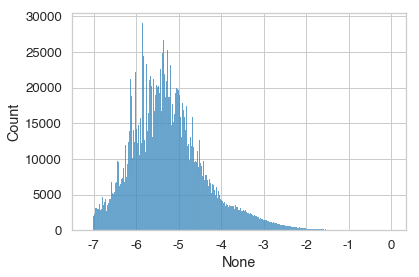

In [32]:
sns.histplot(np.log10(np.array(probs)))